# 🕸️ Network Analysis of Python Package Vulnerabilities

Análise de vulnerabilidades usando **Teoria de Redes**:

- **Temporal Analysis**: evolução, survival curves, vulnerabilidades ativas
- **Network Metrics**: grau, betweenness, eigenvector, modularidade
- **Dependency Analysis**: exposição direta/indireta, profundidade
- **Comparison**: General vs AI Libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

print('✅ Setup complete')

✅ Setup complete


## 📂 1. Load Data

In [2]:
# Load
vulns = pd.read_csv('outputs/top_pypi_snyk_timeline_20231101_20251101.csv')
deps = pd.read_csv('python_dependencies_edges.csv')

print(f'Vulnerabilidades: {len(vulns)}, Pacotes: {vulns["package"].nunique()}')
print(f'Dependências: {len(deps)} arestas')

# Parse dates
for col in ['first_affected_date', 'disclosed_date', 'mitigation_date']:
    if col in vulns.columns:
        vulns[col] = pd.to_datetime(vulns[col], errors='coerce')

# Severity numeric
severity_map = {'low': 1, 'moderate': 2, 'medium': 2, 'high': 3, 'critical': 4, 'unknown': 2}
vulns['severity_norm'] = vulns['severity'].str.lower().map(severity_map).fillna(2)

vulns.head()

Vulnerabilidades: 649, Pacotes: 184
Dependências: 3463 arestas


package             cve  cwes  severity first_affected_version  \
0   urllib3  CVE-2024-37891   NaN  moderate                      0   
1   urllib3  CVE-2025-50182   NaN  moderate                  2.2.0   
2   urllib3  CVE-2025-50181   NaN  moderate                      0   
3  requests  CVE-2024-47081   NaN  moderate                      0   
4  requests  CVE-2024-35195   NaN  moderate                      0   

  first_affected_date disclosed_date mitigation_version mitigation_date  \
0                 NaT     2024-06-17            1.26.19      2024-06-17   
1          2024-01-30     2025-06-18              2.5.0      2025-06-18   
2                 NaT     2025-06-18              2.5.0      2025-06-18   
3                 NaT     2025-06-09             2.32.4      2025-06-09   
4                 NaT     2024-05-20             2.32.0      2024-05-20   

   disclosure_lag_days  time_to_fix_from_first_days  \
0                  NaN                          NaN   
1                505.0                        505.0   
2                  NaN                          NaN   
3                  NaN                          NaN   
4                  NaN                          NaN   

   time_to_fix_from_disclosure_days fix_semver_type  severity_norm  
0                               0.0           major              2  
1                               0.0           minor              2  
2                               0.0           major              2  
3                               0.0           major              2  
4                               0.0           major              2

## 🤖 2. AI Libraries

In [3]:
AI_LIBS = {
    'torch', 'tensorflow', 'keras', 'pytorch-lightning', 'lightning',
    'scikit-learn', 'xgboost', 'lightgbm', 'catboost',
    'transformers', 'sentence-transformers', 'tokenizers',
    'langchain', 'langchain-core', 'langchain-community',
    'llama-index', 'llama-index-core',
    'vllm', 'litellm', 'openai',
    'mlflow', 'wandb', 'clearml', 'sagemaker',
    'gradio', 'streamlit',
    'opencv-python', 'pillow'
}

vulns['is_ai_lib'] = vulns['package'].str.lower().isin(AI_LIBS)
print(f'AI vulnerabilities: {vulns["is_ai_lib"].sum()}')

AI vulnerabilities: 216


## 🕸️ 3. Build Network

In [4]:
G = nx.DiGraph()

for _, row in deps.iterrows():
    src, tgt = str(row['source']).lower(), str(row['target']).lower()
    if src and tgt and src != 'nan' and tgt != 'nan':
        G.add_edge(src, tgt)

for pkg in vulns['package'].unique():
    if pkg and str(pkg) != 'nan':
        G.add_node(str(pkg).lower())

print(f'Nós: {G.number_of_nodes()}, Arestas: {G.number_of_edges()}')
print(f'Densidade: {nx.density(G):.6f}')

UG = G.to_undirected()
print(f'Componentes: {nx.number_connected_components(UG)}')

Nós: 1555, Arestas: 3463
Densidade: 0.001433
Componentes: 11


## 📊 4. Network Metrics

In [5]:
print('Calculando métricas...')

degree_dict = dict(G.degree())
in_degree_dict = dict(G.in_degree())
out_degree_dict = dict(G.out_degree())

print('  Betweenness...')
betweenness_dict = nx.betweenness_centrality(G)

print('  Eigenvector...')
try:
    eigenvector_dict = nx.eigenvector_centrality_numpy(UG, max_iter=1000)
except:
    eigenvector_dict = {}

print('  PageRank...')
pagerank_dict = nx.pagerank(G)

metrics_df = pd.DataFrame({
    'package': list(G.nodes()),
    'degree': [degree_dict.get(n, 0) for n in G.nodes()],
    'in_degree': [in_degree_dict.get(n, 0) for n in G.nodes()],
    'out_degree': [out_degree_dict.get(n, 0) for n in G.nodes()],
    'betweenness': [betweenness_dict.get(n, 0) for n in G.nodes()],
    'eigenvector': [eigenvector_dict.get(n, 0) for n in G.nodes()],
    'pagerank': [pagerank_dict.get(n, 0) for n in G.nodes()]
})

metrics_df['is_ai_lib'] = metrics_df['package'].isin(AI_LIBS)

print('✅ Done')
metrics_df.describe()

Calculando métricas...
  Betweenness...
  Eigenvector...
  PageRank...
✅ Done


degree    in_degree   out_degree  betweenness  eigenvector  \
count  1555.000000  1555.000000  1555.000000  1555.000000       1555.0   
mean      4.454019     2.227010     2.227010     0.000009          0.0   
std      11.239051     3.947277    10.458869     0.000088          0.0   
min       0.000000     0.000000     0.000000     0.000000          0.0   
25%       1.000000     1.000000     0.000000     0.000000          0.0   
50%       1.000000     1.000000     0.000000     0.000000          0.0   
75%       2.000000     2.000000     0.000000     0.000000          0.0   
max     144.000000    52.000000   143.000000     0.002234          0.0   

          pagerank  
count  1555.000000  
mean      0.000643  
std       0.000175  
min       0.000582  
25%       0.000592  
50%       0.000596  
75%       0.000620  
max       0.003930

## 🏆 5. Top Packages

In [6]:
print('Top 15 by IN-DEGREE (most depended-upon):')
metrics_df.nlargest(15, 'in_degree')[['package', 'in_degree', 'is_ai_lib']]

Top 15 by IN-DEGREE (most depended-upon):


package  in_degree  is_ai_lib
17              pytest         52      False
318              numpy         43      False
154           requests         41      False
3    typing-extensions         35      False
40              pyyaml         33      False
57           packaging         33      False
163       cryptography         31      False
128         pytest-cov         30      False
301             sphinx         30      False
277             pandas         29      False
46            pydantic         28      False
161             jinja2         25      False
300           coverage         24      False
355              click         24      False
39              pillow         22       True

## 🎨 5.5. Network Visualization

Criando visualização da rede geral...
Subgrafo para visualização: 100 nós, 161 arestas
Calculando layout...


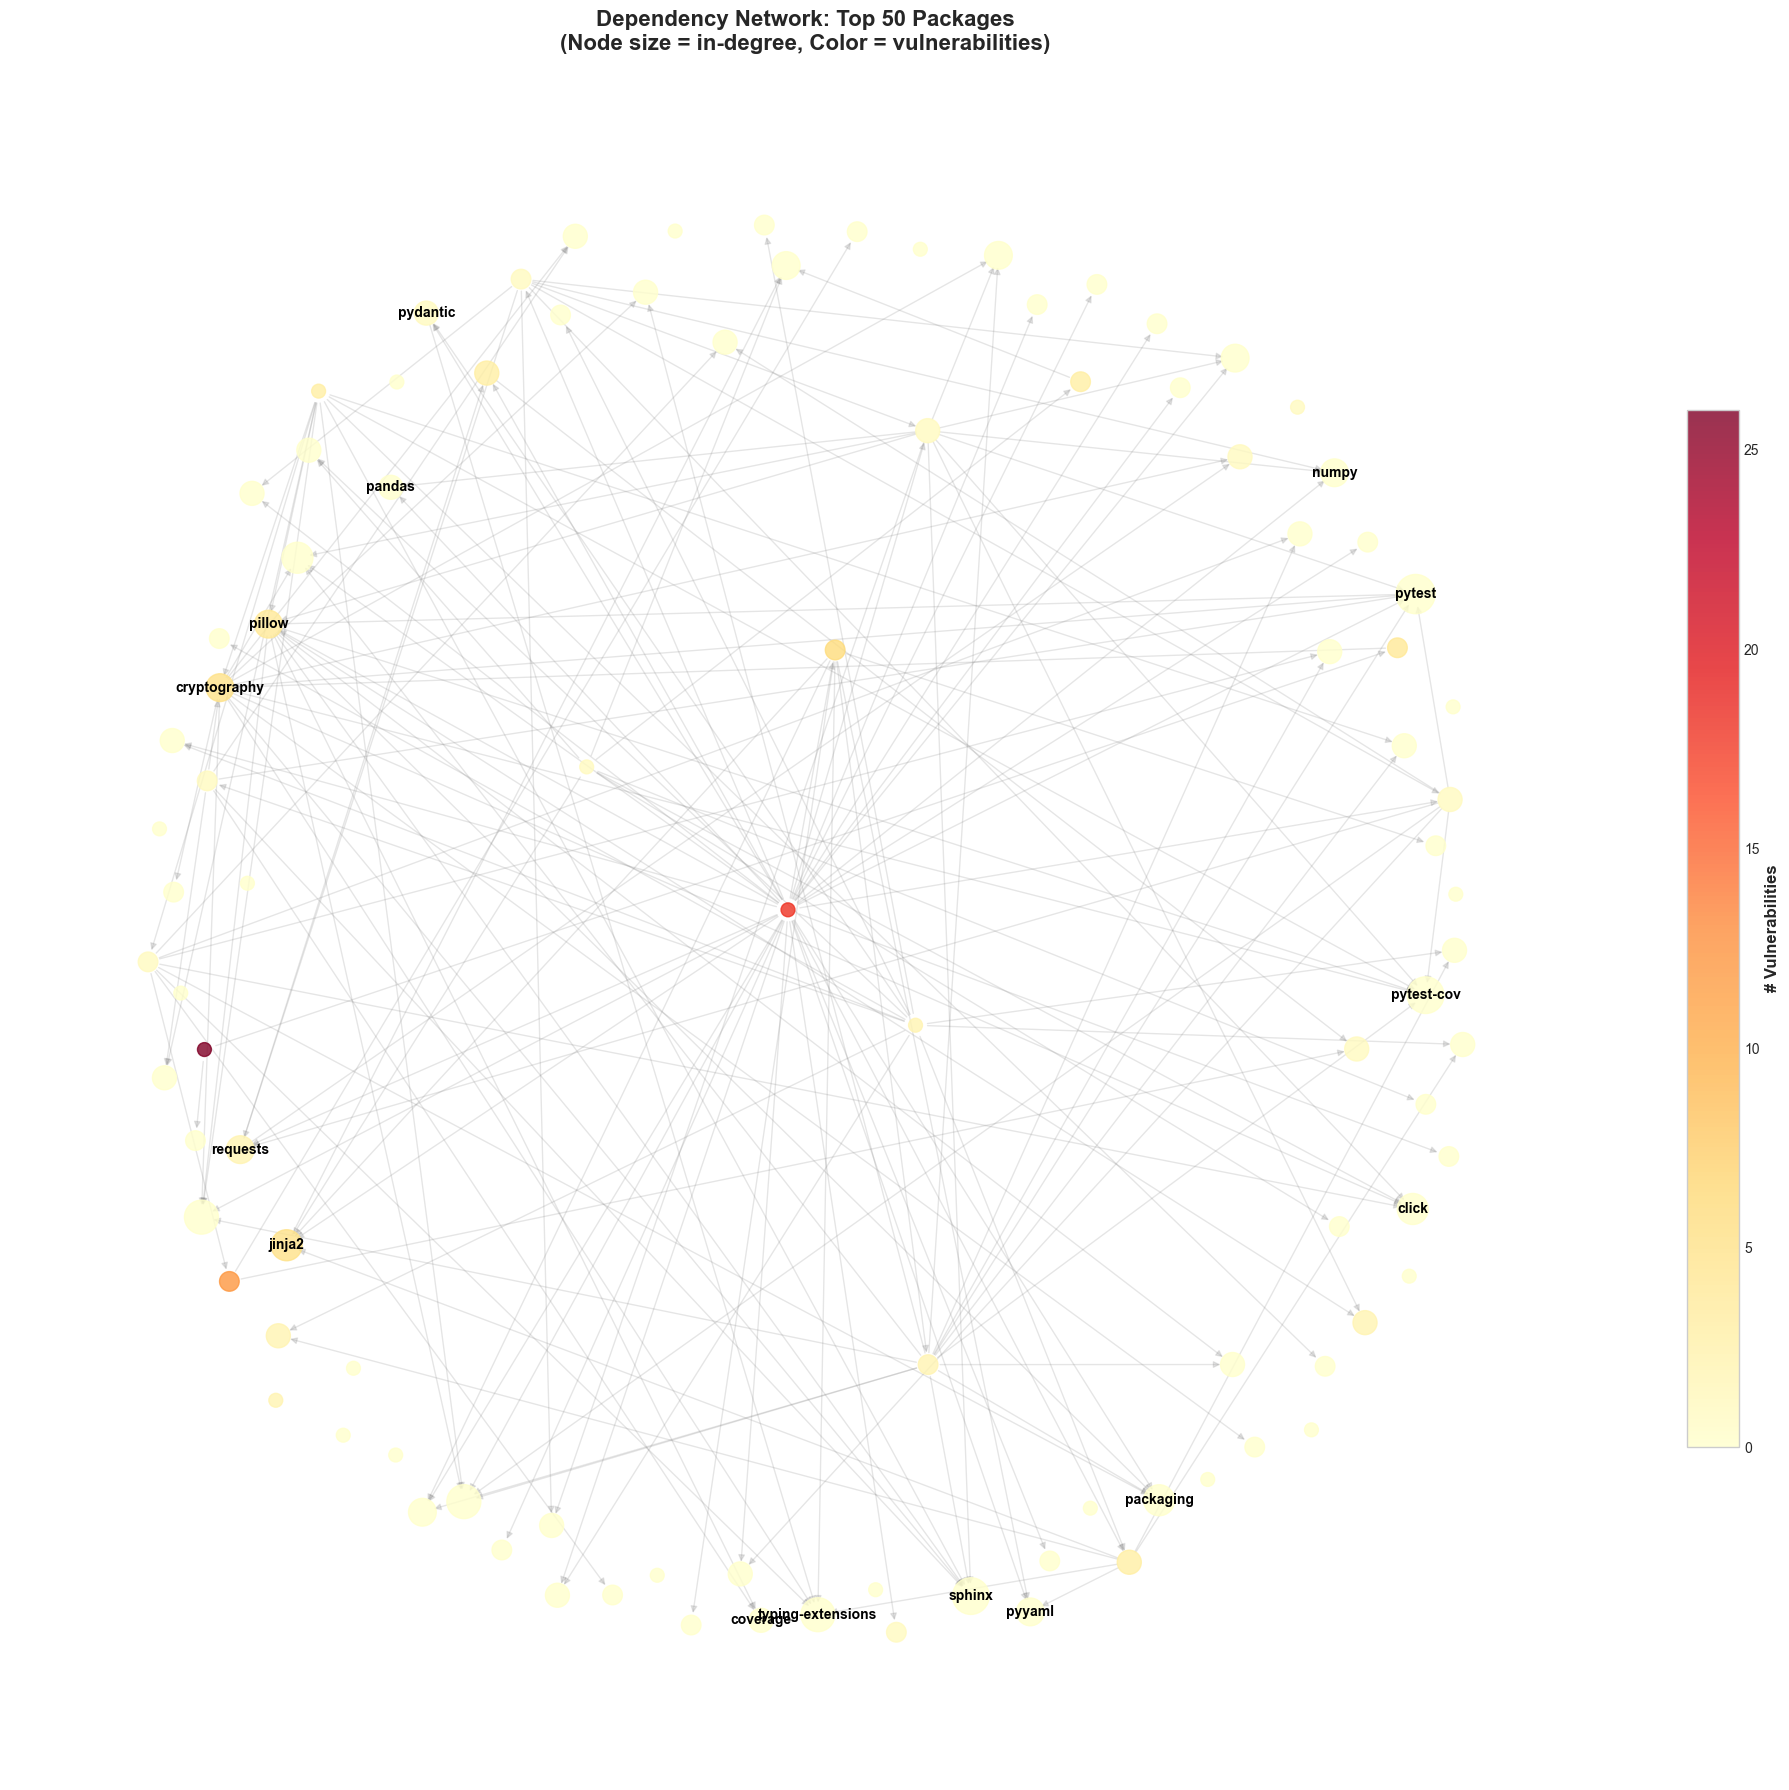

✅ Saved: outputs/plots/network_graph_general.png


In [18]:
# Selecionar subgrafo dos pacotes mais importantes para visualização
# (grafo completo seria muito denso)
print('Criando visualização da rede geral...')

# Top 50 pacotes por in_degree
top_packages = metrics_df.nlargest(100, 'in_degree')['package'].tolist()

# Criar subgrafo
G_viz = G.subgraph(top_packages).copy()

print(f'Subgrafo para visualização: {G_viz.number_of_nodes()} nós, {G_viz.number_of_edges()} arestas')

# Calcular layout
print('Calculando layout...')
pos = nx.spring_layout(G_viz, k=2, iterations=50, seed=42)

# Preparar cores por vulnerabilidades
vuln_counts = vulns_net.groupby('package_lower')['cve'].nunique().to_dict()
node_colors = [vuln_counts.get(node, 0) for node in G_viz.nodes()]

# Preparar tamanhos por in_degree
in_degrees = dict(G_viz.in_degree())
node_sizes = [in_degrees.get(node, 0) * 100 + 100 for node in G_viz.nodes()]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(18, 18))

# Desenhar arestas
nx.draw_networkx_edges(
    G_viz, pos, 
    alpha=0.2, 
    edge_color='gray',
    arrows=True,
    arrowsize=10,
    ax=ax
)

# Desenhar nós
nodes = nx.draw_networkx_nodes(
    G_viz, pos,
    node_color=node_colors,
    node_size=node_sizes,
    cmap='YlOrRd',
    alpha=0.8,
    ax=ax
)

# Labels para top 15
top_15_labels = {node: node for node in metrics_df.nlargest(15, 'in_degree')['package'].tolist() if node in G_viz}
nx.draw_networkx_labels(
    G_viz, pos,
    labels=top_15_labels,
    font_size=10,
    font_weight='bold',
    ax=ax
)

# Colorbar
cbar = plt.colorbar(nodes, ax=ax, fraction=0.03)
cbar.set_label('# Vulnerabilities', fontsize=12, fontweight='bold')

ax.set_title('Dependency Network: Top 50 Packages\n(Node size = in-degree, Color = vulnerabilities)', 
             fontsize=16, fontweight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
plt.savefig('outputs/plots/network_graph_general.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: outputs/plots/network_graph_general.png')

Criando visualização da rede de IA...
Pacotes AI no grafo: 27
Com dependências diretas: 427 nós
Subgrafo AI: 60 nós, 69 arestas
Calculando layout...


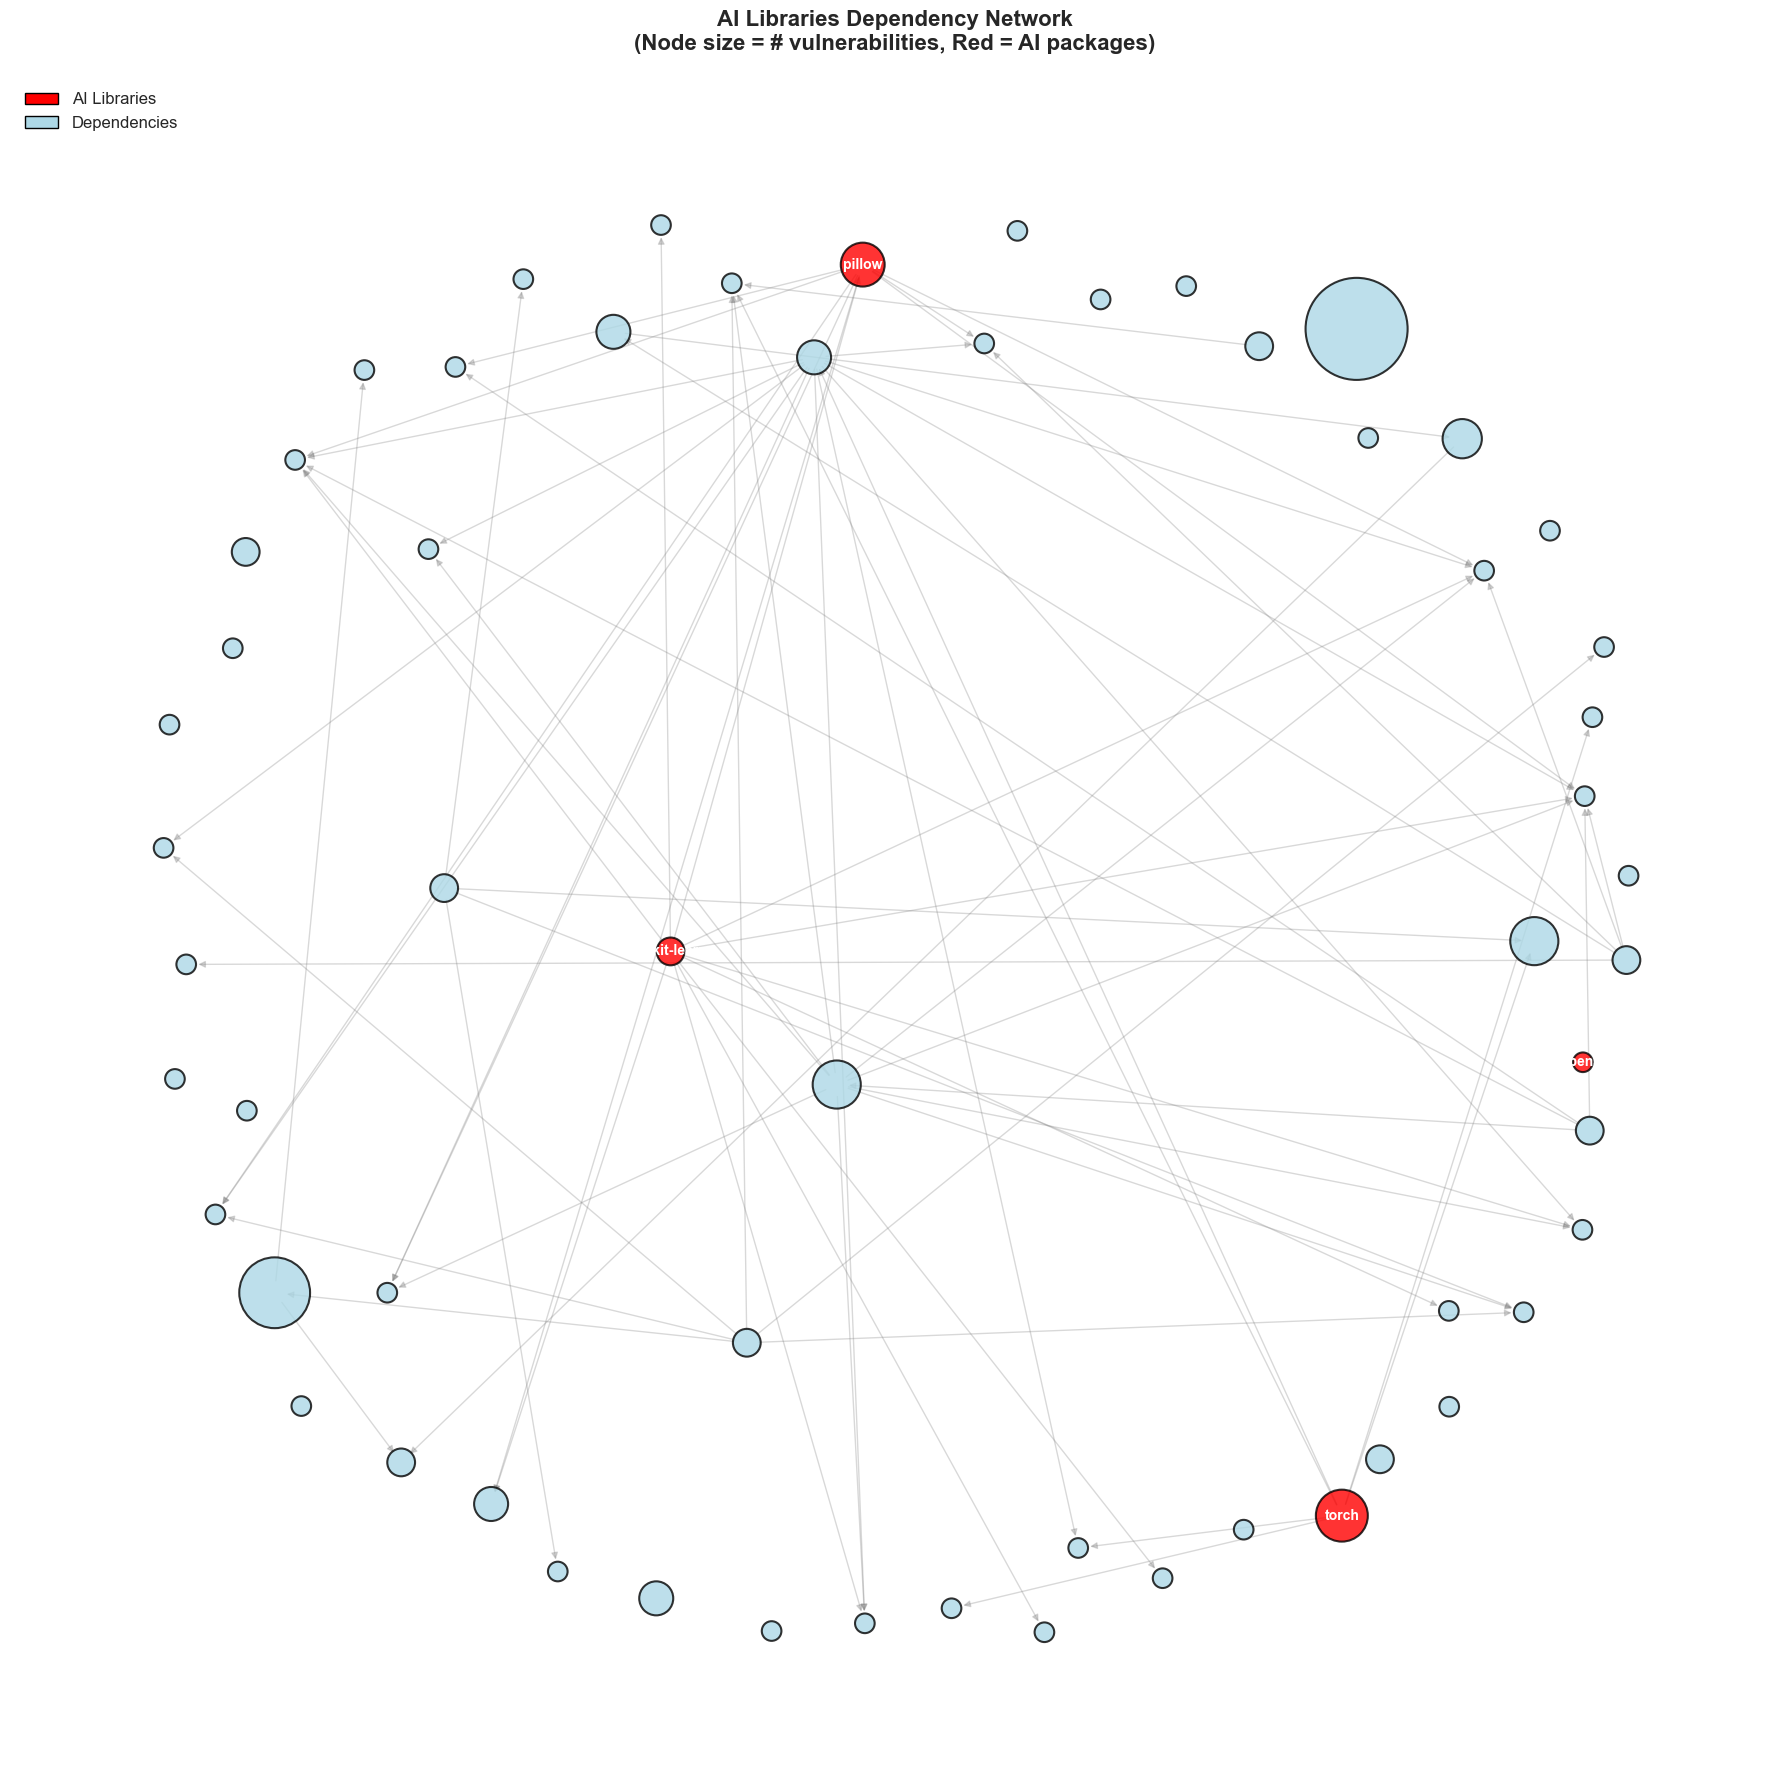

✅ Saved: outputs/plots/network_graph_ai.png


In [19]:
# Criar subgrafo apenas com bibliotecas de IA e suas dependências diretas
print('Criando visualização da rede de IA...')

# Pacotes AI que estão no grafo
ai_packages_in_graph = [pkg for pkg in AI_LIBS if pkg in G]

print(f'Pacotes AI no grafo: {len(ai_packages_in_graph)}')

# Adicionar dependências diretas e dependentes diretos
ai_extended = set(ai_packages_in_graph)
for pkg in ai_packages_in_graph:
    # Dependências (out-neighbors)
    ai_extended.update(G.successors(pkg))
    # Dependentes (in-neighbors)
    ai_extended.update(G.predecessors(pkg))

print(f'Com dependências diretas: {len(ai_extended)} nós')

# Limitar a top 60 para visualização
if len(ai_extended) > 100:
    # Pegar os mais importantes
    ai_metrics = metrics_df[metrics_df['package'].isin(ai_extended)]
    top_ai = ai_metrics.nlargest(60, 'in_degree')['package'].tolist()
    ai_extended = set(top_ai)

# Criar subgrafo
G_ai = G.subgraph(ai_extended).copy()

print(f'Subgrafo AI: {G_ai.number_of_nodes()} nós, {G_ai.number_of_edges()} arestas')

# Layout
print('Calculando layout...')
pos_ai = nx.spring_layout(G_ai, k=2, iterations=50, seed=42)

# Cores: AI vs Non-AI
node_colors_ai = ['red' if node in AI_LIBS else 'lightblue' for node in G_ai.nodes()]

# Tamanhos por vulnerabilidades
vuln_counts_ai = vulns_net.groupby('package_lower')['cve'].nunique().to_dict()
node_sizes_ai = [vuln_counts_ai.get(node, 0) * 200 + 200 for node in G_ai.nodes()]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(18, 18))

# Arestas
nx.draw_networkx_edges(
    G_ai, pos_ai,
    alpha=0.3,
    edge_color='gray',
    arrows=True,
    arrowsize=10,
    ax=ax
)

# Nós
nx.draw_networkx_nodes(
    G_ai, pos_ai,
    node_color=node_colors_ai,
    node_size=node_sizes_ai,
    alpha=0.8,
    edgecolors='black',
    linewidths=1.5,
    ax=ax
)

# Labels para pacotes AI
ai_labels = {node: node for node in G_ai.nodes() if node in AI_LIBS}
nx.draw_networkx_labels(
    G_ai, pos_ai,
    labels=ai_labels,
    font_size=10,
    font_weight='bold',
    font_color='white',
    ax=ax
)

# Legenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='AI Libraries'),
    Patch(facecolor='lightblue', edgecolor='black', label='Dependencies')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12)

ax.set_title('AI Libraries Dependency Network\n(Node size = # vulnerabilities, Red = AI packages)', 
             fontsize=16, fontweight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
plt.savefig('outputs/plots/network_graph_ai.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: outputs/plots/network_graph_ai.png')

In [17]:
# Estatísticas das duas redes
print('='*60)
print('COMPARAÇÃO DE REDES')
print('='*60)

print(f'\n🌐 REDE GERAL (Top 50):')
print(f'   Nós: {G_viz.number_of_nodes()}')
print(f'   Arestas: {G_viz.number_of_edges()}')
print(f'   Densidade: {nx.density(G_viz):.4f}')
print(f'   Grau médio: {np.mean([d for n, d in G_viz.degree()]):.2f}')

print(f'\n🤖 REDE DE IA:')
print(f'   Nós: {G_ai.number_of_nodes()}')
print(f'   Arestas: {G_ai.number_of_edges()}')
print(f'   Densidade: {nx.density(G_ai):.4f}')
print(f'   Grau médio: {np.mean([d for n, d in G_ai.degree()]):.2f}')
print(f'   Pacotes AI: {len([n for n in G_ai.nodes() if n in AI_LIBS])}')

print('\n' + '='*60)

COMPARAÇÃO DE REDES

🌐 REDE GERAL (Top 50):
   Nós: 50
   Arestas: 50
   Densidade: 0.0204
   Grau médio: 2.00

🤖 REDE DE IA:
   Nós: 60
   Arestas: 69
   Densidade: 0.0195
   Grau médio: 2.30
   Pacotes AI: 4



## 📊 5.6. In-Degree Distribution (Most Impactful Packages)

Calculando distribuição de in-degree...


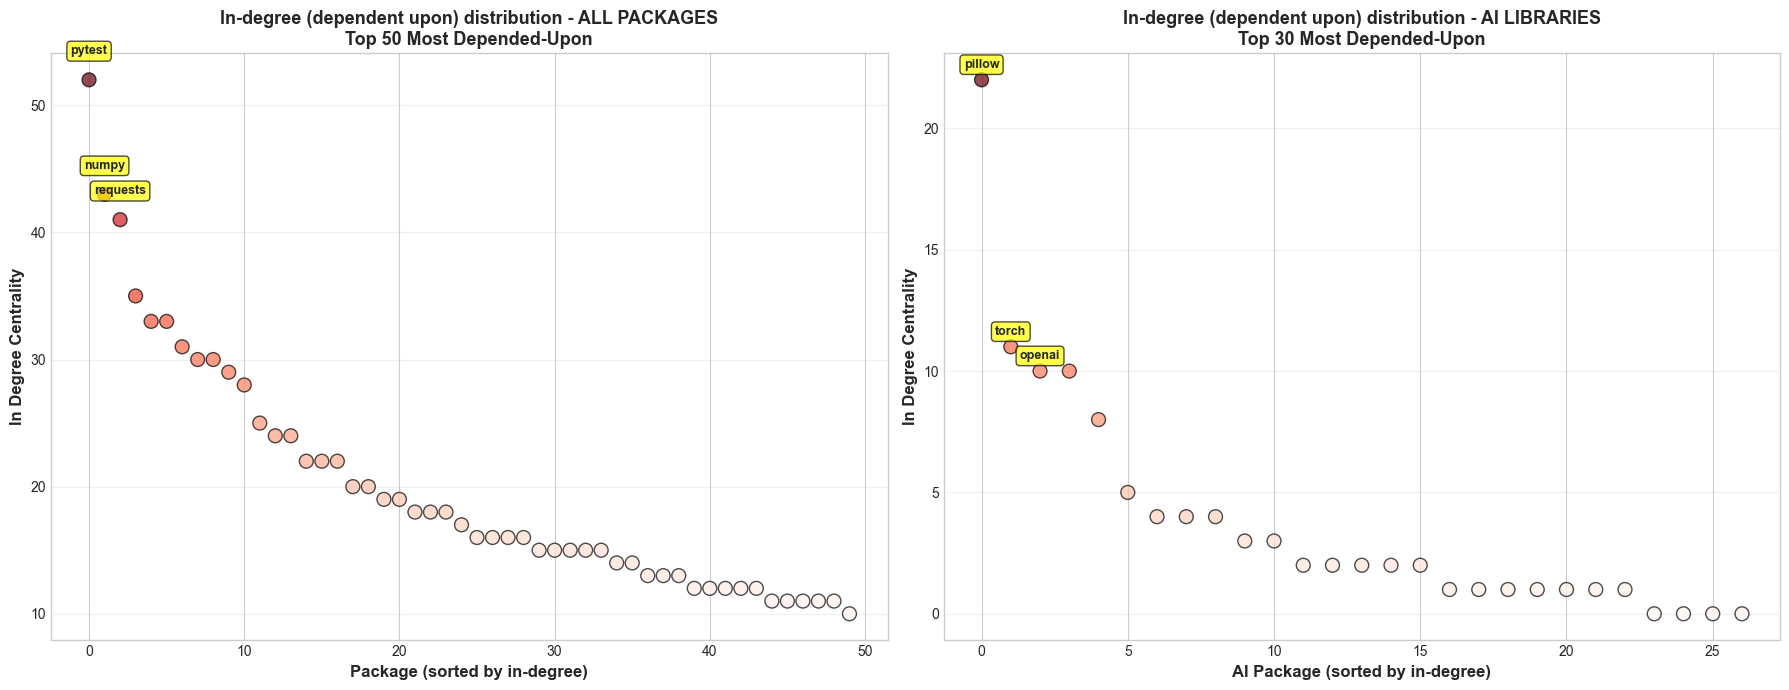

✅ Saved: outputs/plots/in_degree_distribution.png


In [20]:
# Which packages have the most impact in the dependency network?
print('Calculando distribuição de in-degree...')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# REDE GERAL
ax = ax1
in_degrees_sorted = metrics_df.sort_values('in_degree', ascending=False)
top_50 = in_degrees_sorted.head(50)

ax.scatter(range(len(top_50)), top_50['in_degree'], 
           c=top_50['in_degree'], cmap='Reds', s=100, alpha=0.7, edgecolors='black')
ax.set_xlabel('Package (sorted by in-degree)', fontsize=12, fontweight='bold')
ax.set_ylabel('In Degree Centrality', fontsize=12, fontweight='bold')
ax.set_title('In-degree (dependent upon) distribution - ALL PACKAGES\nTop 50 Most Depended-Upon', 
             fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Anotar top 3
for i, row in top_50.head(3).iterrows():
    idx = list(top_50.index).index(i)
    ax.annotate(row['package'], 
                xy=(idx, row['in_degree']),
                xytext=(idx, row['in_degree'] + 2),
                ha='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# REDE DE IA
ax = ax2
ai_metrics = metrics_df[metrics_df['is_ai_lib']].sort_values('in_degree', ascending=False)
top_ai = ai_metrics.head(30)

ax.scatter(range(len(top_ai)), top_ai['in_degree'], 
           c=top_ai['in_degree'], cmap='Reds', s=100, alpha=0.7, edgecolors='black')
ax.set_xlabel('AI Package (sorted by in-degree)', fontsize=12, fontweight='bold')
ax.set_ylabel('In Degree Centrality', fontsize=12, fontweight='bold')
ax.set_title('In-degree (dependent upon) distribution - AI LIBRARIES\nTop 30 Most Depended-Upon', 
             fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Anotar top 3 AI
for i, row in top_ai.head(3).iterrows():
    idx = list(top_ai.index).index(i)
    ax.annotate(row['package'], 
                xy=(idx, row['in_degree']),
                xytext=(idx, row['in_degree'] + 0.5),
                ha='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('outputs/plots/in_degree_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: outputs/plots/in_degree_distribution.png')

## 📊 5.9. In-degree impact curve (Who impacts the dependency network?)

Gerando curva de impacto (in-degree) para TODOS os pacotes...


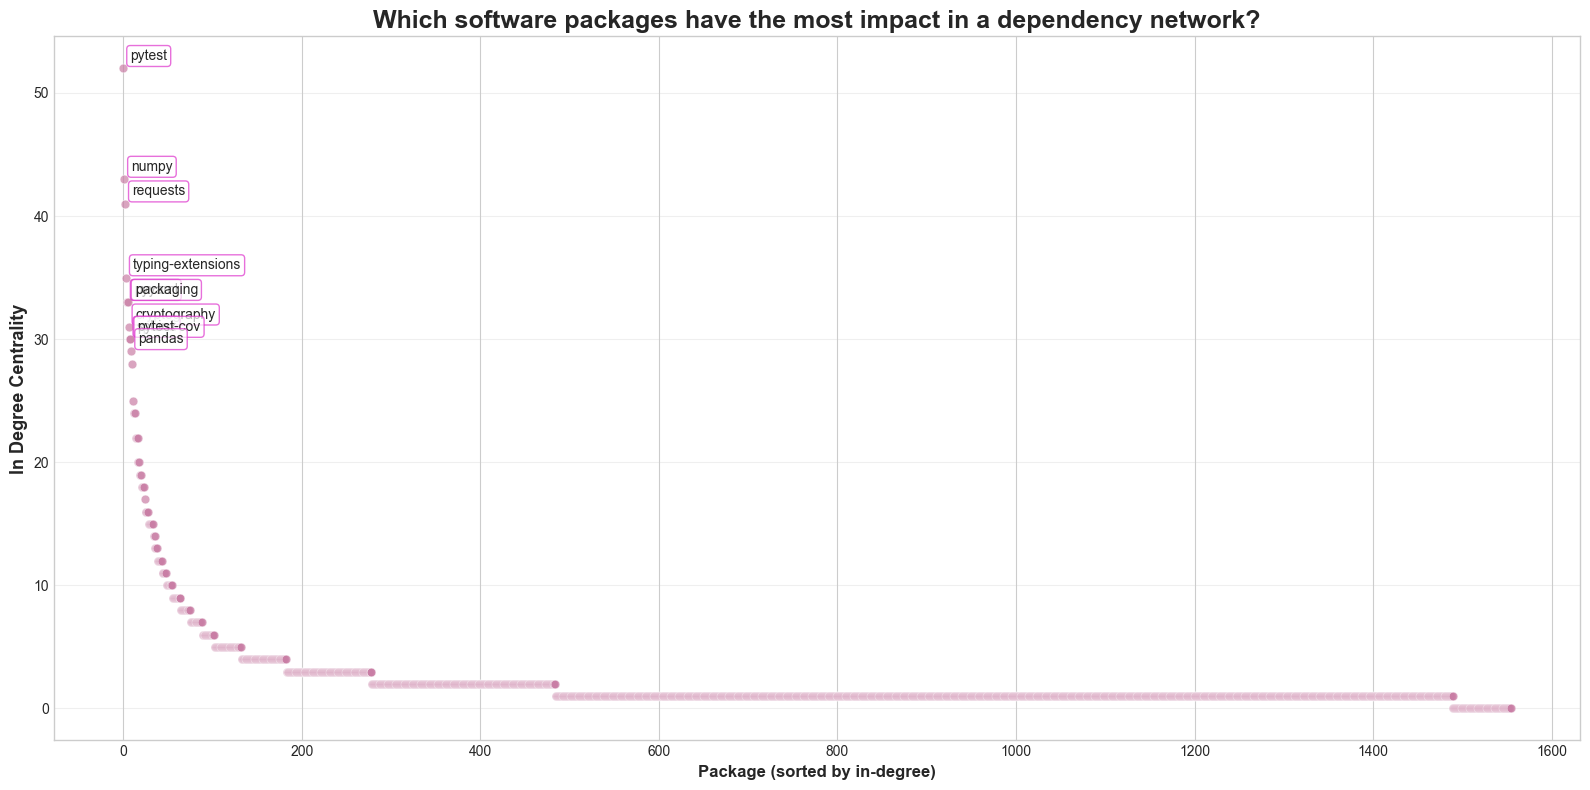

✅ Saved: outputs/plots/in_degree_impact_all.png
Gerando curva de impacto (in-degree) para pacotes de IA...


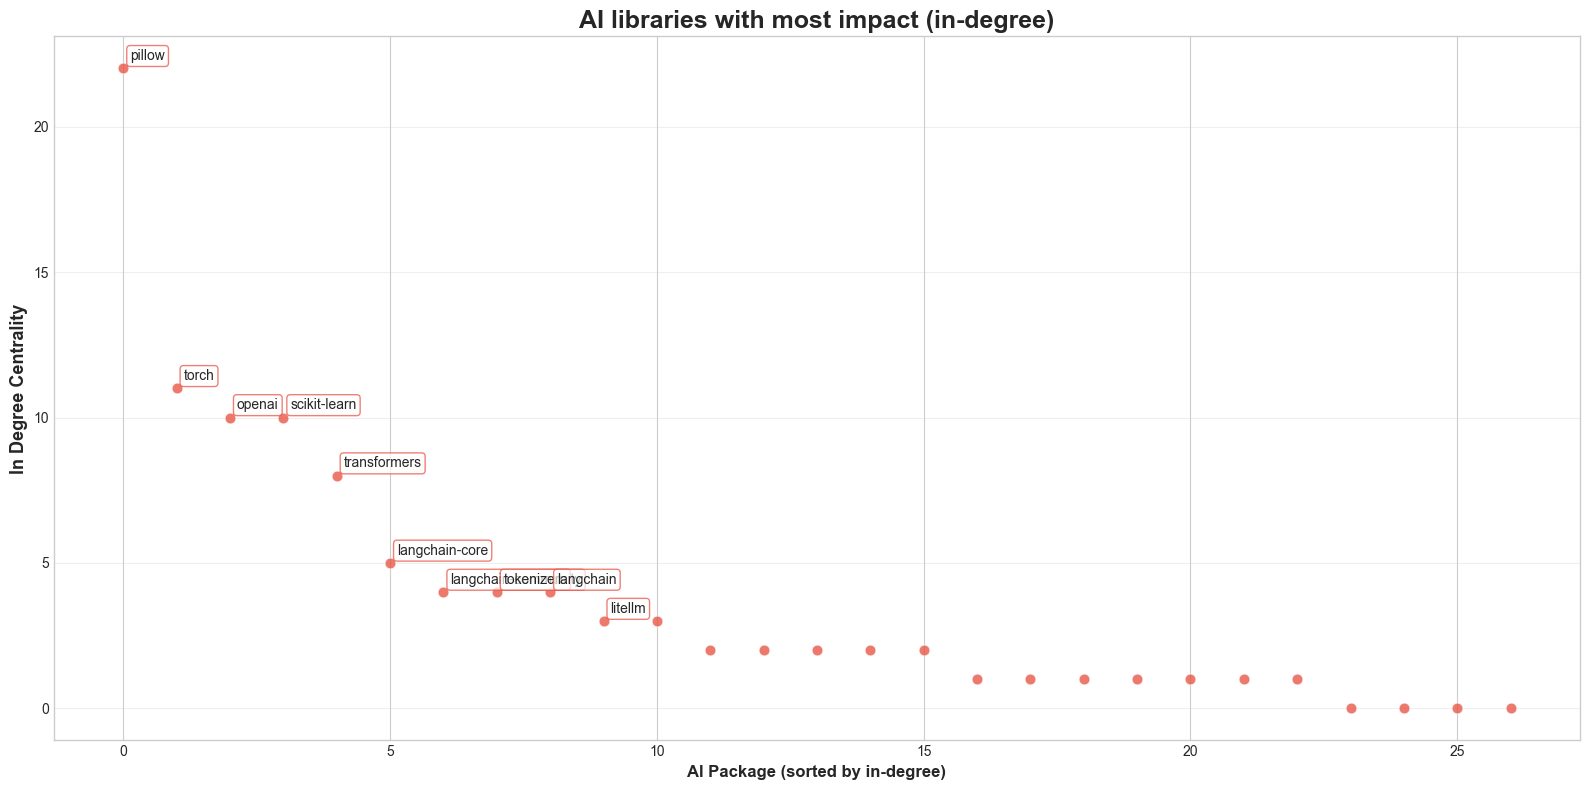

✅ Saved: outputs/plots/in_degree_impact_ai.png


In [38]:
# In-degree impact curve — ALL packages
print('Gerando curva de impacto (in-degree) para TODOS os pacotes...')

import matplotlib.pyplot as plt
import numpy as np

# Ordenar por in_degree desc
all_sorted = metrics_df.sort_values('in_degree', ascending=False).reset_index(drop=True)
xs = np.arange(len(all_sorted))
ys = all_sorted['in_degree'].fillna(0).values

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.scatter(xs, ys, s=40, c='#c97ea5', alpha=0.7, edgecolors='white', linewidths=0.5)

# Anotar top 10
for i, row in all_sorted.head(10).iterrows():
    ax.annotate(row['package'], (i, row['in_degree']), xytext=(5, 6), textcoords='offset points', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.7, edgecolor='#d3c'))

ax.set_title('Which software packages have the most impact in a dependency network?', fontsize=18, fontweight='bold')
ax.set_ylabel('In Degree Centrality', fontsize=13, fontweight='bold')
ax.set_xlabel('Package (sorted by in-degree)', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/plots/in_degree_impact_all.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: outputs/plots/in_degree_impact_all.png')

# In-degree impact curve — AI only
print('Gerando curva de impacto (in-degree) para pacotes de IA...')
ai_sorted = metrics_df[metrics_df['is_ai_lib']].sort_values('in_degree', ascending=False).reset_index(drop=True)
if len(ai_sorted) > 0:
    xs = np.arange(len(ai_sorted))
    ys = ai_sorted['in_degree'].fillna(0).values

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.scatter(xs, ys, s=60, c='#e74c3c', alpha=0.75, edgecolors='white', linewidths=0.6)

    for i, row in ai_sorted.head(10).iterrows():
        ax.annotate(row['package'], (i, row['in_degree']), xytext=(5, 6), textcoords='offset points', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.7, edgecolor='#e74c3c'))

    ax.set_title('AI libraries with most impact (in-degree)', fontsize=18, fontweight='bold')
    ax.set_ylabel('In Degree Centrality', fontsize=13, fontweight='bold')
    ax.set_xlabel('AI Package (sorted by in-degree)', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('outputs/plots/in_degree_impact_ai.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('✅ Saved: outputs/plots/in_degree_impact_ai.png')
else:
    print('⚠️ Não há pacotes de IA suficientes para o gráfico.')

## ⏱️ 8.5. Extended Survival Analysis (Time to Fix)

Preparando dados para KM: Time to fix since first affected...
Dados válidos: 143
Fixed: 143, Not fixed: 0


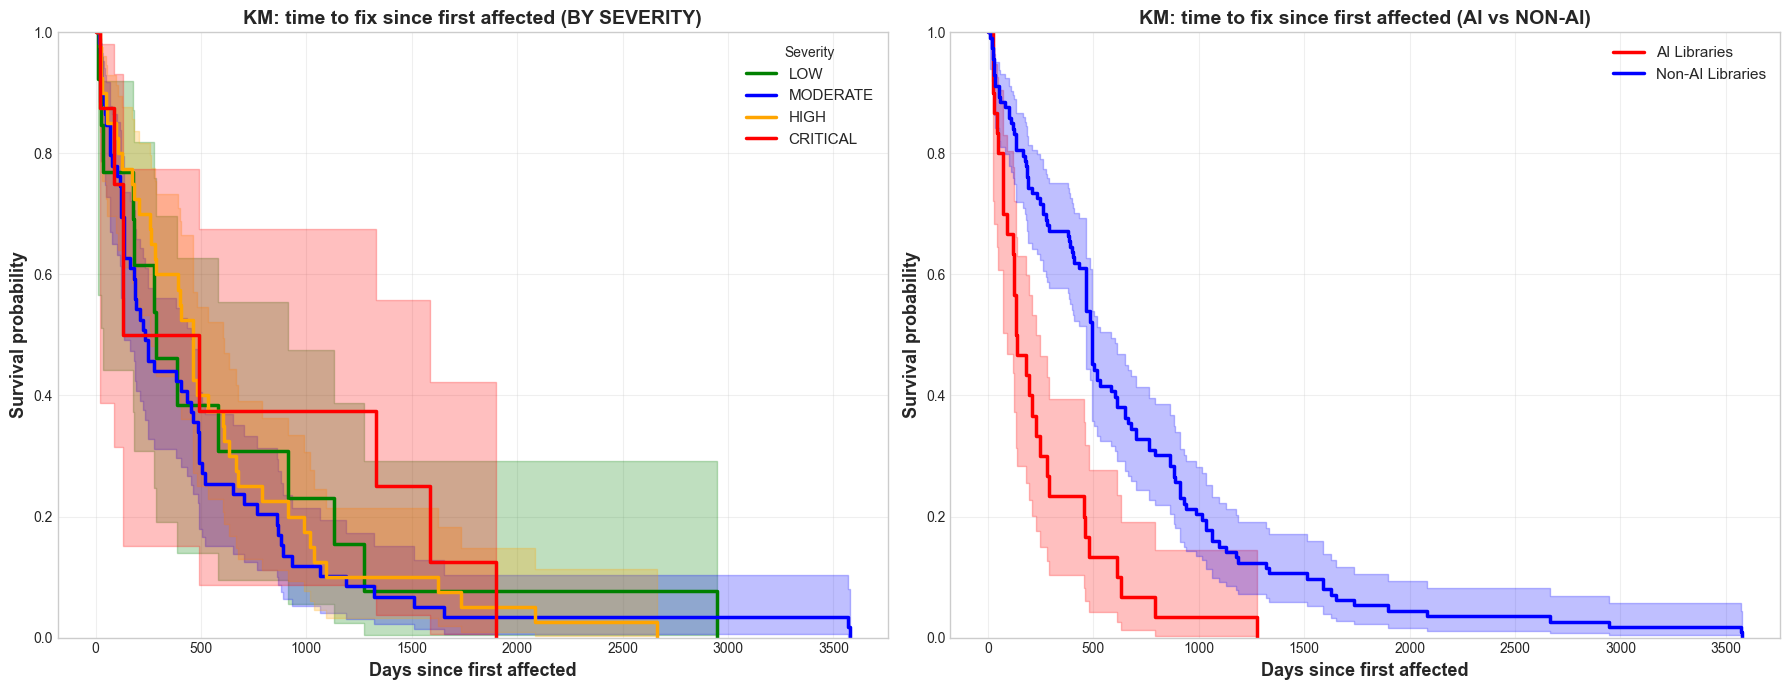

✅ Saved: outputs/plots/km_since_first.png


In [25]:
# KM: Time to fix since FIRST AFFECTED
print('Preparando dados para KM: Time to fix since first affected...')

vulns_km_first = vulns_net[
    vulns_net['time_to_fix_from_first_days'].notna() & 
    (vulns_net['time_to_fix_from_first_days'] >= 0)
].copy()

print(f'Dados válidos: {len(vulns_km_first)}')

if len(vulns_km_first) > 0:
    vulns_km_first['event'] = vulns_km_first['mitigation_date'].notna().astype(int)
    print(f'Fixed: {vulns_km_first["event"].sum()}, Not fixed: {(vulns_km_first["event"] == 0).sum()}')
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    kmf = KaplanMeierFitter()
    
    # Por severidade
    ax = axes[0]
    colors = {'low': 'green', 'moderate': 'blue', 'high': 'orange', 'critical': 'red'}
    
    for severity in ['low', 'moderate', 'high', 'critical']:
        mask = vulns_km_first['severity'].str.lower() == severity
        if mask.sum() > 0:
            try:
                kmf.fit(
                    durations=vulns_km_first[mask]['time_to_fix_from_first_days'],
                    event_observed=vulns_km_first[mask]['event'],
                    label=severity.upper()
                )
                kmf.plot_survival_function(ax=ax, ci_show=True, color=colors.get(severity, 'gray'), linewidth=2.5)
            except Exception as e:
                print(f'Erro {severity}: {e}')
    
    ax.set_xlabel('Days since first affected', fontsize=13, fontweight='bold')
    ax.set_ylabel('Survival probability', fontsize=13, fontweight='bold')
    ax.set_title('KM: time to fix since first affected (BY SEVERITY)', fontsize=14, fontweight='bold')
    ax.legend(title='Severity', fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_ylim([0, 1])
    
    # AI vs Non-AI
    ax = axes[1]
    for is_ai, label, color in [(True, 'AI Libraries', 'red'), (False, 'Non-AI Libraries', 'blue')]:
        mask = vulns_km_first['is_ai_lib'] == is_ai
        if mask.sum() > 0:
            try:
                kmf.fit(
                    durations=vulns_km_first[mask]['time_to_fix_from_first_days'],
                    event_observed=vulns_km_first[mask]['event'],
                    label=label
                )
                kmf.plot_survival_function(ax=ax, ci_show=True, color=color, linewidth=2.5)
            except Exception as e:
                print(f'Erro {label}: {e}')
    
    ax.set_xlabel('Days since first affected', fontsize=13, fontweight='bold')
    ax.set_ylabel('Survival probability', fontsize=13, fontweight='bold')
    ax.set_title('KM: time to fix since first affected (AI vs NON-AI)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('outputs/plots/km_since_first.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('✅ Saved: outputs/plots/km_since_first.png')
else:
    print('⚠️  Não há dados suficientes')

Preparando dados para KM: Time to fix since disclosure...
Dados válidos: 137
Fixed: 137, Not fixed: 0


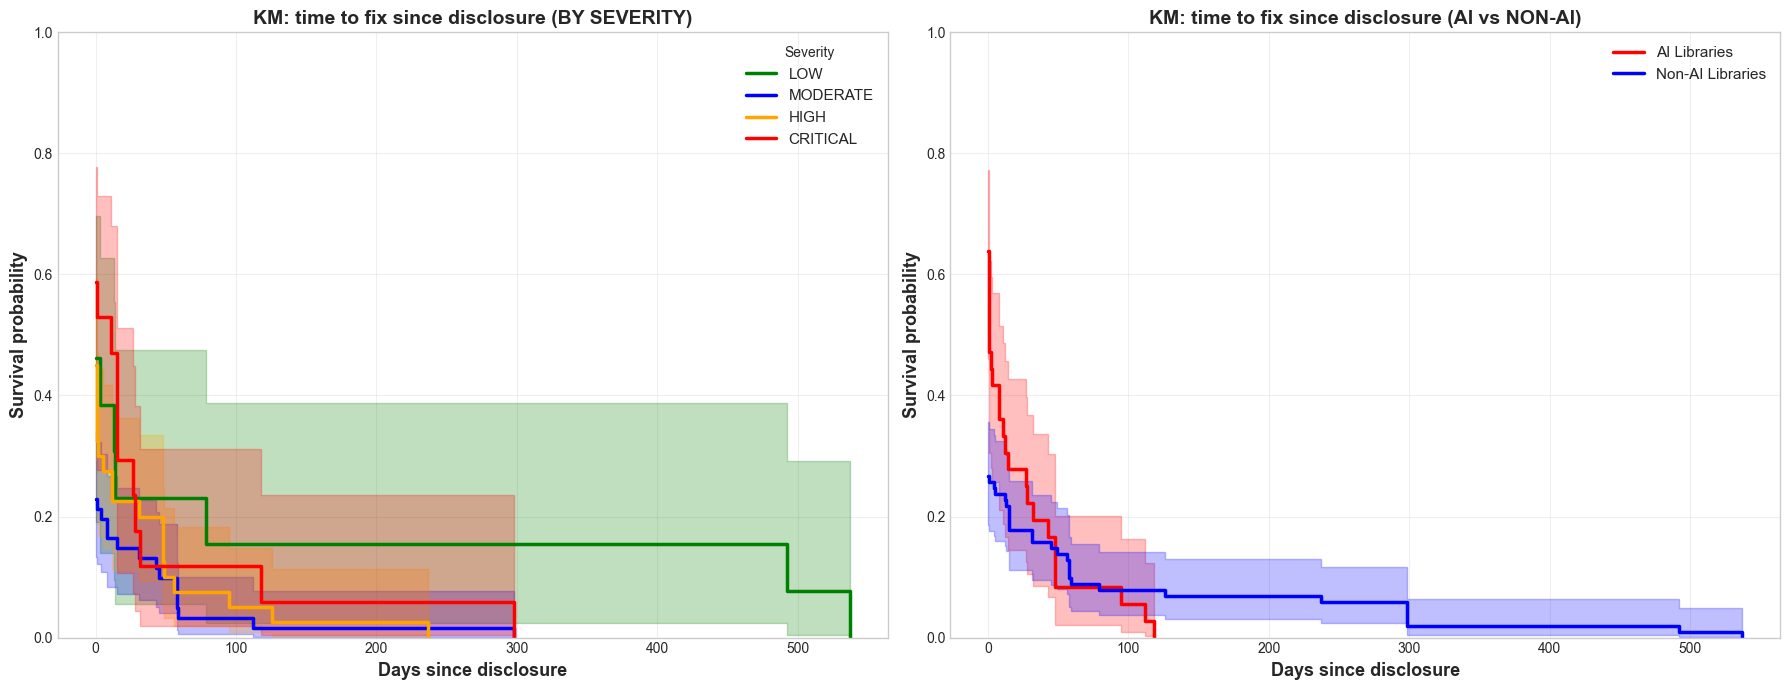

✅ Saved: outputs/plots/km_since_disclosure.png


In [26]:
# KM: Time to fix since DISCLOSURE
print('Preparando dados para KM: Time to fix since disclosure...')

vulns_km_disc = vulns_net[
    vulns_net['time_to_fix_from_disclosure_days'].notna() & 
    (vulns_net['time_to_fix_from_disclosure_days'] >= 0)
].copy()

print(f'Dados válidos: {len(vulns_km_disc)}')

if len(vulns_km_disc) > 0:
    vulns_km_disc['event'] = vulns_km_disc['mitigation_date'].notna().astype(int)
    print(f'Fixed: {vulns_km_disc["event"].sum()}, Not fixed: {(vulns_km_disc["event"] == 0).sum()}')
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    kmf = KaplanMeierFitter()
    
    # Por severidade
    ax = axes[0]
    colors = {'low': 'green', 'moderate': 'blue', 'high': 'orange', 'critical': 'red'}
    
    for severity in ['low', 'moderate', 'high', 'critical']:
        mask = vulns_km_disc['severity'].str.lower() == severity
        if mask.sum() > 0:
            try:
                kmf.fit(
                    durations=vulns_km_disc[mask]['time_to_fix_from_disclosure_days'],
                    event_observed=vulns_km_disc[mask]['event'],
                    label=severity.upper()
                )
                kmf.plot_survival_function(ax=ax, ci_show=True, color=colors.get(severity, 'gray'), linewidth=2.5)
            except Exception as e:
                print(f'Erro {severity}: {e}')
    
    ax.set_xlabel('Days since disclosure', fontsize=13, fontweight='bold')
    ax.set_ylabel('Survival probability', fontsize=13, fontweight='bold')
    ax.set_title('KM: time to fix since disclosure (BY SEVERITY)', fontsize=14, fontweight='bold')
    ax.legend(title='Severity', fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_ylim([0, 1])
    
    # AI vs Non-AI
    ax = axes[1]
    for is_ai, label, color in [(True, 'AI Libraries', 'red'), (False, 'Non-AI Libraries', 'blue')]:
        mask = vulns_km_disc['is_ai_lib'] == is_ai
        if mask.sum() > 0:
            try:
                kmf.fit(
                    durations=vulns_km_disc[mask]['time_to_fix_from_disclosure_days'],
                    event_observed=vulns_km_disc[mask]['event'],
                    label=label
                )
                kmf.plot_survival_function(ax=ax, ci_show=True, color=color, linewidth=2.5)
            except Exception as e:
                print(f'Erro {label}: {e}')
    
    ax.set_xlabel('Days since disclosure', fontsize=13, fontweight='bold')
    ax.set_ylabel('Survival probability', fontsize=13, fontweight='bold')
    ax.set_title('KM: time to fix since disclosure (AI vs NON-AI)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('outputs/plots/km_since_disclosure.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('✅ Saved: outputs/plots/km_since_disclosure.png')
else:
    print('⚠️  Não há dados suficientes')

In [27]:
# Estatísticas de Time-to-Fix
print('='*70)
print('TIME-TO-FIX STATISTICS')
print('='*70)

print('\n📊 SINCE FIRST AFFECTED:')
if len(vulns_km_first) > 0:
    print(f'   Median: {vulns_km_first["time_to_fix_from_first_days"].median():.1f} days')
    print(f'   Mean: {vulns_km_first["time_to_fix_from_first_days"].mean():.1f} days')
    print(f'\n   By severity:')
    for sev in ['low', 'moderate', 'high', 'critical']:
        data = vulns_km_first[vulns_km_first['severity'].str.lower() == sev]['time_to_fix_from_first_days']
        if len(data) > 0:
            print(f'      {sev.upper()}: median={data.median():.1f}, mean={data.mean():.1f}')
    print(f'\n   AI vs Non-AI:')
    ai = vulns_km_first[vulns_km_first['is_ai_lib']]['time_to_fix_from_first_days']
    non_ai = vulns_km_first[~vulns_km_first['is_ai_lib']]['time_to_fix_from_first_days']
    print(f'      AI: median={ai.median():.1f}, mean={ai.mean():.1f}')
    print(f'      Non-AI: median={non_ai.median():.1f}, mean={non_ai.mean():.1f}')

print('\n📊 SINCE DISCLOSURE:')
if len(vulns_km_disc) > 0:
    print(f'   Median: {vulns_km_disc["time_to_fix_from_disclosure_days"].median():.1f} days')
    print(f'   Mean: {vulns_km_disc["time_to_fix_from_disclosure_days"].mean():.1f} days')
    print(f'\n   By severity:')
    for sev in ['low', 'moderate', 'high', 'critical']:
        data = vulns_km_disc[vulns_km_disc['severity'].str.lower() == sev]['time_to_fix_from_disclosure_days']
        if len(data) > 0:
            print(f'      {sev.upper()}: median={data.median():.1f}, mean={data.mean():.1f}')
    print(f'\n   AI vs Non-AI:')
    ai = vulns_km_disc[vulns_km_disc['is_ai_lib']]['time_to_fix_from_disclosure_days']
    non_ai = vulns_km_disc[~vulns_km_disc['is_ai_lib']]['time_to_fix_from_disclosure_days']
    print(f'      AI: median={ai.median():.1f}, mean={ai.mean():.1f}')
    print(f'      Non-AI: median={non_ai.median():.1f}, mean={non_ai.mean():.1f}')

print('\n' + '='*70)

TIME-TO-FIX STATISTICS

📊 SINCE FIRST AFFECTED:
   Median: 463.0 days
   Mean: 583.6 days

   By severity:
      LOW: median=287.0, mean=633.1
      MODERATE: median=234.0, mean=501.8
      HIGH: median=462.5, mean=584.8
      CRITICAL: median=311.0, mean=710.2

   AI vs Non-AI:
      AI: median=134.0, mean=252.7
      Non-AI: median=491.0, mean=671.5

📊 SINCE DISCLOSURE:
   Median: 0.0 days
   Mean: 28.2 days

   By severity:
      LOW: median=0.0, mean=87.5
      MODERATE: median=0.0, mean=13.1
      HIGH: median=0.0, mean=19.4
      CRITICAL: median=11.0, mean=32.9

   AI vs Non-AI:
      AI: median=1.0, mean=18.4
      Non-AI: median=0.0, mean=31.7



## ⏱️ 8.6. AI-only Survival (by severity)

AI-only KM (since first affected) por severidade...


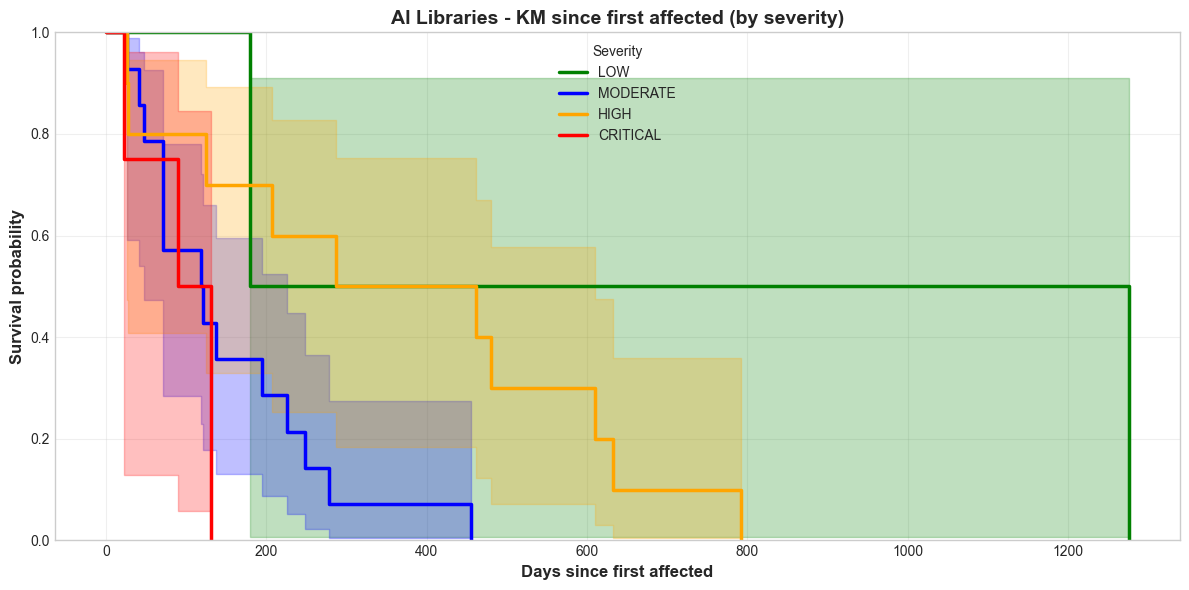

✅ Saved: outputs/plots/km_ai_since_first.png


In [36]:
# AI-only KM: since FIRST AFFECTED (by severity)
print('AI-only KM (since first affected) por severidade...')

ai_first = vulns_net[
    vulns_net['is_ai_lib'] &
    vulns_net['time_to_fix_from_first_days'].notna() &
    (vulns_net['time_to_fix_from_first_days'] >= 0)
].copy()

if len(ai_first) > 0:
    ai_first['event'] = ai_first['mitigation_date'].notna().astype(int)
    kmf = KaplanMeierFitter()
    colors = {'low': 'green', 'moderate': 'blue', 'high': 'orange', 'critical': 'red'}

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    for severity in ['low', 'moderate', 'high', 'critical']:
        mask = ai_first['severity'].str.lower() == severity
        if mask.sum() > 0:
            kmf.fit(ai_first[mask]['time_to_fix_from_first_days'], ai_first[mask]['event'], label=severity.upper())
            kmf.plot_survival_function(ax=ax, ci_show=True, color=colors.get(severity, 'gray'), linewidth=2.5)

    ax.set_xlabel('Days since first affected', fontsize=12, fontweight='bold')
    ax.set_ylabel('Survival probability', fontsize=12, fontweight='bold')
    ax.set_title('AI Libraries - KM since first affected (by severity)', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(alpha=0.3)
    ax.legend(title='Severity')
    plt.tight_layout()
    plt.savefig('outputs/plots/km_ai_since_first.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('✅ Saved: outputs/plots/km_ai_since_first.png')
else:
    print('⚠️ Sem dados suficientes para AI since first affected')

AI-only KM (since disclosure) por severidade...


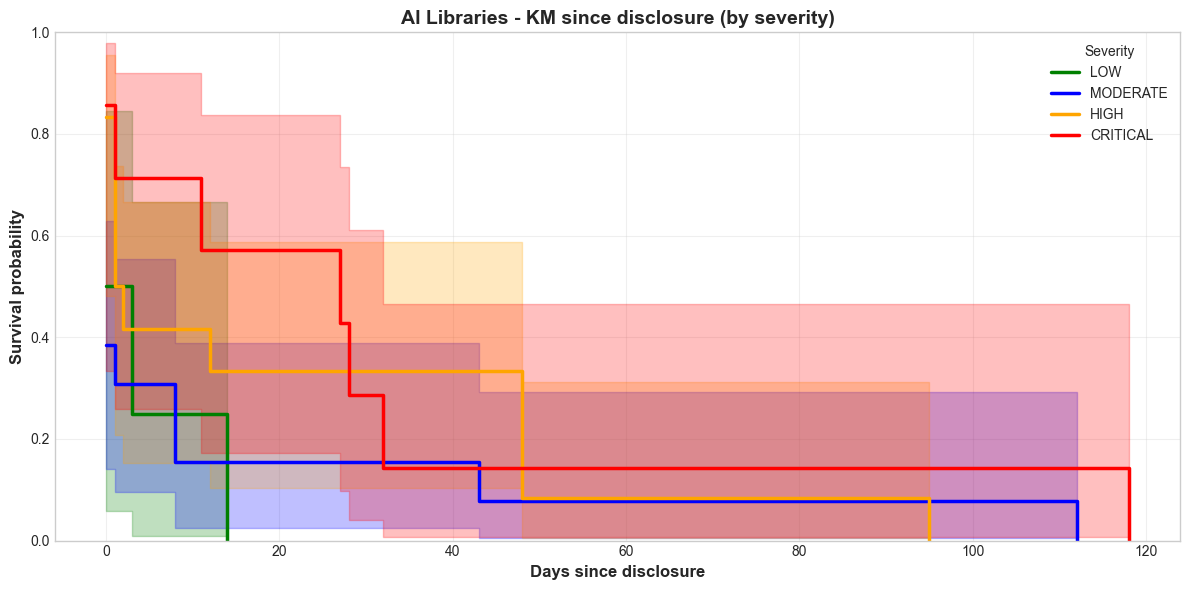

✅ Saved: outputs/plots/km_ai_since_disclosure.png


In [37]:
# AI-only KM: since DISCLOSURE (by severity)
print('AI-only KM (since disclosure) por severidade...')

ai_disc = vulns_net[
    vulns_net['is_ai_lib'] &
    vulns_net['time_to_fix_from_disclosure_days'].notna() &
    (vulns_net['time_to_fix_from_disclosure_days'] >= 0)
].copy()

if len(ai_disc) > 0:
    ai_disc['event'] = ai_disc['mitigation_date'].notna().astype(int)
    kmf = KaplanMeierFitter()
    colors = {'low': 'green', 'moderate': 'blue', 'high': 'orange', 'critical': 'red'}

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    for severity in ['low', 'moderate', 'high', 'critical']:
        mask = ai_disc['severity'].str.lower() == severity
        if mask.sum() > 0:
            kmf.fit(ai_disc[mask]['time_to_fix_from_disclosure_days'], ai_disc[mask]['event'], label=severity.upper())
            kmf.plot_survival_function(ax=ax, ci_show=True, color=colors.get(severity, 'gray'), linewidth=2.5)

    ax.set_xlabel('Days since disclosure', fontsize=12, fontweight='bold')
    ax.set_ylabel('Survival probability', fontsize=12, fontweight='bold')
    ax.set_title('AI Libraries - KM since disclosure (by severity)', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(alpha=0.3)
    ax.legend(title='Severity')
    plt.tight_layout()
    plt.savefig('outputs/plots/km_ai_since_disclosure.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('✅ Saved: outputs/plots/km_ai_since_disclosure.png')
else:
    print('⚠️ Sem dados suficientes para AI since disclosure')

## 🎯 5.7. Centrality Analysis (Single Point of Failure)

Analisando centralidade (pontos únicos de falha)...


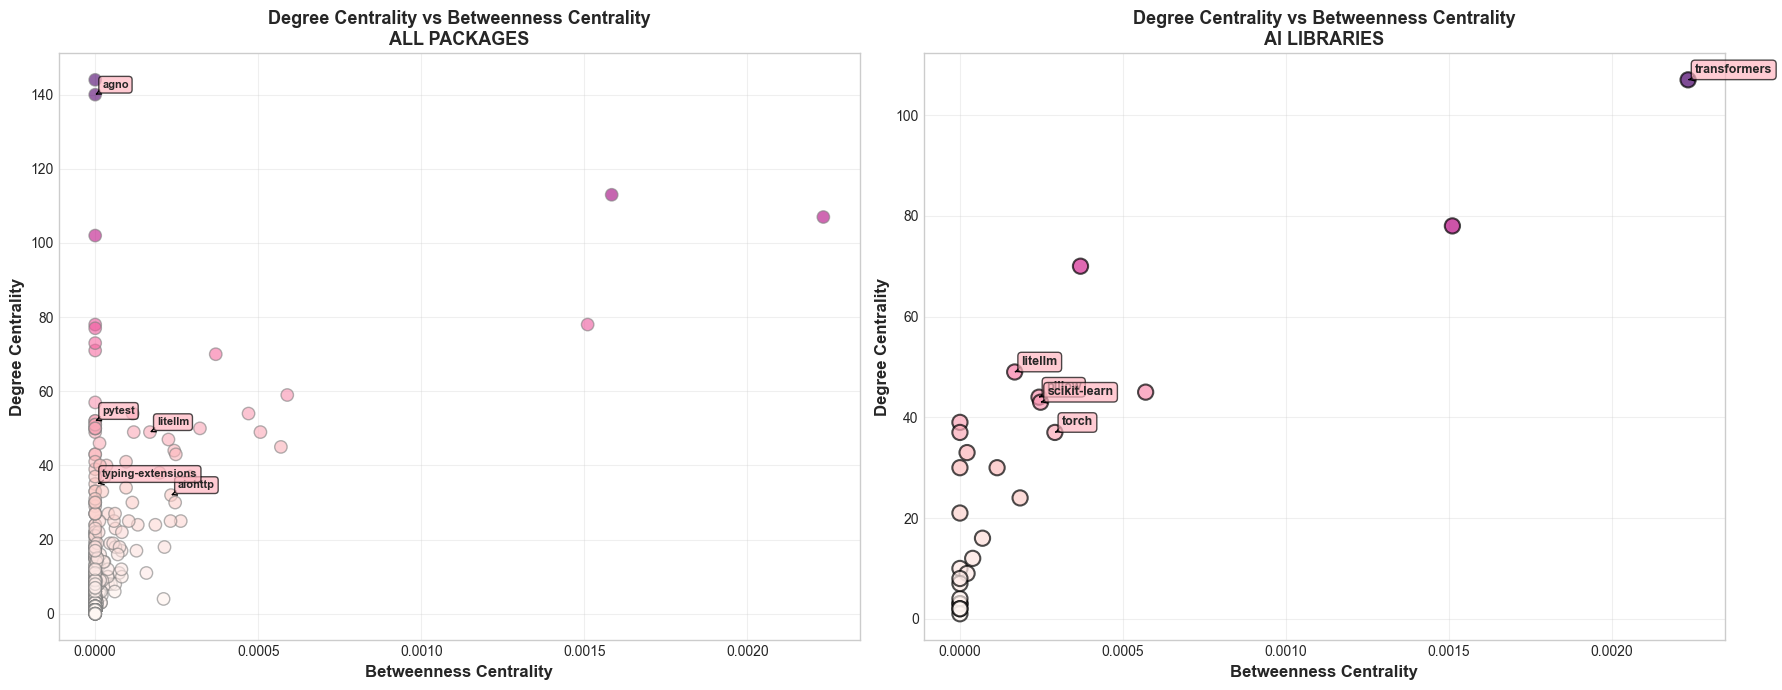

✅ Saved: outputs/plots/centrality_analysis.png


In [21]:
# Which packages have the most chance of being a single point of failure?
print('Analisando centralidade (pontos únicos de falha)...')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# REDE GERAL
ax = ax1
ax.scatter(metrics_df['betweenness'], metrics_df['degree'], 
           c=metrics_df['degree'], cmap='RdPu', s=80, alpha=0.6, edgecolors='gray')
ax.set_xlabel('Betweenness Centrality', fontsize=12, fontweight='bold')
ax.set_ylabel('Degree Centrality', fontsize=12, fontweight='bold')
ax.set_title('Degree Centrality vs Betweenness Centrality\nALL PACKAGES', 
             fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

# Anotar pacotes críticos (alto betweenness E alto degree)
critical = metrics_df[(metrics_df['betweenness'] > metrics_df['betweenness'].quantile(0.95)) | 
                      (metrics_df['degree'] > metrics_df['degree'].quantile(0.95))]
for _, row in critical.head(5).iterrows():
    ax.annotate(row['package'], 
                xy=(row['betweenness'], row['degree']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightpink', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# REDE DE IA
ax = ax2
ai_metrics_plot = metrics_df[metrics_df['is_ai_lib']]
ax.scatter(ai_metrics_plot['betweenness'], ai_metrics_plot['degree'], 
           c=ai_metrics_plot['degree'], cmap='RdPu', s=120, alpha=0.7, edgecolors='black', linewidths=1.5)
ax.set_xlabel('Betweenness Centrality', fontsize=12, fontweight='bold')
ax.set_ylabel('Degree Centrality', fontsize=12, fontweight='bold')
ax.set_title('Degree Centrality vs Betweenness Centrality\nAI LIBRARIES', 
             fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

# Anotar AI packages críticos
ai_critical = ai_metrics_plot[(ai_metrics_plot['betweenness'] > ai_metrics_plot['betweenness'].quantile(0.8)) | 
                               (ai_metrics_plot['degree'] > ai_metrics_plot['degree'].quantile(0.8))]
for _, row in ai_critical.head(5).iterrows():
    ax.annotate(row['package'], 
                xy=(row['betweenness'], row['degree']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightpink', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.savefig('outputs/plots/centrality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: outputs/plots/centrality_analysis.png')

## 🎨 5.8. Network with Community Detection (Clusters)

Detectando comunidades na rede geral...
Comunidades detectadas: 27
  Cluster 1: 18 nós
  Cluster 2: 15 nós
  Cluster 3: 12 nós
  Cluster 4: 10 nós
  Cluster 5: 10 nós


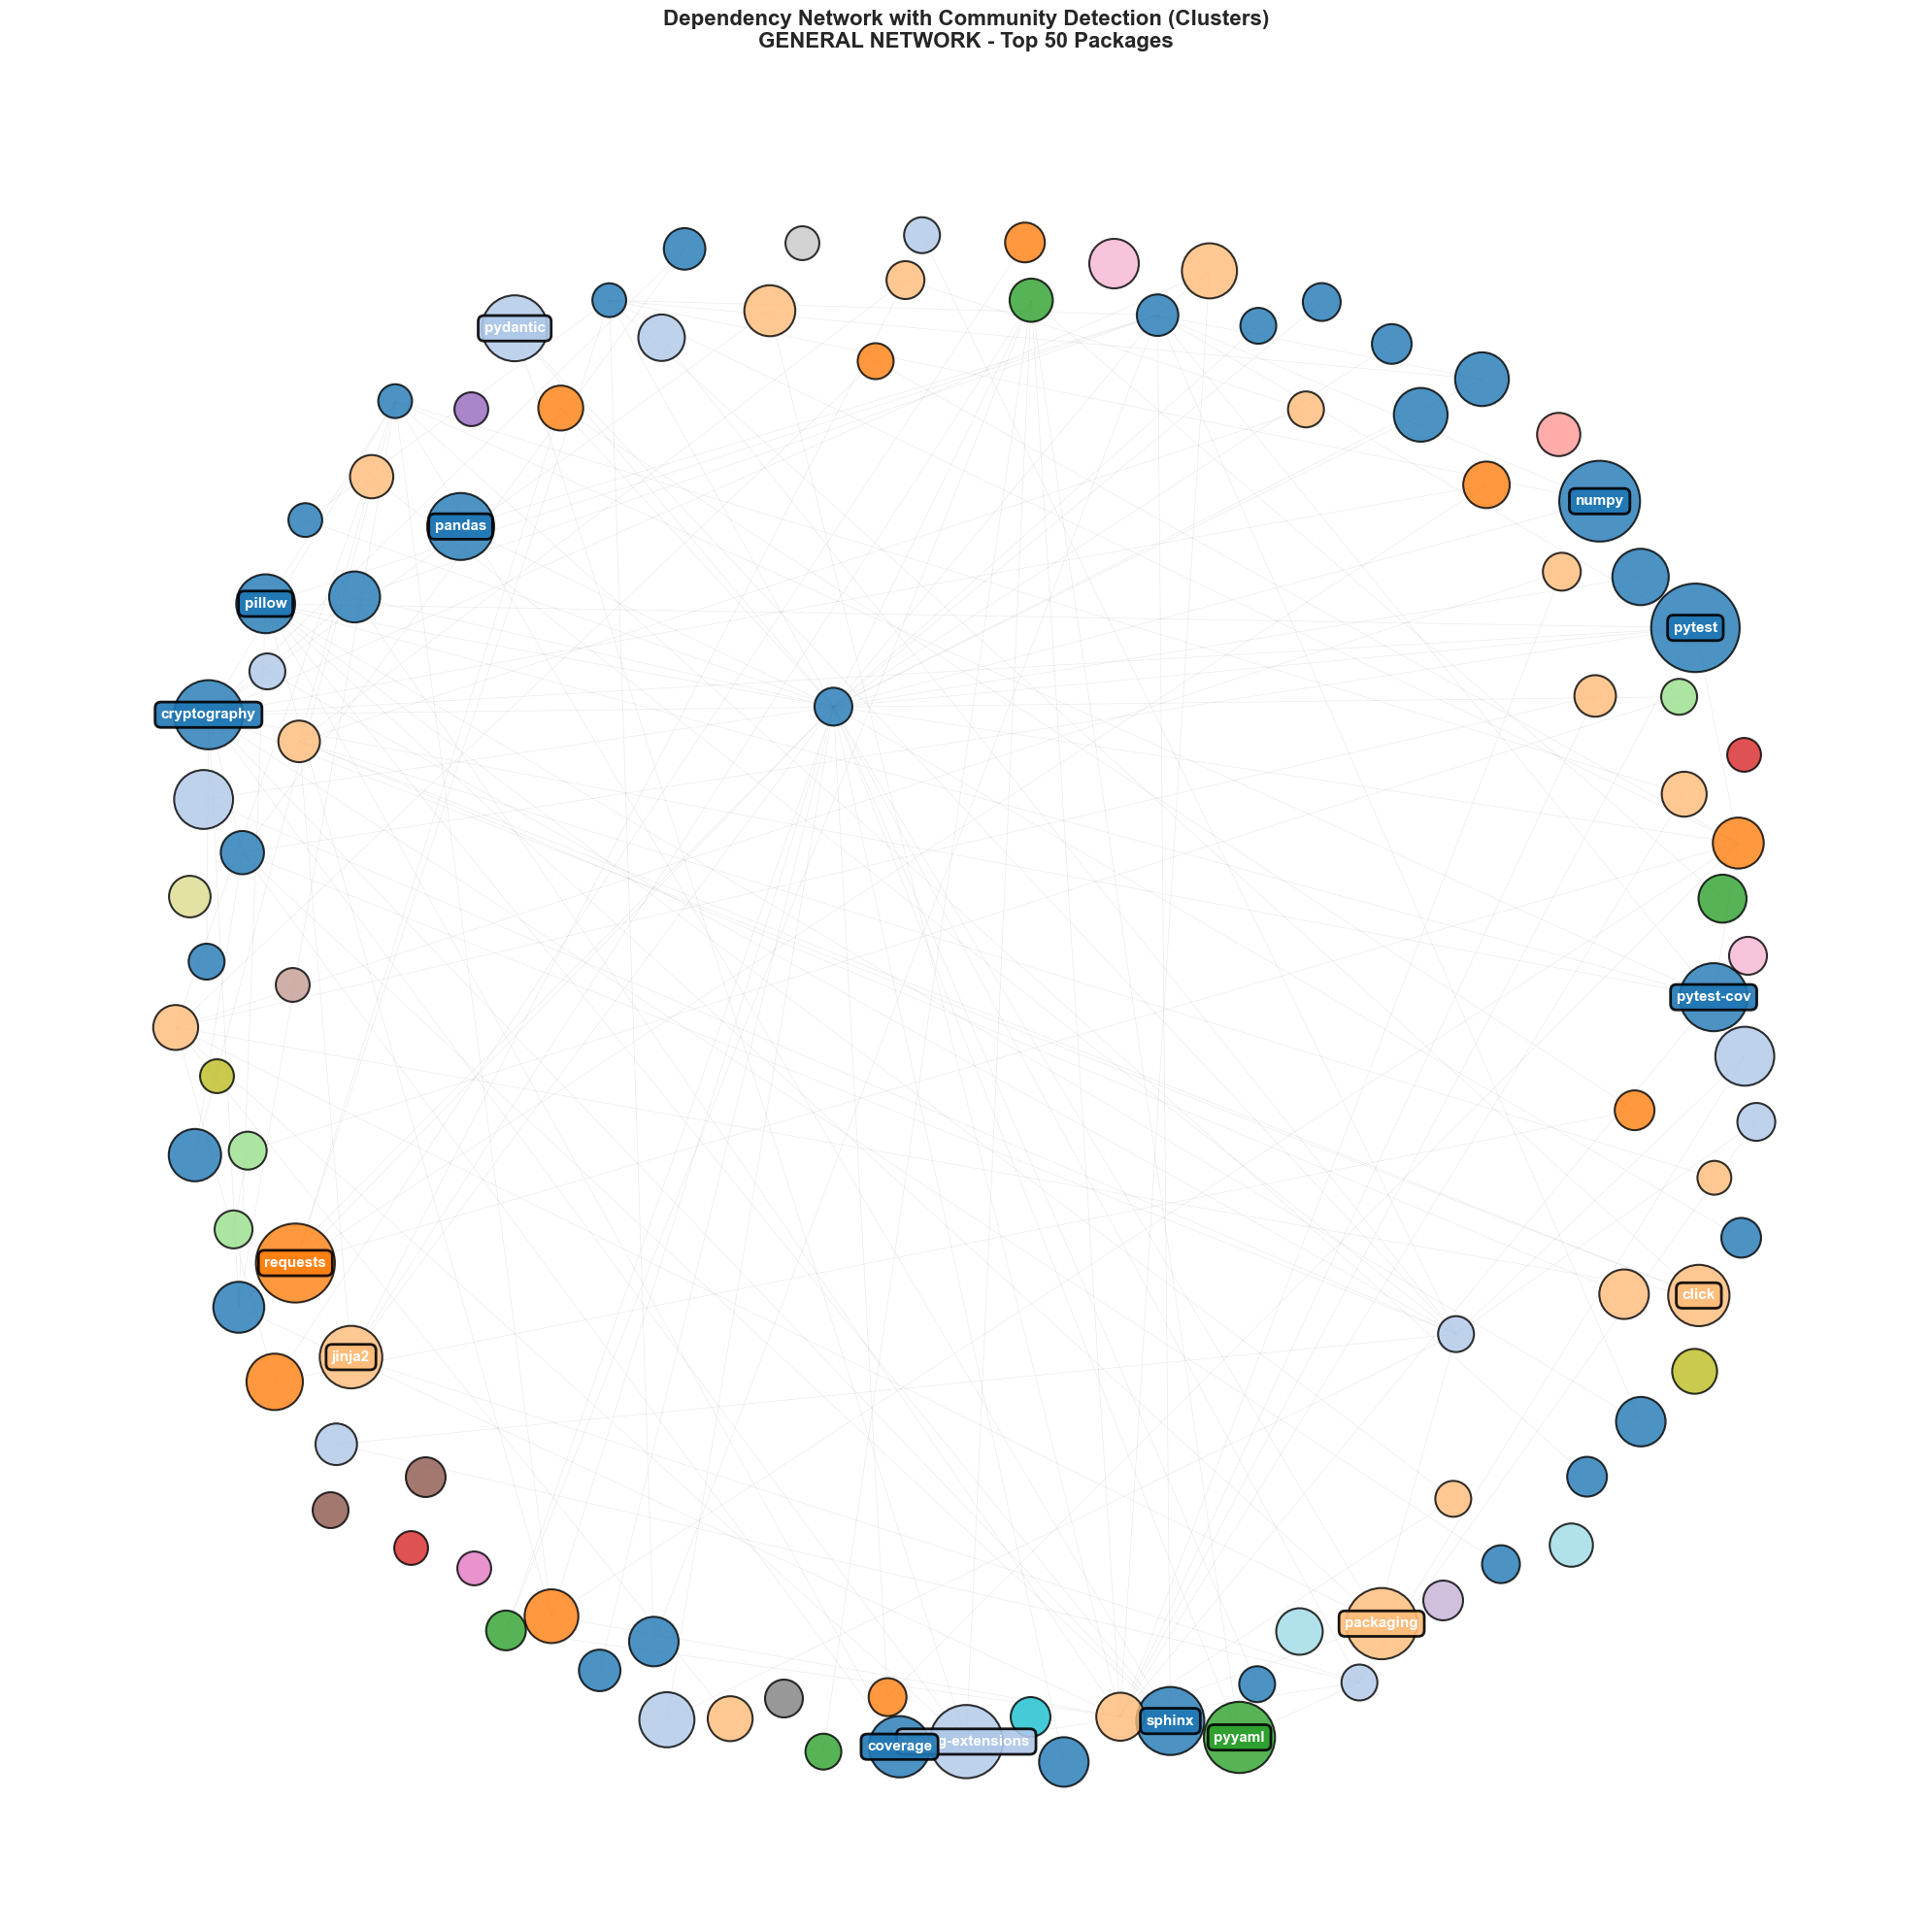

✅ Saved: outputs/plots/network_clusters_general.png


In [22]:
# Detectar comunidades (clusters) na rede GERAL
print('Detectando comunidades na rede geral...')

from networkx.algorithms import community

# Usar subgrafo não direcionado para detecção de comunidades
G_viz_undirected = G_viz.to_undirected()

# Detectar comunidades usando Louvain
communities = community.greedy_modularity_communities(G_viz_undirected)

print(f'Comunidades detectadas: {len(communities)}')
for i, comm in enumerate(communities[:5]):
    print(f'  Cluster {i+1}: {len(comm)} nós')

# Criar dicionário node -> community
node_to_community = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_community[node] = i

# Cores para clusters (palette distinta)
num_communities = len(communities)
colors = plt.cm.tab20(np.linspace(0, 1, num_communities))
community_colors = {i: colors[i] for i in range(num_communities)}

# Plot REDE GERAL com clusters
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Layout
pos = nx.spring_layout(G_viz_undirected, k=3, iterations=50, seed=42)

# Desenhar arestas
nx.draw_networkx_edges(
    G_viz_undirected, pos,
    alpha=0.15,
    edge_color='gray',
    width=0.5,
    ax=ax
)

# Desenhar nós por comunidade
for comm_id in range(num_communities):
    nodes_in_comm = [n for n in G_viz_undirected.nodes() if node_to_community.get(n) == comm_id]
    if not nodes_in_comm:
        continue
    
    # Tamanho baseado em in_degree
    node_sizes = [in_degree_dict.get(n, 0) * 80 + 150 for n in nodes_in_comm]
    
    nx.draw_networkx_nodes(
        G_viz_undirected, pos,
        nodelist=nodes_in_comm,
        node_color=[community_colors[comm_id]],
        node_size=node_sizes,
        alpha=0.8,
        edgecolors='black',
        linewidths=1.5,
        ax=ax
    )

# Labels para top 15 (com cor matching do cluster)
top_15_nodes = metrics_df.nlargest(15, 'in_degree')['package'].tolist()
labels_dict = {}
for node in G_viz_undirected.nodes():
    if node in top_15_nodes:
        labels_dict[node] = node

# Desenhar labels com cor do cluster
for node, label in labels_dict.items():
    x, y = pos[node]
    comm_id = node_to_community.get(node, 0)
    color = community_colors[comm_id]
    
    ax.text(x, y, label, 
            fontsize=11, fontweight='bold',
            ha='center', va='center',
            color='white',
            bbox=dict(boxstyle='round,pad=0.4', 
                     facecolor=color, 
                     edgecolor='black',
                     linewidth=2,
                     alpha=0.9))

ax.set_title('Dependency Network with Community Detection (Clusters)\nGENERAL NETWORK - Top 50 Packages', 
             fontsize=16, fontweight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
plt.savefig('outputs/plots/network_clusters_general.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: outputs/plots/network_clusters_general.png')

Detectando comunidades na rede de IA...
Comunidades AI detectadas: 24
  AI Cluster 1: 12 nós
  AI Cluster 2: 10 nós
  AI Cluster 3: 8 nós
  AI Cluster 4: 6 nós
  AI Cluster 5: 5 nós


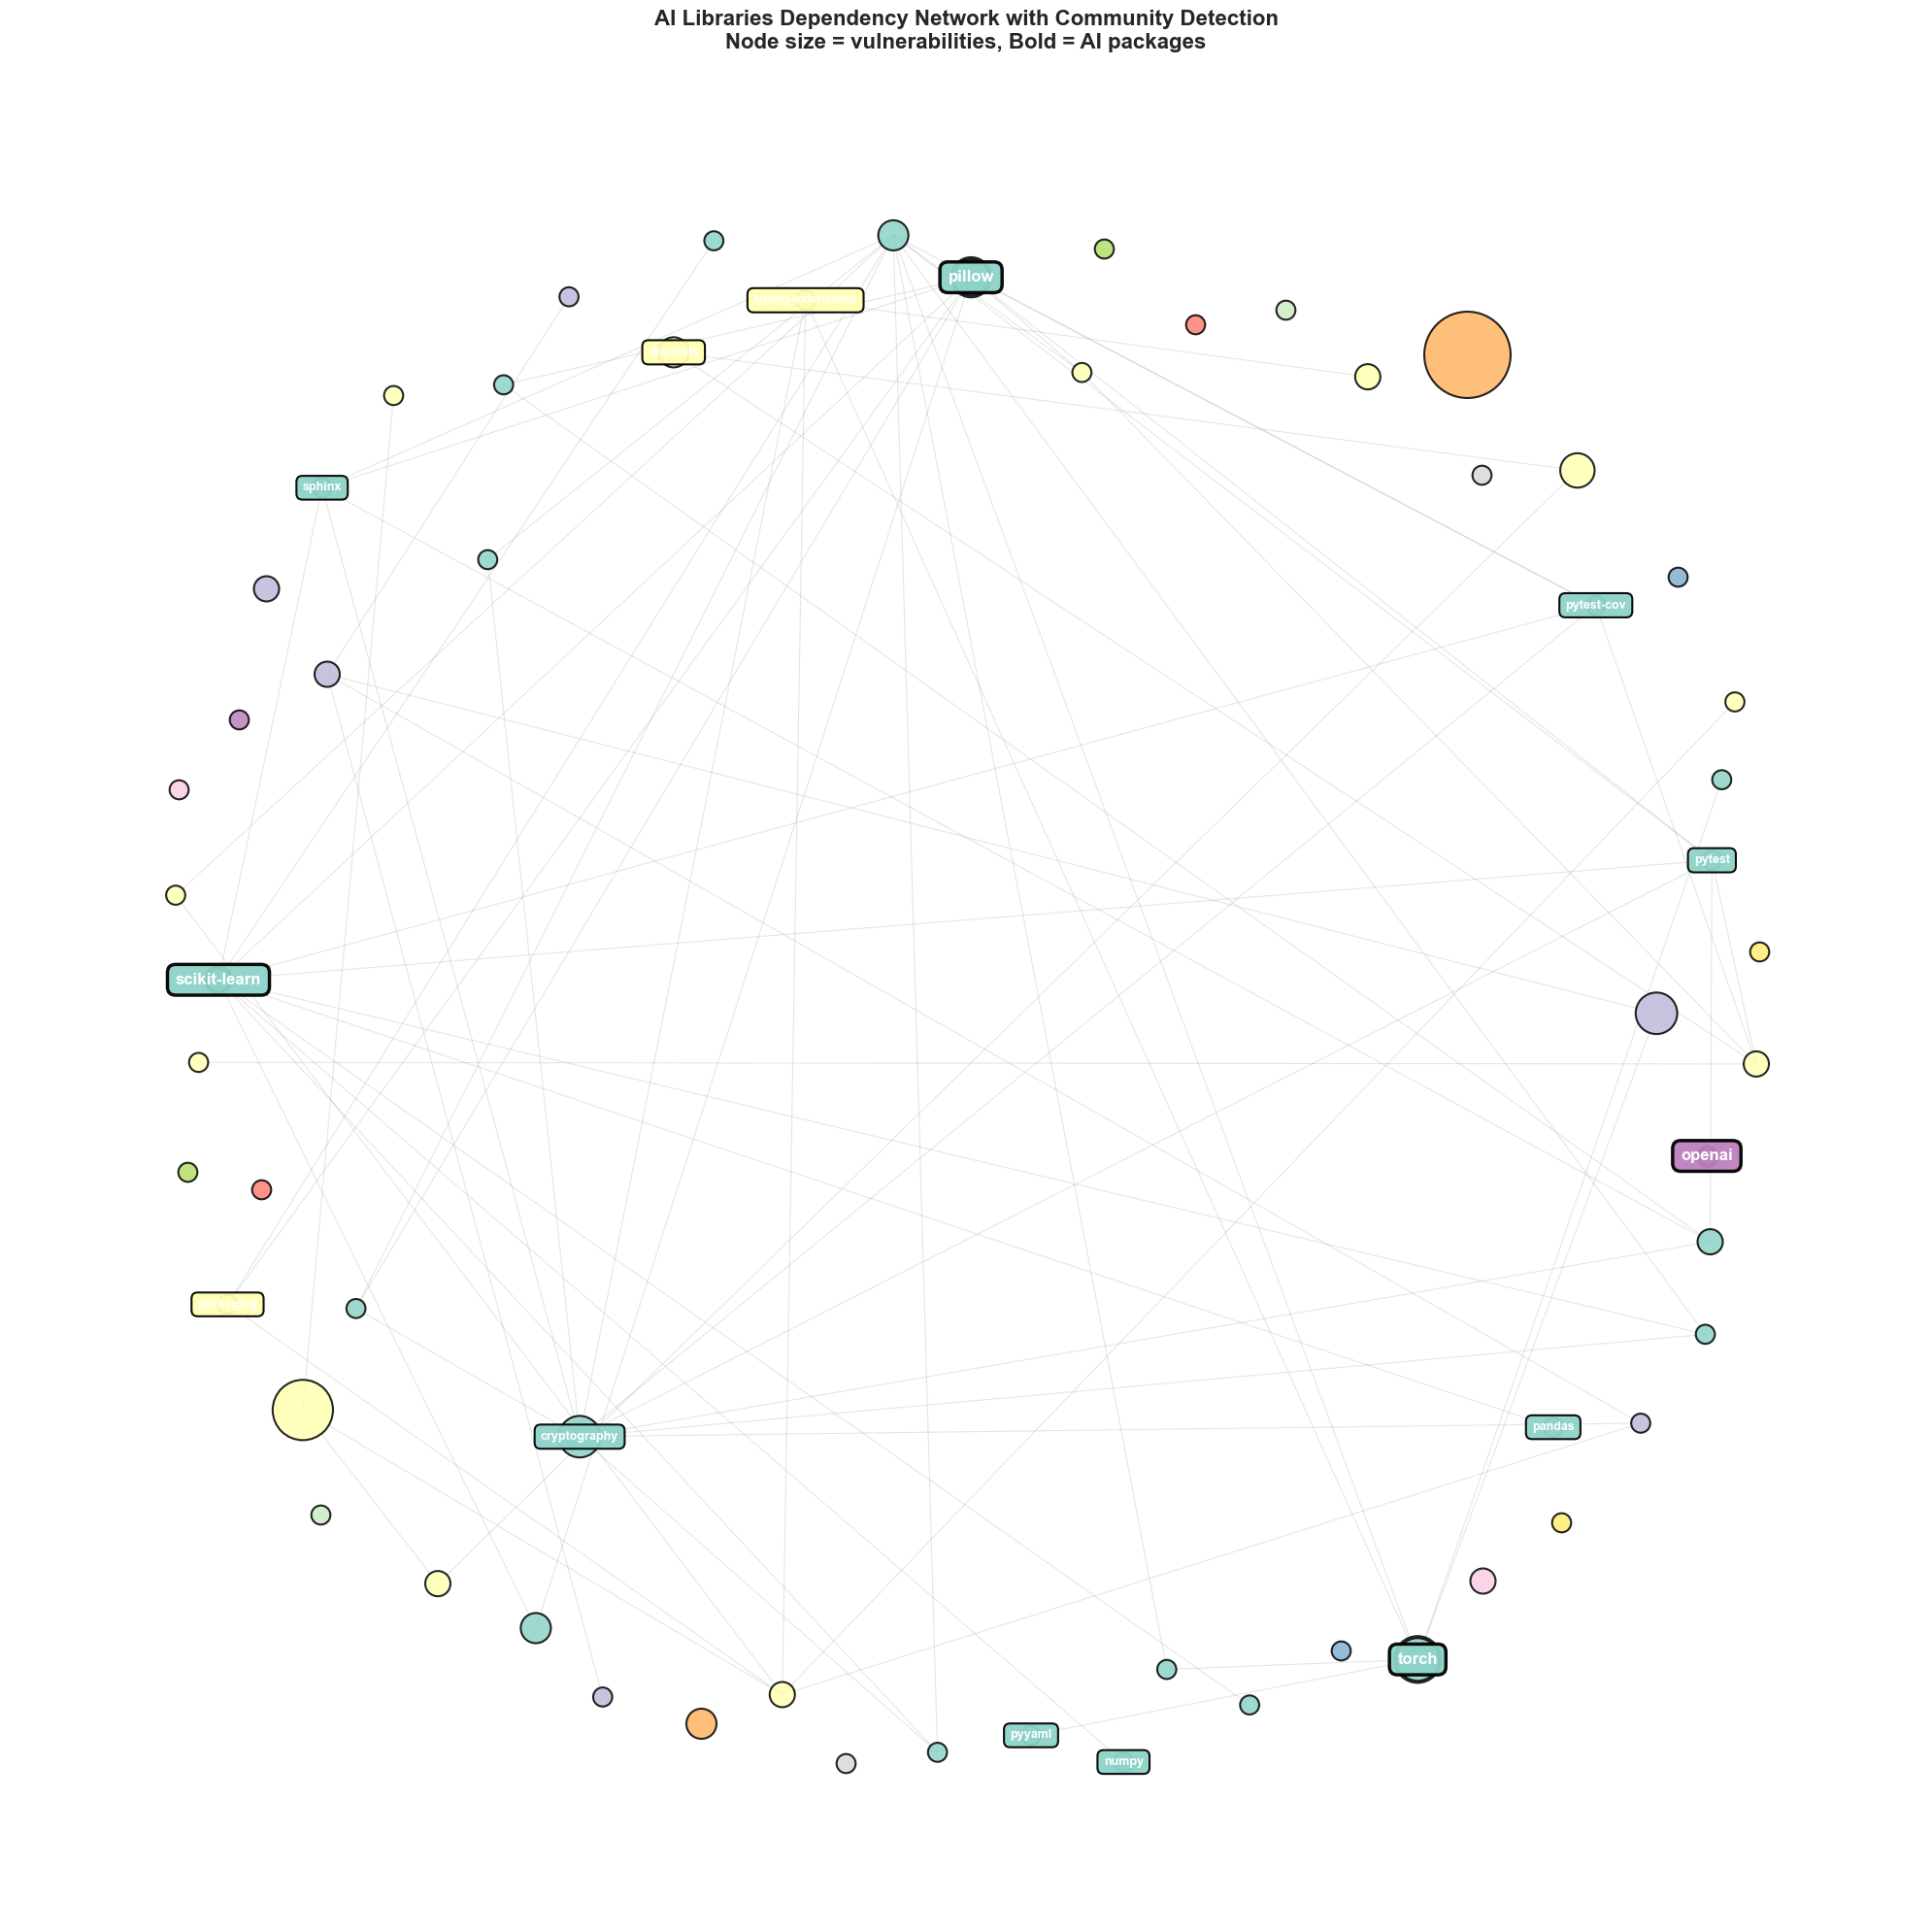

✅ Saved: outputs/plots/network_clusters_ai.png


In [23]:
# Detectar comunidades na rede de IA
print('Detectando comunidades na rede de IA...')

G_ai_undirected = G_ai.to_undirected()

# Detectar comunidades
communities_ai = community.greedy_modularity_communities(G_ai_undirected)

print(f'Comunidades AI detectadas: {len(communities_ai)}')
for i, comm in enumerate(communities_ai[:5]):
    print(f'  AI Cluster {i+1}: {len(comm)} nós')

# Node -> community
node_to_community_ai = {}
for i, comm in enumerate(communities_ai):
    for node in comm:
        node_to_community_ai[node] = i

# Cores
num_communities_ai = len(communities_ai)
colors_ai = plt.cm.Set3(np.linspace(0, 1, num_communities_ai))
community_colors_ai = {i: colors_ai[i] for i in range(num_communities_ai)}

# Plot REDE AI com clusters
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Layout
pos_ai = nx.spring_layout(G_ai_undirected, k=3, iterations=50, seed=42)

# Arestas
nx.draw_networkx_edges(
    G_ai_undirected, pos_ai,
    alpha=0.2,
    edge_color='gray',
    width=0.8,
    ax=ax
)

# Nós por comunidade
for comm_id in range(num_communities_ai):
    nodes_in_comm = [n for n in G_ai_undirected.nodes() if node_to_community_ai.get(n) == comm_id]
    if not nodes_in_comm:
        continue
    
    # Tamanho baseado em número de vulnerabilidades
    vuln_counts_dict = vulns_net.groupby('package_lower')['cve'].nunique().to_dict()
    node_sizes = [vuln_counts_dict.get(n, 0) * 150 + 200 for n in nodes_in_comm]
    
    # Borda mais grossa para AI libs
    linewidths = [3 if n in AI_LIBS else 1.5 for n in nodes_in_comm]
    
    nx.draw_networkx_nodes(
        G_ai_undirected, pos_ai,
        nodelist=nodes_in_comm,
        node_color=[community_colors_ai[comm_id]],
        node_size=node_sizes,
        alpha=0.85,
        edgecolors='black',
        linewidths=linewidths,
        ax=ax
    )

# Labels para TODAS as AI libs + top dependências
labels_ai_dict = {}
for node in G_ai_undirected.nodes():
    if node in AI_LIBS:
        labels_ai_dict[node] = node
    elif node in metrics_df.nlargest(10, 'in_degree')['package'].tolist():
        labels_ai_dict[node] = node

# Desenhar labels com cor do cluster
for node, label in labels_ai_dict.items():
    x, y = pos_ai[node]
    comm_id = node_to_community_ai.get(node, 0)
    color = community_colors_ai[comm_id]
    
    # AI libs: fonte maior e borda mais grossa
    if node in AI_LIBS:
        fontsize = 12
        linewidth = 2.5
    else:
        fontsize = 9
        linewidth = 1.5
    
    ax.text(x, y, label, 
            fontsize=fontsize, fontweight='bold',
            ha='center', va='center',
            color='white',
            bbox=dict(boxstyle='round,pad=0.5', 
                     facecolor=color, 
                     edgecolor='black',
                     linewidth=linewidth,
                     alpha=0.95))

ax.set_title('AI Libraries Dependency Network with Community Detection\nNode size = vulnerabilities, Bold = AI packages', 
             fontsize=16, fontweight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
plt.savefig('outputs/plots/network_clusters_ai.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: outputs/plots/network_clusters_ai.png')

In [24]:
# Estatísticas dos clusters
print('='*70)
print('CLUSTER ANALYSIS')
print('='*70)

print(f'\n📊 REDE GERAL:')
print(f'   Total de clusters: {len(communities)}')
print(f'   Modularidade: {community.modularity(G_viz_undirected, communities):.4f}')
print(f'\n   Top 5 maiores clusters:')
for i, comm in enumerate(sorted(communities, key=len, reverse=True)[:5]):
    # Encontrar os nós mais importantes deste cluster
    comm_nodes = list(comm)
    comm_metrics = metrics_df[metrics_df['package'].isin(comm_nodes)]
    top_node = comm_metrics.nlargest(1, 'in_degree')['package'].values[0] if len(comm_metrics) > 0 else 'N/A'
    print(f'      Cluster {i+1}: {len(comm)} nós (hub: {top_node})')

print(f'\n🤖 REDE DE IA:')
print(f'   Total de clusters: {len(communities_ai)}')
print(f'   Modularidade: {community.modularity(G_ai_undirected, communities_ai):.4f}')
print(f'\n   Top 5 maiores clusters:')
for i, comm in enumerate(sorted(communities_ai, key=len, reverse=True)[:5]):
    comm_nodes = list(comm)
    ai_in_cluster = [n for n in comm_nodes if n in AI_LIBS]
    comm_metrics = metrics_df[metrics_df['package'].isin(comm_nodes)]
    top_node = comm_metrics.nlargest(1, 'in_degree')['package'].values[0] if len(comm_metrics) > 0 else 'N/A'
    print(f'      Cluster {i+1}: {len(comm)} nós ({len(ai_in_cluster)} AI) (hub: {top_node})')

print('\n' + '='*70)

CLUSTER ANALYSIS

📊 REDE GERAL:
   Total de clusters: 27
   Modularidade: 0.4576

   Top 5 maiores clusters:
      Cluster 1: 18 nós (hub: numpy)
      Cluster 2: 15 nós (hub: pytest)
      Cluster 3: 12 nós (hub: typing-extensions)
      Cluster 4: 10 nós (hub: requests)
      Cluster 5: 10 nós (hub: packaging)

🤖 REDE DE IA:
   Total de clusters: 24
   Modularidade: 0.4081

   Top 5 maiores clusters:
      Cluster 1: 12 nós (2 AI) (hub: pytest)
      Cluster 2: 10 nós (1 AI) (hub: pyyaml)
      Cluster 3: 8 nós (0 AI) (hub: requests)
      Cluster 4: 6 nós (0 AI) (hub: typing-extensions)
      Cluster 5: 5 nós (0 AI) (hub: jinja2)



In [7]:
print('Top 15 by BETWEENNESS (connectors):')
metrics_df.nlargest(15, 'betweenness')[['package', 'betweenness', 'is_ai_lib']]

Top 15 by BETWEENNESS (connectors):


package  betweenness  is_ai_lib
462     transformers     0.002234       True
164   apache-airflow     0.001584      False
1254       sagemaker     0.001511       True
523       setuptools     0.000589      False
954           mlflow     0.000570       True
577        deepspeed     0.000507      False
163     cryptography     0.000470      False
1218            vllm     0.000370       True
667              ray     0.000321      False
464            torch     0.000291       True
292        dnspython     0.000262      False
455     scikit-learn     0.000247       True
696       virtualenv     0.000245      False
39            pillow     0.000243       True
1            aiohttp     0.000233      False

## 🔗 6. Merge with Vulnerabilities

In [8]:
vulns['package_lower'] = vulns['package'].str.lower()

vulns_net = vulns.merge(
    metrics_df, 
    left_on='package_lower', 
    right_on='package', 
    how='left',
    suffixes=('', '_net')
)

net_cols = ['degree', 'in_degree', 'out_degree', 'betweenness', 'eigenvector', 'pagerank']
vulns_net[net_cols] = vulns_net[net_cols].fillna(0)

print(f'Merged: {len(vulns_net)} rows')
vulns_net[['package', 'cve', 'severity', 'degree', 'in_degree']].head(10)

Merged: 649 rows


package             cve  severity  degree  in_degree
0       urllib3  CVE-2024-37891  moderate      17         12
1       urllib3  CVE-2025-50182  moderate      17         12
2       urllib3  CVE-2025-50181  moderate      17         12
3      requests  CVE-2024-47081  moderate      47         41
4      requests  CVE-2024-35195  moderate      47         41
5       certifi  CVE-2024-39689       low      13         13
6          idna   CVE-2024-3651  moderate      10          6
7    setuptools  CVE-2025-47273      high      59         14
8    setuptools   CVE-2024-6345      high      59         14
9  cryptography  CVE-2023-50782      high      54         31

## 📈 7. TEMPORAL ANALYSIS

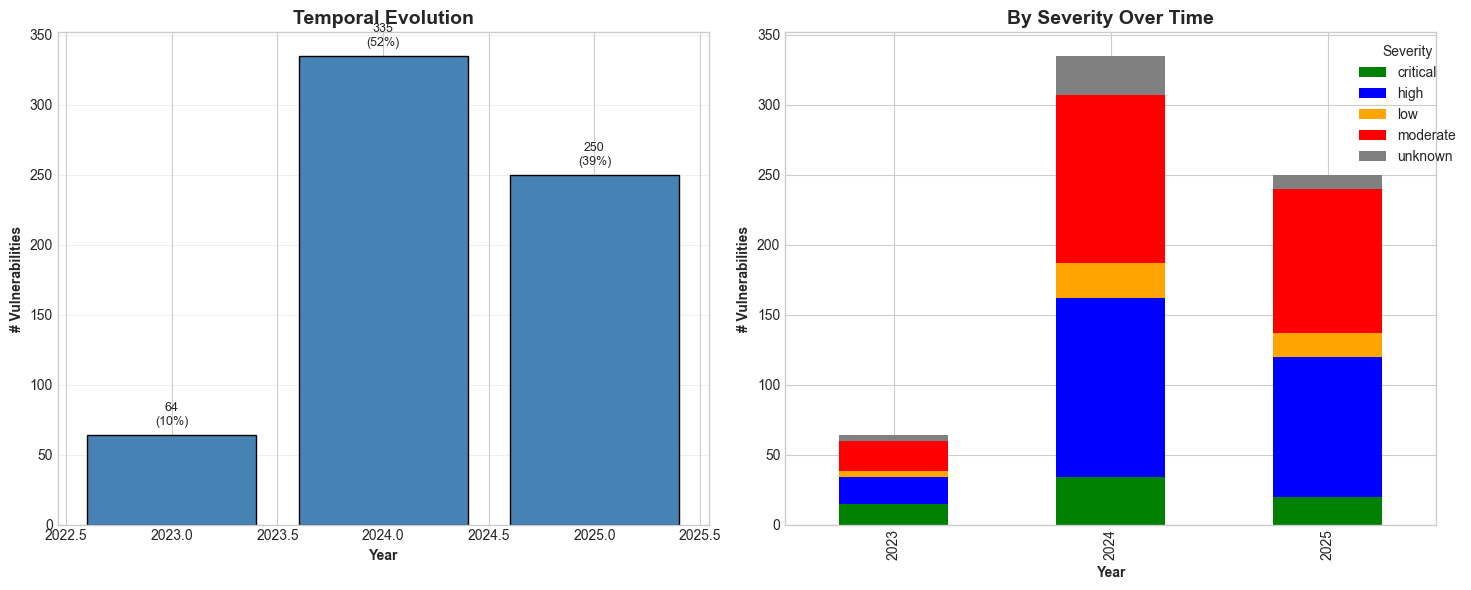

✅ Saved: outputs/plots/temporal_evolution.png


In [9]:
vulns_net['disclosed_year'] = vulns_net['disclosed_date'].dt.year

temporal_total = vulns_net.groupby('disclosed_year').size().reset_index(name='total')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Total por ano
ax1.bar(temporal_total['disclosed_year'], temporal_total['total'], color='steelblue', edgecolor='black')
for _, row in temporal_total.iterrows():
    ax1.text(row['disclosed_year'], row['total'] + 5, 
             f"{row['total']}\n({row['total']/temporal_total['total'].sum()*100:.0f}%)", 
             ha='center', va='bottom', fontsize=9)
ax1.set_xlabel('Year', fontweight='bold')
ax1.set_ylabel('# Vulnerabilities', fontweight='bold')
ax1.set_title('Temporal Evolution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Por severidade
pivot = vulns_net.groupby(['disclosed_year', 'severity']).size().reset_index(name='count')
pivot = pivot.pivot(index='disclosed_year', columns='severity', values='count').fillna(0)
pivot.plot(kind='bar', stacked=True, ax=ax2, color=['green', 'blue', 'orange', 'red', 'gray'])
ax2.set_xlabel('Year', fontweight='bold')
ax2.set_ylabel('# Vulnerabilities', fontweight='bold')
ax2.set_title('By Severity Over Time', fontsize=14, fontweight='bold')
ax2.legend(title='Severity', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.savefig('outputs/plots/temporal_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: outputs/plots/temporal_evolution.png')

## ⏱️ 8. SURVIVAL ANALYSIS

For survival: 137
Fixed: 137, Not fixed: 0


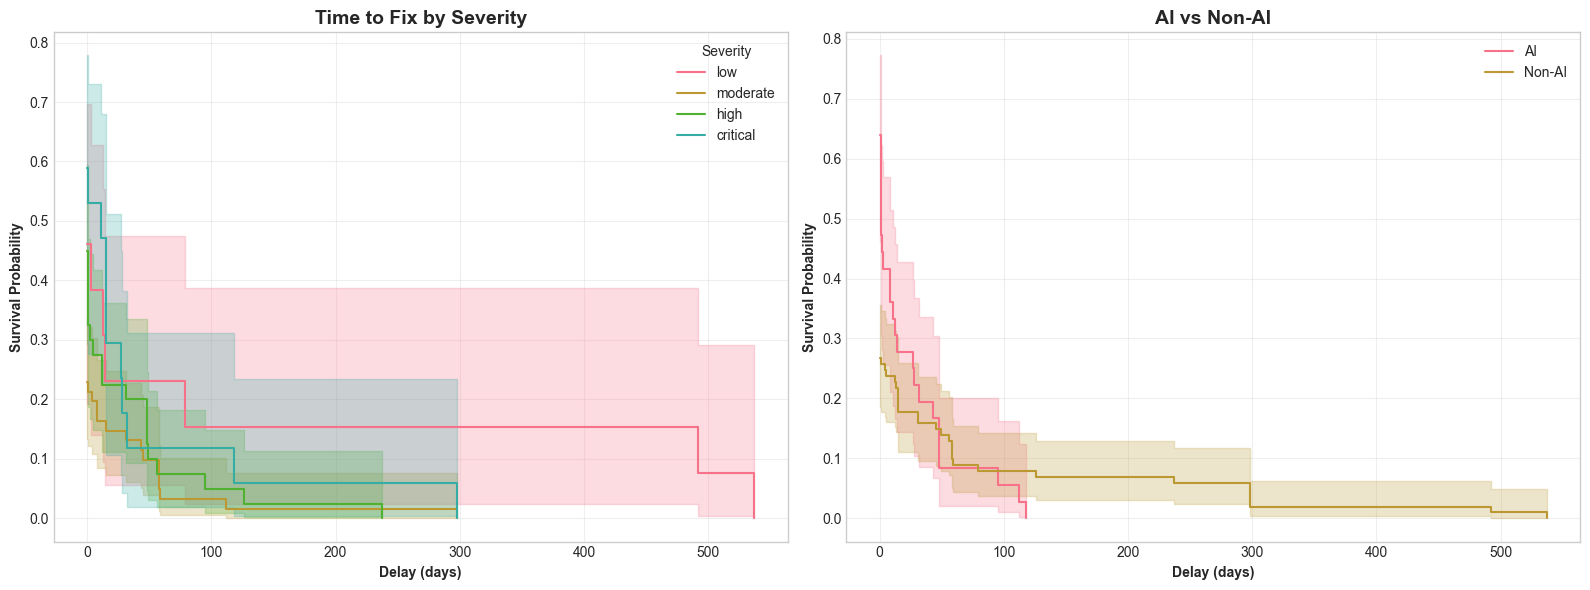

✅ Saved: outputs/plots/survival_analysis.png


In [10]:
vulns_surv = vulns_net[
    vulns_net['time_to_fix_from_disclosure_days'].notna() & 
    (vulns_net['time_to_fix_from_disclosure_days'] >= 0)
].copy()

vulns_surv['event'] = vulns_surv['mitigation_date'].notna().astype(int)

print(f'For survival: {len(vulns_surv)}')
print(f'Fixed: {vulns_surv["event"].sum()}, Not fixed: {(vulns_surv["event"] == 0).sum()}')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
kmf = KaplanMeierFitter()

# Por severidade
ax = axes[0]
for severity in ['low', 'moderate', 'high', 'critical']:
    mask = vulns_surv['severity'].str.lower() == severity
    if mask.sum() > 0:
        kmf.fit(
            durations=vulns_surv[mask]['time_to_fix_from_disclosure_days'],
            event_observed=vulns_surv[mask]['event'],
            label=severity
        )
        kmf.plot_survival_function(ax=ax, ci_show=True)

ax.set_xlabel('Delay (days)', fontweight='bold')
ax.set_ylabel('Survival Probability', fontweight='bold')
ax.set_title('Time to Fix by Severity', fontsize=14, fontweight='bold')
ax.legend(title='Severity')
ax.grid(alpha=0.3)

# AI vs Non-AI
ax = axes[1]
for is_ai, label in [(True, 'AI'), (False, 'Non-AI')]:
    mask = vulns_surv['is_ai_lib'] == is_ai
    if mask.sum() > 0:
        kmf.fit(
            durations=vulns_surv[mask]['time_to_fix_from_disclosure_days'],
            event_observed=vulns_surv[mask]['event'],
            label=label
        )
        kmf.plot_survival_function(ax=ax, ci_show=True)

ax.set_xlabel('Delay (days)', fontweight='bold')
ax.set_ylabel('Survival Probability', fontweight='bold')
ax.set_title('AI vs Non-AI', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/survival_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: outputs/plots/survival_analysis.png')

## 🚨 9. ACTIVE VULNERABILITIES

Active: 120 (18.5%)
AI: 41, Non-AI: 79


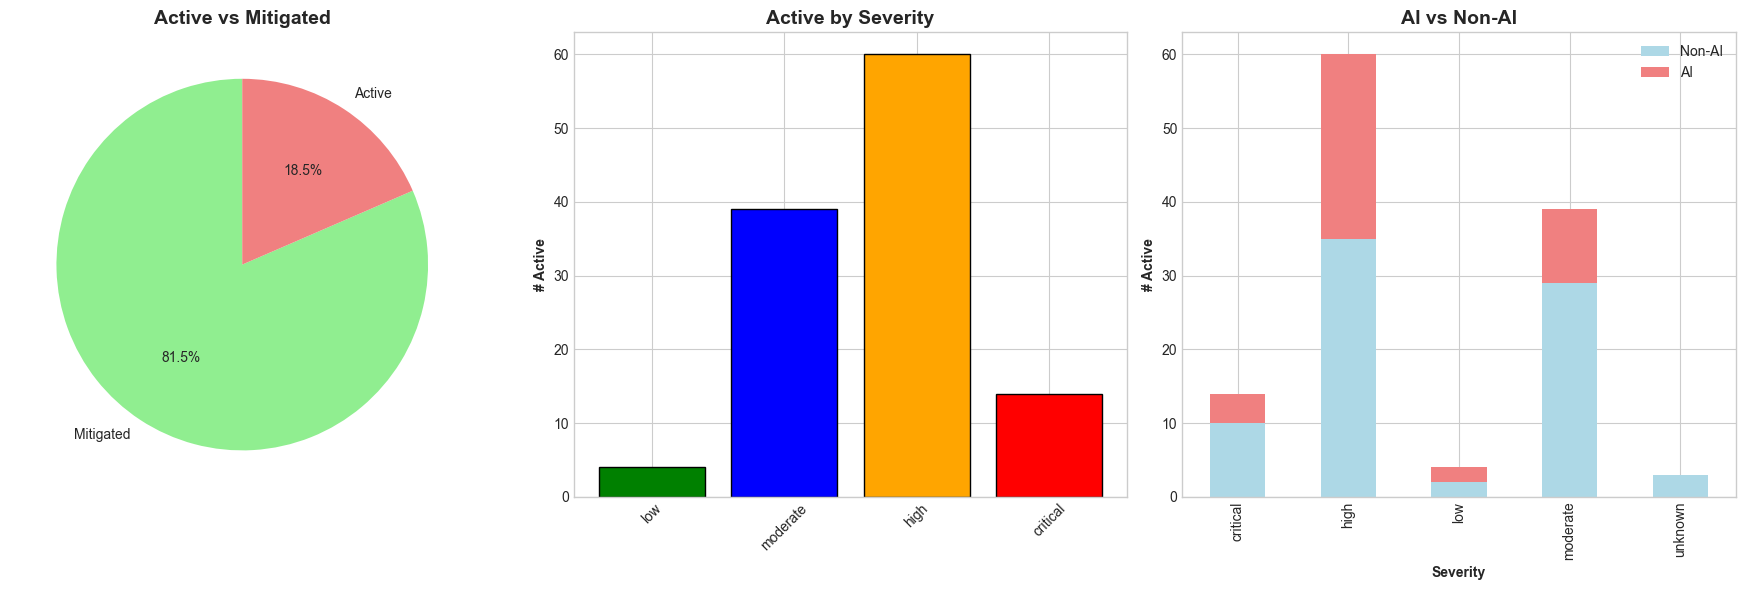

✅ Saved: outputs/plots/active_vulnerabilities.png


In [11]:
vulns_net['is_active'] = vulns_net['mitigation_date'].isna()
active_vulns = vulns_net[vulns_net['is_active']].copy()

print(f'Active: {len(active_vulns)} ({len(active_vulns)/len(vulns_net)*100:.1f}%)')
print(f'AI: {active_vulns["is_ai_lib"].sum()}, Non-AI: {(~active_vulns["is_ai_lib"]).sum()}')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pie chart
status_counts = vulns_net['is_active'].value_counts()
axes[0].pie(status_counts.values, labels=['Mitigated', 'Active'], autopct='%1.1f%%',
            colors=['lightgreen', 'lightcoral'], startangle=90)
axes[0].set_title('Active vs Mitigated', fontsize=14, fontweight='bold')

# By severity
active_sev = active_vulns['severity'].value_counts().reindex(['low', 'moderate', 'high', 'critical'], fill_value=0)
axes[1].bar(range(len(active_sev)), active_sev.values, color=['green', 'blue', 'orange', 'red'], edgecolor='black')
axes[1].set_xticks(range(len(active_sev)))
axes[1].set_xticklabels(active_sev.index, rotation=45)
axes[1].set_ylabel('# Active', fontweight='bold')
axes[1].set_title('Active by Severity', fontsize=14, fontweight='bold')

# AI vs Non-AI
active_ai = active_vulns.groupby(['is_ai_lib', 'severity']).size().unstack(fill_value=0)
active_ai.T.plot(kind='bar', stacked=True, ax=axes[2], color=['lightblue', 'lightcoral'])
axes[2].set_xlabel('Severity', fontweight='bold')
axes[2].set_ylabel('# Active', fontweight='bold')
axes[2].set_title('AI vs Non-AI', fontsize=14, fontweight='bold')
axes[2].legend(['Non-AI', 'AI'])

plt.tight_layout()
plt.savefig('outputs/plots/active_vulnerabilities.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: outputs/plots/active_vulnerabilities.png')

## 📊 10. COMPARISON: AI vs Non-AI

In [12]:
metrics_ai = metrics_df[metrics_df['is_ai_lib']]
metrics_non_ai = metrics_df[~metrics_df['is_ai_lib']]

comparison_metrics = ['degree', 'in_degree', 'betweenness', 'pagerank']
comparison_data = []

for metric in comparison_metrics:
    stat, pvalue = stats.mannwhitneyu(metrics_ai[metric], metrics_non_ai[metric], alternative='two-sided')
    comparison_data.append({
        'metric': metric,
        'ai_mean': metrics_ai[metric].mean(),
        'non_ai_mean': metrics_non_ai[metric].mean(),
        'p_value': pvalue,
        'sig': '***' if pvalue < 0.001 else '**' if pvalue < 0.01 else '*' if pvalue < 0.05 else 'ns'
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv('outputs/summaries/network_comparison.csv', index=False)

print('Statistical Comparison:')
comparison_df

Statistical Comparison:


metric    ai_mean  non_ai_mean       p_value  sig
0       degree  28.296296     4.032723  1.520257e-16  ***
1    in_degree   3.740741     2.200262  1.521207e-02    *
2  betweenness   0.000225     0.000005  1.141023e-29  ***
3     pagerank   0.000695     0.000642  3.004224e-01   ns

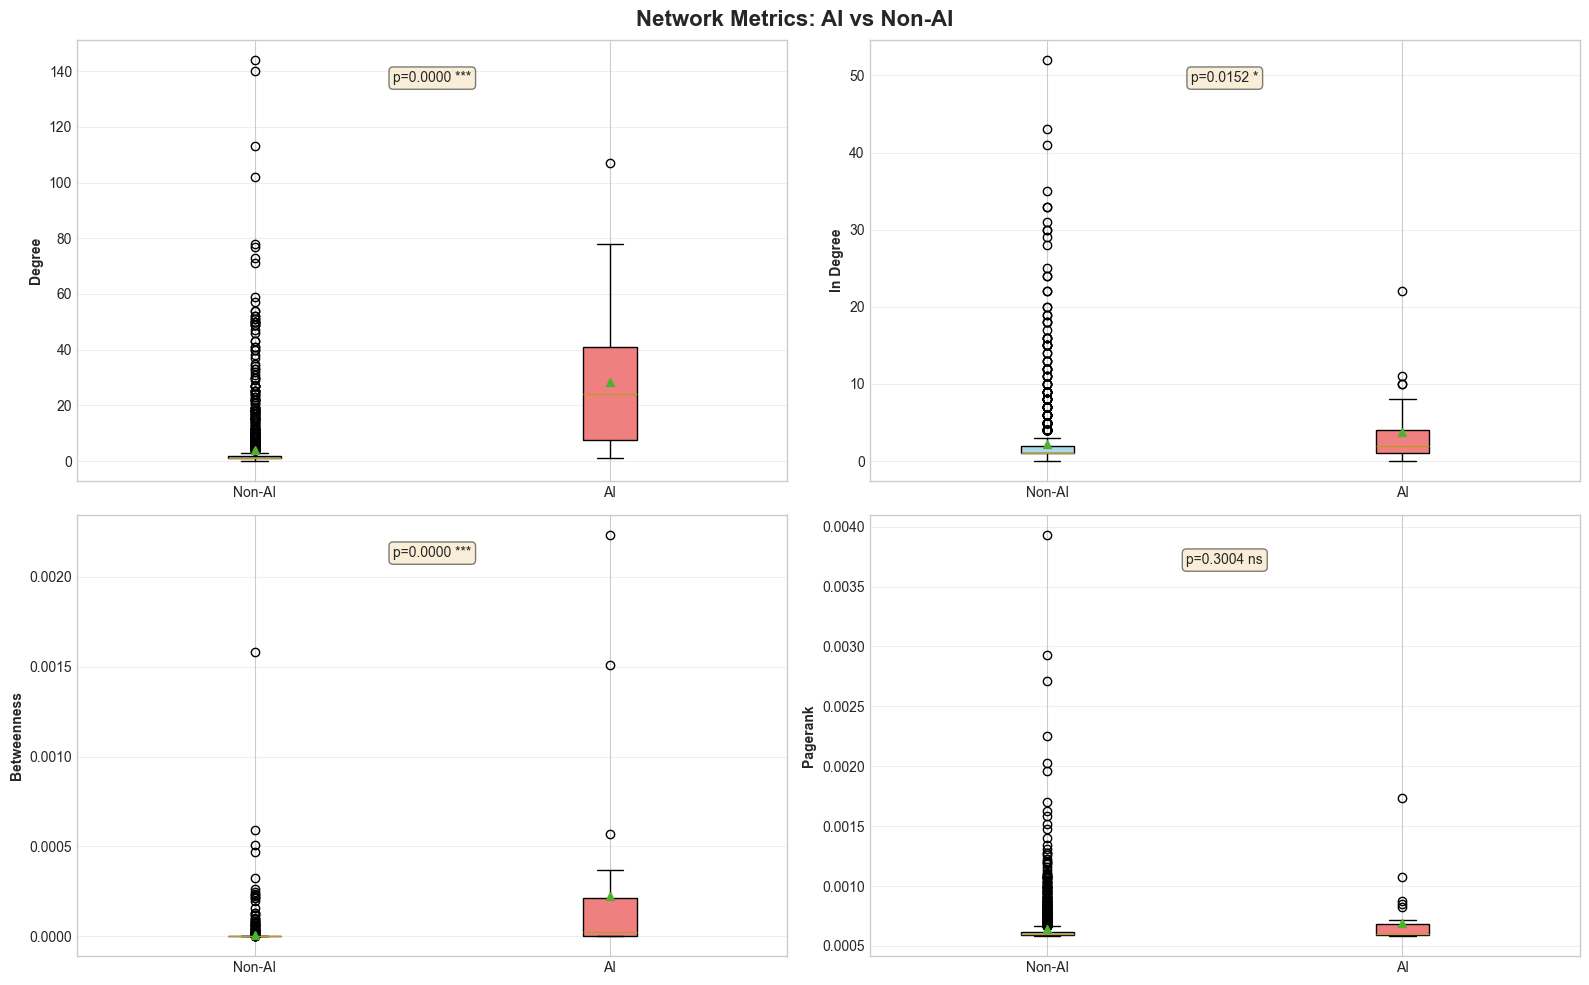

✅ Saved: outputs/plots/network_comparison.png


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, metric in enumerate(comparison_metrics):
    ax = axes[idx]
    data = [metrics_non_ai[metric], metrics_ai[metric]]
    bp = ax.boxplot(data, labels=['Non-AI', 'AI'], patch_artist=True, showmeans=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    row = comparison_df[comparison_df['metric'] == metric].iloc[0]
    ax.text(1.5, ax.get_ylim()[1] * 0.9, f"p={row['p_value']:.4f} {row['sig']}",
            ha='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_ylabel(metric.replace('_', ' ').title(), fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Network Metrics: AI vs Non-AI', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/plots/network_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Saved: outputs/plots/network_comparison.png')

## 🎓 11. SUMMARY

In [14]:
print('='*80)
print('SUMMARY')
print('='*80)

print(f'\nNETWORK:')
print(f'  Nodes: {G.number_of_nodes()}')
print(f'  Edges: {G.number_of_edges()}')
print(f'  Density: {nx.density(G):.6f}')

print(f'\nVULNERABILITIES:')
print(f'  Total: {len(vulns_net)}')
print(f'  Active: {vulns_net["is_active"].sum()} ({vulns_net["is_active"].sum()/len(vulns_net)*100:.1f}%)')

print(f'\nAI vs NON-AI:')
print(f'  AI vulns: {vulns_net["is_ai_lib"].sum()}')
print(f'  Non-AI vulns: {(~vulns_net["is_ai_lib"]).sum()}')

print(f'\nTIME-TO-FIX (median):')
print(f'  AI: {vulns_net[vulns_net["is_ai_lib"]]["time_to_fix_from_disclosure_days"].median():.1f} days')
print(f'  Non-AI: {vulns_net[~vulns_net["is_ai_lib"]]["time_to_fix_from_disclosure_days"].median():.1f} days')

print(f'\nTOP 5 MOST IMPORTANT:')
top5 = metrics_df.nlargest(5, 'in_degree')[['package', 'in_degree']]
for _, row in top5.iterrows():
    print(f'  {row["package"]}: {row["in_degree"]:.0f} dependents')

print('\n' + '='*80)
print('✅ ANALYSIS COMPLETE!')
print('='*80)

SUMMARY

NETWORK:
  Nodes: 1555
  Edges: 3463
  Density: 0.001433

VULNERABILITIES:
  Total: 649
  Active: 120 (18.5%)

AI vs NON-AI:
  AI vulns: 216
  Non-AI vulns: 433

TIME-TO-FIX (median):
  AI: -22.0 days
  Non-AI: -2.0 days

TOP 5 MOST IMPORTANT:
  pytest: 52 dependents
  numpy: 43 dependents
  requests: 41 dependents
  typing-extensions: 35 dependents
  pyyaml: 33 dependents

✅ ANALYSIS COMPLETE!


## 🔥 12. Vulnerability-Aware Prioritization (General + AI)

Nesta seção calculamos um índice de prioridade (PIndex) que combina:
- Vulnerabilidade: `active_cves`, `num_cves`, `severity`
- Influência na rede: `in_degree`, `betweenness`, `pagerank`
- Alcance (impacto): dependentes diretos/indiretos e dependentes de IA

Fórmulas:
- PIndex (Geral) = 0.35·Active + 0.20·Severity + 0.20·ReachTotal + 0.15·InDegree + 0.10·PageRank
- PIndex (IA)    = 0.40·ReachAI + 0.30·Active + 0.15·Severity + 0.10·InDegree + 0.05·Betweenness

Saídas geradas:
- `outputs/summaries/prioritization_general.csv`
- `outputs/summaries/prioritization_ai.csv`

In [41]:
# Helpers
from math import isfinite

def normalize(series):
    s = series.astype(float).fillna(0)
    mn, mx = s.min(), s.max()
    if not isfinite(mn) or not isfinite(mx) or mx == mn:
        return s*0
    return (s - mn) / (mx - mn)

def dependents_stats(graph, node, ai_set):
    if node not in graph:
        return 0, 0, 0
    direct = len(list(graph.predecessors(node)))
    try:
        indirect_nodes = set(nx.ancestors(graph, node))
    except Exception:
        indirect_nodes = set()
    indirect = len(indirect_nodes)
    ai_indirect = len([n for n in indirect_nodes if n in ai_set])
    return direct, indirect, ai_indirect

In [34]:
# 1) Agregar vulnerabilidades por pacote
v_agg = (
    vulns_net.groupby('package_lower')
    .agg(num_cves=('cve','nunique'),
         active_cves=('is_active','sum'),
         max_sev=('severity_norm','max'),
         mean_sev=('severity_norm','mean'))
    .reset_index()
)

# 2) Juntar métricas de rede
net_cols = ['package','degree','in_degree','out_degree','betweenness','eigenvector','pagerank']
metrics_for_merge = metrics_df[net_cols].rename(columns={'package':'package_lower'})
pri = v_agg.merge(metrics_for_merge, on='package_lower', how='left')

# 3) Dependentes diretos/indiretos/IA
ai_set = set(AI_LIBS)
rows = []
for pkg in pri['package_lower'].fillna(''):
    d, ind, ind_ai = dependents_stats(G, pkg, ai_set)
    rows.append((d, ind, ind_ai))
pri[['direct_dependents','indirect_dependents','indirect_ai_dependents']] = pd.DataFrame(rows, index=pri.index)

# 4) Normalizar componentes
pri['n_active']   = normalize(pri['active_cves'])
pri['n_severity'] = normalize(pri['max_sev'])
pri['n_reach']    = normalize(pri['indirect_dependents'])
pri['n_reach_ai'] = normalize(pri['indirect_ai_dependents'])
pri['n_indegree'] = normalize(pri['in_degree'].fillna(0))
pri['n_pr']       = normalize(pri['pagerank'].fillna(0))
pri['n_bw']       = normalize(pri['betweenness'].fillna(0))

# 5) Priority Index (Geral e IA)
pri['pindex_general'] = (0.35*pri['n_active'] + 0.20*pri['n_severity'] + 0.20*pri['n_reach'] +
                         0.15*pri['n_indegree'] + 0.10*pri['n_pr'])
pri['pindex_ai']      = (0.40*pri['n_reach_ai'] + 0.30*pri['n_active'] + 0.15*pri['n_severity'] +
                         0.10*pri['n_indegree'] + 0.05*pri['n_bw'])

# 6) Enriquecer com nome 'package' e flag AI
pri['package'] = pri['package_lower']
pri['is_ai_lib'] = pri['package'].isin(AI_LIBS)

# 7) Ordenações e salvamento
cols_out = ['package','is_ai_lib','num_cves','active_cves','max_sev',
            'in_degree','betweenness','pagerank',
            'direct_dependents','indirect_dependents','indirect_ai_dependents',
            'pindex_general','pindex_ai']

rank_general = pri.sort_values('pindex_general', ascending=False)[cols_out].head(30)
rank_ai      = pri.sort_values('pindex_ai', ascending=False)[cols_out].head(30)

print('Top 15 - PRIORIDADE GERAL (PIndex):')
display(rank_general.head(15))
print('Top 15 - PRIORIDADE IA (PIndex_AI):')
display(rank_ai.head(15))

# Salvar CSVs
import os
os.makedirs('outputs/summaries', exist_ok=True)
rank_general.to_csv('outputs/summaries/prioritization_general.csv', index=False)
rank_ai.to_csv('outputs/summaries/prioritization_ai.csv', index=False)
print('✅ CSVs salvos:')
print(' - outputs/summaries/prioritization_general.csv')
print(' - outputs/summaries/prioritization_ai.csv')

Top 15 - PRIORIDADE GERAL (PIndex):


package  is_ai_lib  num_cves  active_cves  max_sev  in_degree  \
110  paddlepaddle      False        24           24        4          1   
32   cryptography      False         5            0        3         31   
97         mlflow       True        46           15        4          2   
103    open-webui      False        22           22        3          0   
143      requests      False         2            0        2         41   
118       pyarrow      False         2            0        4         15   
114        pillow       True         4            0        4         22   
58         gradio       True        37           10        4          1   
22         brotli      False         1            0        3          9   
2         aiohttp      False        12            0        3         20   
66         jinja2      False         5            0        2         25   
174          vllm       True        25            5        4          1   
122      pydantic      False         1            0        2         28   
164         torch       True         6            1        4         11   
85        litellm       True        14            4        4          3   

     betweenness  pagerank  direct_dependents  indirect_dependents  \
110     0.000003  0.000593                  1                    3   
32      0.000470  0.002926                 31                   69   
97      0.000570  0.000600                  2                   16   
103     0.000000  0.000582                  0                    0   
143     0.000225  0.001628                 41                   63   
118     0.000000  0.000959                 15                   53   
114     0.000243  0.001079                 22                   37   
58      0.000022  0.000598                  1                    1   
22      0.000000  0.000960                  9                   81   
2       0.000233  0.001039                 20                   53   
66      0.000040  0.001480                 25                   60   
174     0.000370  0.000593                  1                   12   
122     0.000095  0.001311                 28                   46   
164     0.000291  0.000717                 11                   14   
85      0.000168  0.000608                  3                    3   

     indirect_ai_dependents  pindex_general  pindex_ai  
110                       0        0.560237   0.452505  
32                       10        0.487564   0.452807  
97                        6        0.459477   0.515131  
103                       0        0.454167   0.375000  
143                      13        0.389841   0.501698  
118                      15        0.379103   0.586585  
114                      14        0.377168   0.582421  
58                        0        0.352214   0.277928  
22                       14        0.347661   0.495285  
2                        11        0.334172   0.447322  
66                        9        0.318895   0.351871  
174                       3        0.301527   0.303218  
122                      13        0.294090   0.467079  
164                       4        0.289165   0.302515  
85                        0        0.276529   0.211076

Top 15 - PRIORIDADE IA (PIndex_AI):


package  is_ai_lib  num_cves  active_cves  max_sev  in_degree  \
118       pyarrow      False         2            0        4         15   
114        pillow       True         4            0        4         22   
97         mlflow       True        46           15        4          2   
143      requests      False         2            0        2         41   
22         brotli      False         1            0        3          9   
122      pydantic      False         1            0        2         28   
32   cryptography      False         5            0        3         31   
110  paddlepaddle      False        24           24        4          1   
2         aiohttp      False        12            0        3         20   
170       urllib3      False         3            0        2         12   
65           idna      False         1            1        2          6   
151    setuptools      False         2            0        3         14   
61             h2      False         1            0        2          4   
26        certifi      False         1            0        1         13   
173    virtualenv      False         1            0        3          6   

     betweenness  pagerank  direct_dependents  indirect_dependents  \
118     0.000000  0.000959                 15                   53   
114     0.000243  0.001079                 22                   37   
97      0.000570  0.000600                  2                   16   
143     0.000225  0.001628                 41                   63   
22      0.000000  0.000960                  9                   81   
122     0.000095  0.001311                 28                   46   
32      0.000470  0.002926                 31                   69   
110     0.000003  0.000593                  1                    3   
2       0.000233  0.001039                 20                   53   
170     0.000127  0.001037                 12                   65   
65      0.000038  0.001136                  6                   71   
151     0.000589  0.000908                 14                   36   
61      0.000060  0.000829                  4                   73   
26      0.000000  0.001160                 13                   98   
173     0.000245  0.000646                  6                   36   

     indirect_ai_dependents  pindex_general  pindex_ai  
118                      15        0.379103   0.586585  
114                      14        0.377168   0.582421  
97                        6        0.459477   0.515131  
143                      13        0.389841   0.501698  
22                       14        0.347661   0.495285  
122                      13        0.294090   0.467079  
32                       10        0.487564   0.452807  
110                       0        0.560237   0.452505  
2                        11        0.334172   0.447322  
170                      13        0.262619   0.428769  
65                       13        0.271725   0.424658  
151                      10        0.271933   0.414002  
61                       13        0.240805   0.407768  
26                       14        0.272200   0.405041  
173                      10        0.231472   0.386792

✅ CSVs salvos:
 - outputs/summaries/prioritization_general.csv
 - outputs/summaries/prioritization_ai.csv


## 📌 12.1. What-if: impacto de corrigir um pacote (Geral e IA)

In [ ]:
# Safety: ensure exposure and tree depth metrics exist
print('Ensuring exposure and tree depth metrics...')

import networkx as nx
from collections import deque

# 1) direct/indirect exposure (if missing)
if 'direct_exposure' not in metrics_df.columns or 'indirect_exposure' not in metrics_df.columns:
    direct_exposure = {}
    indirect_exposure = {}
    for node in G.nodes():
        try:
            direct_exposure[node] = len(list(G.predecessors(node)))
        except Exception:
            direct_exposure[node] = 0
        try:
            indirect_exposure[node] = len(nx.ancestors(G, node))
        except Exception:
            indirect_exposure[node] = 0
    metrics_df['direct_exposure'] = metrics_df['package'].map(direct_exposure).fillna(0).astype(int)
    metrics_df['indirect_exposure'] = metrics_df['package'].map(indirect_exposure).fillna(0).astype(int)
    print('  ✅ exposure columns created')
else:
    print('  ℹ️ exposure columns already present')

# 2) tree depth (if missing) + provide tree_depths dict
if 'tree_depth' not in metrics_df.columns or 'tree_depths' not in globals():
    def calc_tree_depths(graph):
        depths = {}
        for node in graph.nodes():
            max_depth = 0
            q = deque([(node, 0)])
            visited = {node}
            while q:
                cur, d = q.popleft()
                max_depth = max(max_depth, d)
                for nb in graph.successors(cur):
                    if nb not in visited:
                        visited.add(nb)
                        q.append((nb, d+1))
            depths[node] = max_depth
        return depths
    tree_depths = calc_tree_depths(G)
    metrics_df['tree_depth'] = metrics_df['package'].map(tree_depths).fillna(0).astype(int)
    print('  ✅ tree_depth computed')
else:
    print('  ℹ️ tree_depth already present')

print('Done.')

In [35]:
# Dada uma lib, mostrar quem ela influencia (dependentes diretos/indiretos)
from itertools import islice


def show_fix_impact(pkg: str, top_k: int = 20):
    p = pkg.lower()
    if p not in G:
        print(f'Pacote {pkg} não está no grafo.')
        return
    direct = set(G.predecessors(p))
    try:
        indirect = set(nx.ancestors(G, p))
    except Exception:
        indirect = set()
    ai_dep = [n for n in indirect if n in AI_LIBS]
    
    print('='*80)
    print(f'Impacto de corrigir: {pkg}')
    print('-'*80)
    print(f'  Dependentes diretos:   {len(direct)}')
    print(f'  Dependentes indiretos: {len(indirect)}')
    print(f'  Dependentes de IA:     {len(ai_dep)}')
    
    dep_df = metrics_df[metrics_df['package'].isin(indirect | direct)][['package','in_degree','betweenness','pagerank']].copy()
    dep_df = dep_df.sort_values(['in_degree','betweenness','pagerank'], ascending=False).head(top_k)
    display(dep_df)
    print('='*80)

# Exemplo automático: top 3 de cada ranking
print('Exemplos de impacto (top 3):')
for pkg in list(rank_general['package'].head(3)):
    show_fix_impact(pkg, top_k=15)
for pkg in list(rank_ai['package'].head(3)):
    show_fix_impact(pkg, top_k=15)


Exemplos de impacto (top 3):
Impacto de corrigir: paddlepaddle
--------------------------------------------------------------------------------
  Dependentes diretos:   1
  Dependentes indiretos: 3
  Dependentes de IA:     0


package  in_degree  betweenness  pagerank
73    unstructured          2     0.000118  0.000591
0             agno          1     0.000000  0.000586
1043    open-webui          0     0.000000  0.000582

Impacto de corrigir: cryptography
--------------------------------------------------------------------------------
  Dependentes diretos:   31
  Dependentes indiretos: 69
  Dependentes de IA:     10


package  in_degree  betweenness  pagerank
124                                pyjwt         11     0.000062  0.000750
462                         transformers          8     0.002234  0.000678
164                       apache-airflow          8     0.001584  0.001211
51                                   mcp          7     0.000062  0.000672
238                              authlib          7     0.000048  0.000696
60                                 pypdf          6     0.000082  0.000652
292                            dnspython          4     0.000262  0.000935
296           snowflake-connector-python          4     0.000197  0.000665
63                               pymongo          4     0.000131  0.000768
577                            deepspeed          3     0.000507  0.000615
667                                  ray          3     0.000321  0.000599
11                               litellm          3     0.000168  0.000608
701                             gunicorn          3     0.000080  0.000609
175  apache-airflow-providers-common-sql          3     0.000040  0.000693
152                              pymysql          3     0.000020  0.000860

Impacto de corrigir: mlflow
--------------------------------------------------------------------------------
  Dependentes diretos:   2
  Dependentes indiretos: 16
  Dependentes de IA:     6


package  in_degree  betweenness  pagerank
462        transformers          8     0.002234  0.000678
577           deepspeed          3     0.000507  0.000615
667                 ray          3     0.000321  0.000599
11              litellm          3     0.000168  0.000608
73         unstructured          2     0.000118  0.000591
1344           xgrammar          2     0.000007  0.000596
1254          sagemaker          1     0.001511  0.000588
1218               vllm          1     0.000370  0.000593
102            crawl4ai          1     0.000095  0.000586
940   pytorch-lightning          1     0.000000  0.000595
0                  agno          1     0.000000  0.000586
665               feast          1     0.000000  0.000586
938           lightning          0     0.000000  0.000582
1043         open-webui          0     0.000000  0.000582
1296         sentry-sdk          0     0.000000  0.000582

Impacto de corrigir: pyarrow
--------------------------------------------------------------------------------
  Dependentes diretos:   15
  Dependentes indiretos: 53
  Dependentes de IA:     15


package  in_degree  betweenness  pagerank
39                                pillow         22     0.000243  0.001079
455                         scikit-learn         10     0.000247  0.000852
462                         transformers          8     0.002234  0.000678
164                       apache-airflow          8     0.001584  0.001211
60                                 pypdf          6     0.000082  0.000652
459                                 nltk          6     0.000075  0.000703
296           snowflake-connector-python          4     0.000197  0.000665
945                                 onnx          4     0.000016  0.000626
577                            deepspeed          3     0.000507  0.000615
667                                  ray          3     0.000321  0.000599
11                               litellm          3     0.000168  0.000608
175  apache-airflow-providers-common-sql          3     0.000040  0.000693
79                                duckdb          3     0.000005  0.000604
954                               mlflow          2     0.000570  0.000600
73                          unstructured          2     0.000118  0.000591

Impacto de corrigir: pillow
--------------------------------------------------------------------------------
  Dependentes diretos:   22
  Dependentes indiretos: 37
  Dependentes de IA:     14


package  in_degree  betweenness  pagerank
455       scikit-learn         10     0.000247  0.000852
462       transformers          8     0.002234  0.000678
60               pypdf          6     0.000082  0.000652
459               nltk          6     0.000075  0.000703
945               onnx          4     0.000016  0.000626
577          deepspeed          3     0.000507  0.000615
667                ray          3     0.000321  0.000599
11             litellm          3     0.000168  0.000608
954             mlflow          2     0.000570  0.000600
73        unstructured          2     0.000118  0.000591
990   llama-index-core          2     0.000114  0.000827
1344          xgrammar          2     0.000007  0.000596
1254         sagemaker          1     0.001511  0.000588
1218              vllm          1     0.000370  0.000593
102           crawl4ai          1     0.000095  0.000586

Impacto de corrigir: mlflow
--------------------------------------------------------------------------------
  Dependentes diretos:   2
  Dependentes indiretos: 16
  Dependentes de IA:     6


package  in_degree  betweenness  pagerank
462        transformers          8     0.002234  0.000678
577           deepspeed          3     0.000507  0.000615
667                 ray          3     0.000321  0.000599
11              litellm          3     0.000168  0.000608
73         unstructured          2     0.000118  0.000591
1344           xgrammar          2     0.000007  0.000596
1254          sagemaker          1     0.001511  0.000588
1218               vllm          1     0.000370  0.000593
102            crawl4ai          1     0.000095  0.000586
940   pytorch-lightning          1     0.000000  0.000595
0                  agno          1     0.000000  0.000586
665               feast          1     0.000000  0.000586
938           lightning          0     0.000000  0.000582
1043         open-webui          0     0.000000  0.000582
1296         sentry-sdk          0     0.000000  0.000582

## 📊 5.10. Out-degree vulnerability curve (Which packages are most vulnerable?)

Gerando curva de out-degree (vulnerabilidade) para TODOS os pacotes...


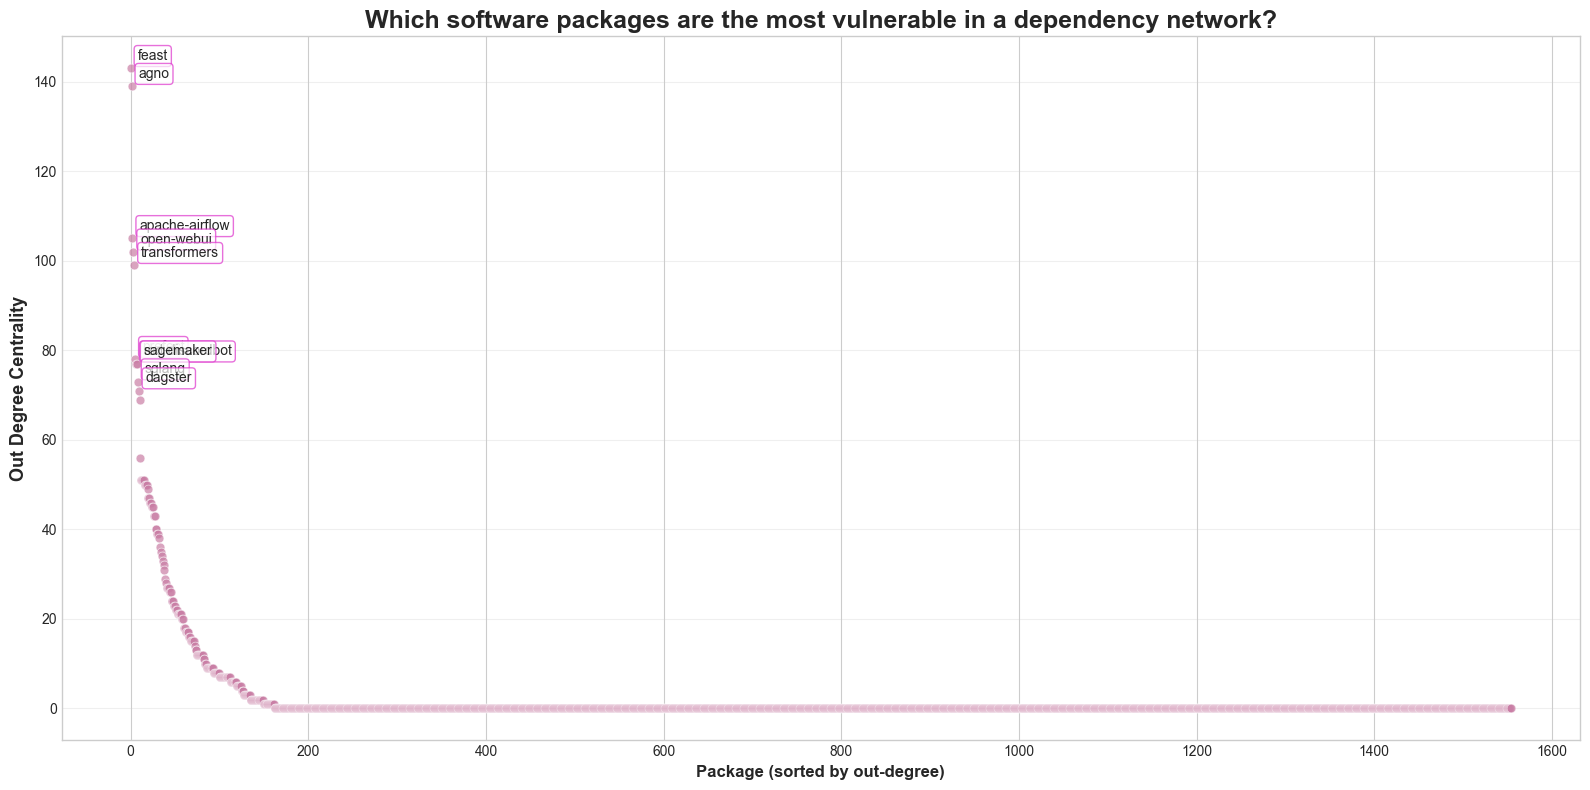

✅ Saved: outputs/plots/out_degree_impact_all.png
Gerando curva de out-degree (vulnerabilidade) para pacotes de IA...


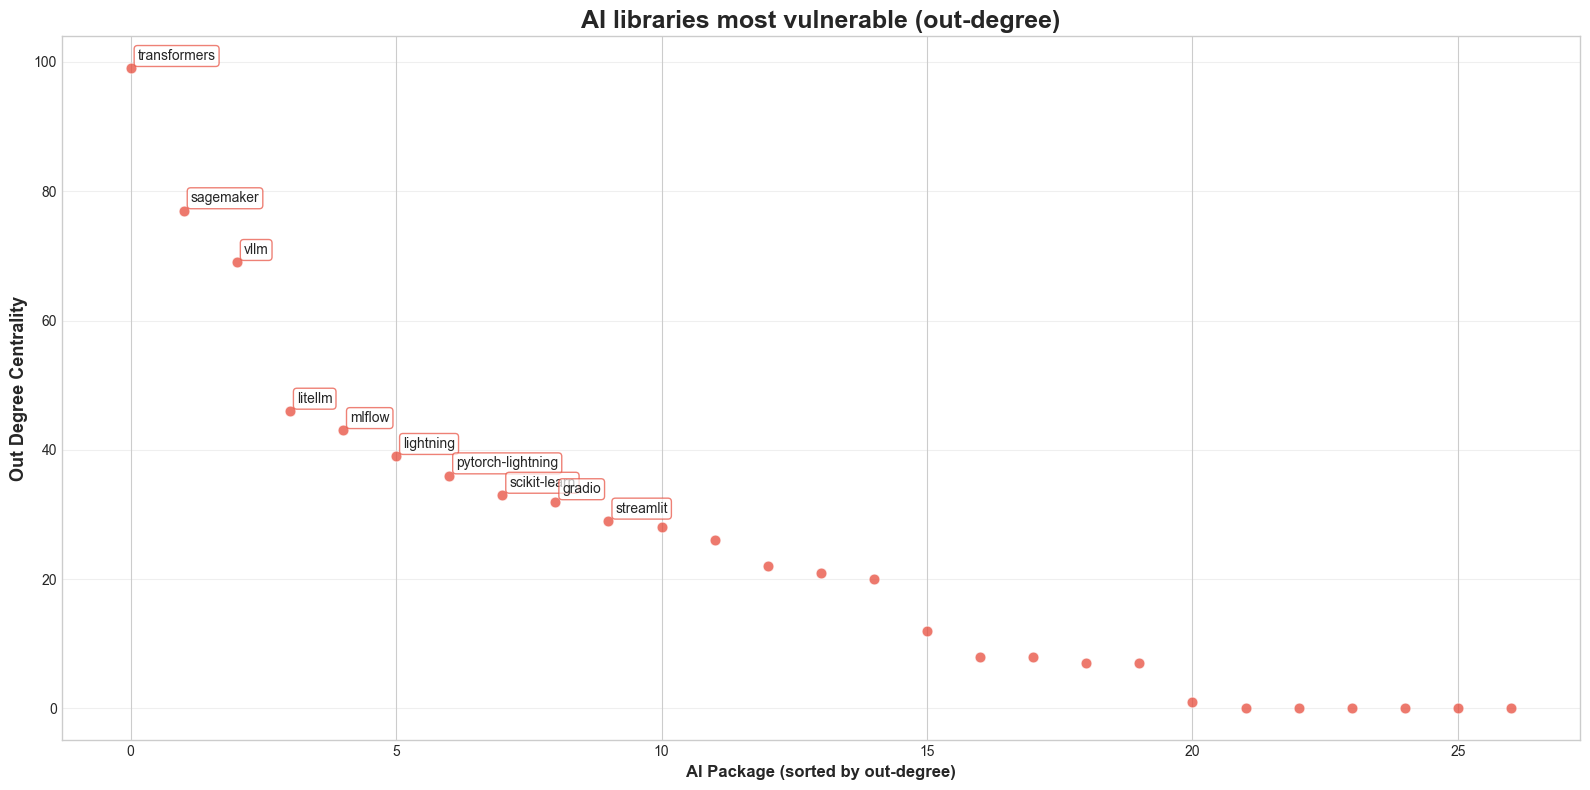

✅ Saved: outputs/plots/out_degree_impact_ai.png


In [39]:
# Out-degree impact curve — ALL packages
print('Gerando curva de out-degree (vulnerabilidade) para TODOS os pacotes...')

import matplotlib.pyplot as plt
import numpy as np

all_sorted = metrics_df.sort_values('out_degree', ascending=False).reset_index(drop=True)
xs = np.arange(len(all_sorted))
ys = all_sorted['out_degree'].fillna(0).values

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.scatter(xs, ys, s=40, c='#c97ea5', alpha=0.7, edgecolors='white', linewidths=0.5)
for i, row in all_sorted.head(10).iterrows():
    ax.annotate(row['package'], (i, row['out_degree']), xytext=(5, 6), textcoords='offset points', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.7, edgecolor='#d3c'))
ax.set_title('Which software packages are the most vulnerable in a dependency network?', fontsize=18, fontweight='bold')
ax.set_ylabel('Out Degree Centrality', fontsize=13, fontweight='bold')
ax.set_xlabel('Package (sorted by out-degree)', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/plots/out_degree_impact_all.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: outputs/plots/out_degree_impact_all.png')

# Out-degree impact curve — AI only
print('Gerando curva de out-degree (vulnerabilidade) para pacotes de IA...')
ai_sorted = metrics_df[metrics_df['is_ai_lib']].sort_values('out_degree', ascending=False).reset_index(drop=True)
if len(ai_sorted) > 0:
    xs = np.arange(len(ai_sorted))
    ys = ai_sorted['out_degree'].fillna(0).values
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.scatter(xs, ys, s=60, c='#e74c3c', alpha=0.75, edgecolors='white', linewidths=0.6)
    for i, row in ai_sorted.head(10).iterrows():
        ax.annotate(row['package'], (i, row['out_degree']), xytext=(5, 6), textcoords='offset points', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.7, edgecolor='#e74c3c'))
    ax.set_title('AI libraries most vulnerable (out-degree)', fontsize=18, fontweight='bold')
    ax.set_ylabel('Out Degree Centrality', fontsize=13, fontweight='bold')
    ax.set_xlabel('AI Package (sorted by out-degree)', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('outputs/plots/out_degree_impact_ai.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('✅ Saved: outputs/plots/out_degree_impact_ai.png')
else:
    print('⚠️ Não há pacotes de IA suficientes para o gráfico.')

## 🎯 5.11. Degree vs Betweenness (Single point of failure)

Gerando scatter Degree vs Betweenness (ALL)...


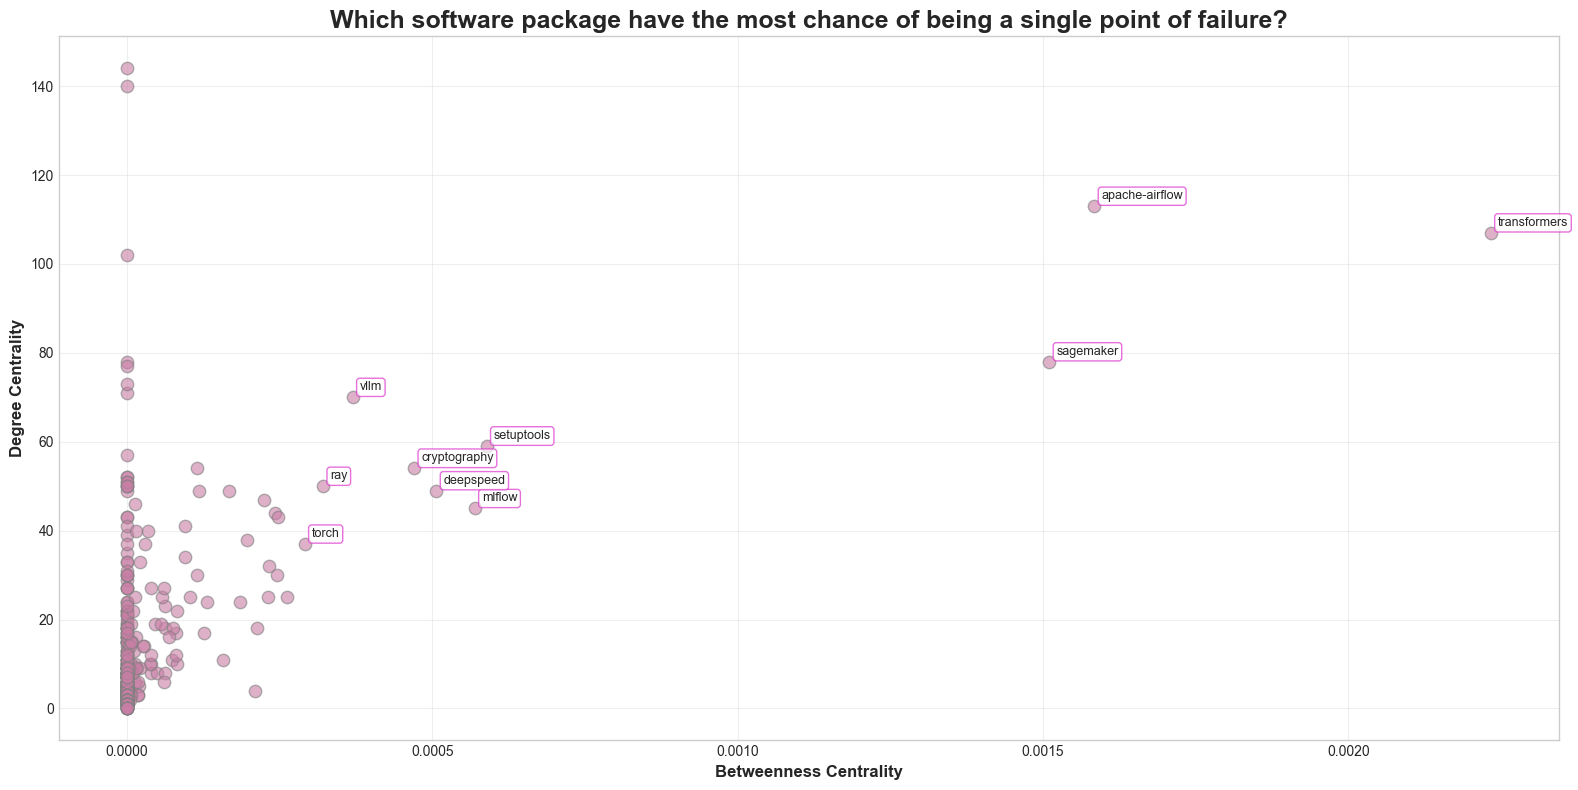

✅ Saved: outputs/plots/degree_vs_betweenness_all.png
Gerando scatter Degree vs Betweenness (AI)...


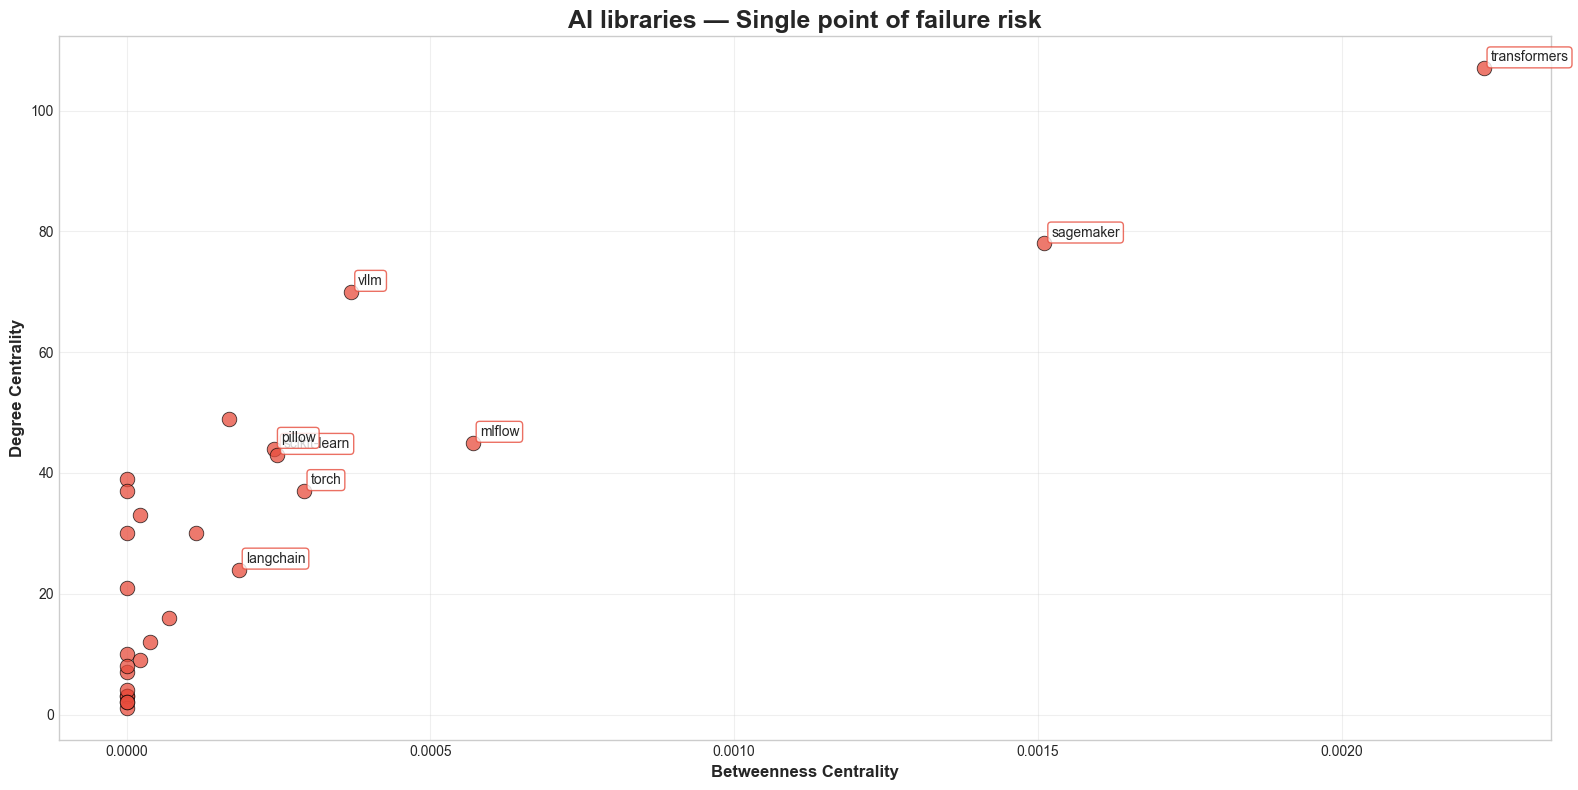

✅ Saved: outputs/plots/degree_vs_betweenness_ai.png


In [40]:
# Scatter ALL
print('Gerando scatter Degree vs Betweenness (ALL)...')
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.scatter(metrics_df['betweenness'], metrics_df['degree'], c='#c97ea5', s=80, alpha=0.6, edgecolors='gray')
ax.set_xlabel('Betweenness Centrality', fontsize=12, fontweight='bold')
ax.set_ylabel('Degree Centrality', fontsize=12, fontweight='bold')
ax.set_title('Which software package have the most chance of being a single point of failure?', fontsize=18, fontweight='bold')
ax.grid(alpha=0.3)
# Anotar top 10 por betweenness
for _, row in metrics_df.nlargest(10, 'betweenness').iterrows():
    ax.annotate(row['package'], (row['betweenness'], row['degree']), xytext=(5,5), textcoords='offset points', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.7, edgecolor='#d3c'))
plt.tight_layout()
plt.savefig('outputs/plots/degree_vs_betweenness_all.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: outputs/plots/degree_vs_betweenness_all.png')

# Scatter AI
print('Gerando scatter Degree vs Betweenness (AI)...')
ai_metrics = metrics_df[metrics_df['is_ai_lib']]
if len(ai_metrics) > 0:
    fig, ax = plt.subplots(1,1, figsize=(16,8))
    ax.scatter(ai_metrics['betweenness'], ai_metrics['degree'], c='#e74c3c', s=110, alpha=0.75, edgecolors='black', linewidths=0.6)
    ax.set_xlabel('Betweenness Centrality', fontsize=12, fontweight='bold')
    ax.set_ylabel('Degree Centrality', fontsize=12, fontweight='bold')
    ax.set_title('AI libraries — Single point of failure risk', fontsize=18, fontweight='bold')
    ax.grid(alpha=0.3)
    for _, row in ai_metrics.nlargest(8, 'betweenness').iterrows():
        ax.annotate(row['package'], (row['betweenness'], row['degree']), xytext=(5,5), textcoords='offset points', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.8, edgecolor='#e74c3c'))
    plt.tight_layout()
    plt.savefig('outputs/plots/degree_vs_betweenness_ai.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('✅ Saved: outputs/plots/degree_vs_betweenness_ai.png')
else:
    print('⚠️ Não há pacotes de IA suficientes para o gráfico.')

## 📈 7.5. Additional ecosystem-style figures

Cumulative vulnerabilities over time by severity...


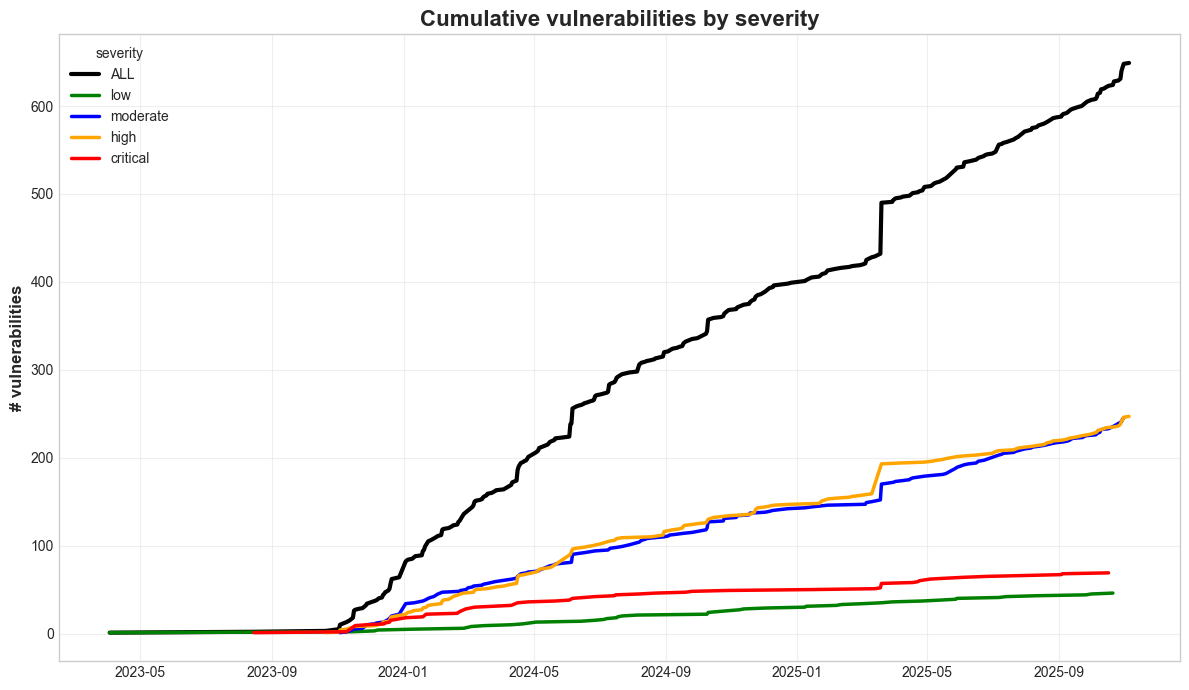

✅ Saved: outputs/plots/cumulative_by_severity.png


In [42]:
# Cumulative vulnerabilities over time by severity (ALL)
print('Cumulative vulnerabilities over time by severity...')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use disclosed_date; drop NA
v_time = vulns_net[vulns_net['disclosed_date'].notna()].copy()
v_time['date'] = pd.to_datetime(v_time['disclosed_date'])

severity_order = ['low', 'moderate', 'high', 'critical']
colors = {'low': 'green', 'moderate': 'blue', 'high': 'orange', 'critical': 'red'}

fig, ax = plt.subplots(1,1, figsize=(12,7))

# Total line (ALL)
all_series = v_time.groupby('date').size().sort_index().cumsum()
ax.plot(all_series.index, all_series.values, color='black', linewidth=3, label='ALL')

for sev in severity_order:
    tmp = v_time[v_time['severity'].str.lower() == sev]
    if len(tmp) == 0:
        continue
    s = tmp.groupby('date').size().sort_index().cumsum()
    ax.plot(s.index, s.values, color=colors[sev], linewidth=2.5, label=sev)

ax.set_title('Cumulative vulnerabilities by severity', fontsize=16, fontweight='bold')
ax.set_ylabel('# vulnerabilities', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(title='severity')
plt.tight_layout()
plt.savefig('outputs/plots/cumulative_by_severity.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: outputs/plots/cumulative_by_severity.png')

Box-style distribution of vulnerabilities per package by severity...


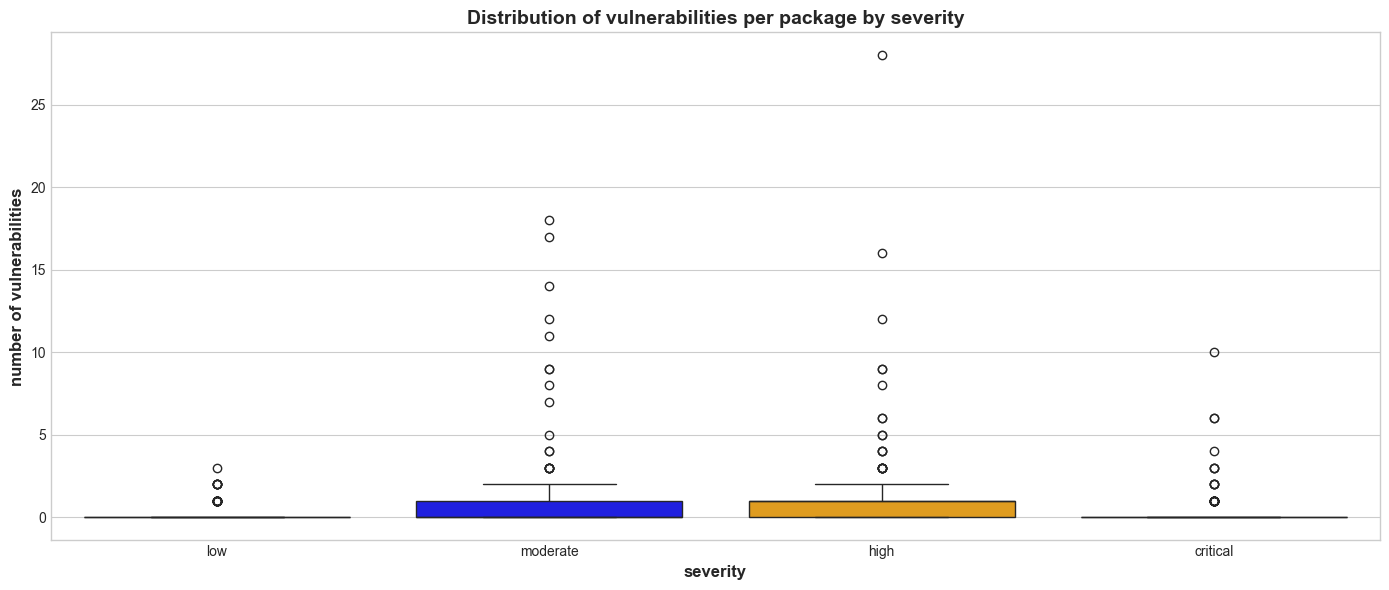

✅ Saved: outputs/plots/vuln_per_package_by_severity_box.png


In [43]:
# Number of vulnerabilities per package by severity (box-style)
print('Box-style distribution of vulnerabilities per package by severity...')

# Count CVEs by package+severity
counts = (vulns_net.groupby(['package_lower', 'severity'])
                     .agg(vuln_count=('cve','nunique'))
                     .reset_index())

# Pivot to severity columns then melt to keep missing as 0
pivot = counts.pivot(index='package_lower', columns='severity', values='vuln_count').fillna(0)
plot_df = pivot.melt(value_name='vuln_count', var_name='severity').dropna()

fig, ax = plt.subplots(1,1, figsize=(14,6))
import seaborn as sns
sns.boxplot(data=plot_df, x='severity', y='vuln_count', order=['low','moderate','high','critical'], ax=ax, palette=['green','blue','orange','red'])
ax.set_xlabel('severity', fontsize=12, fontweight='bold')
ax.set_ylabel('number of vulnerabilities', fontsize=12, fontweight='bold')
ax.set_title('Distribution of vulnerabilities per package by severity', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/plots/vuln_per_package_by_severity_box.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: outputs/plots/vuln_per_package_by_severity_box.png')

Time-to-fix (weeks) by year...


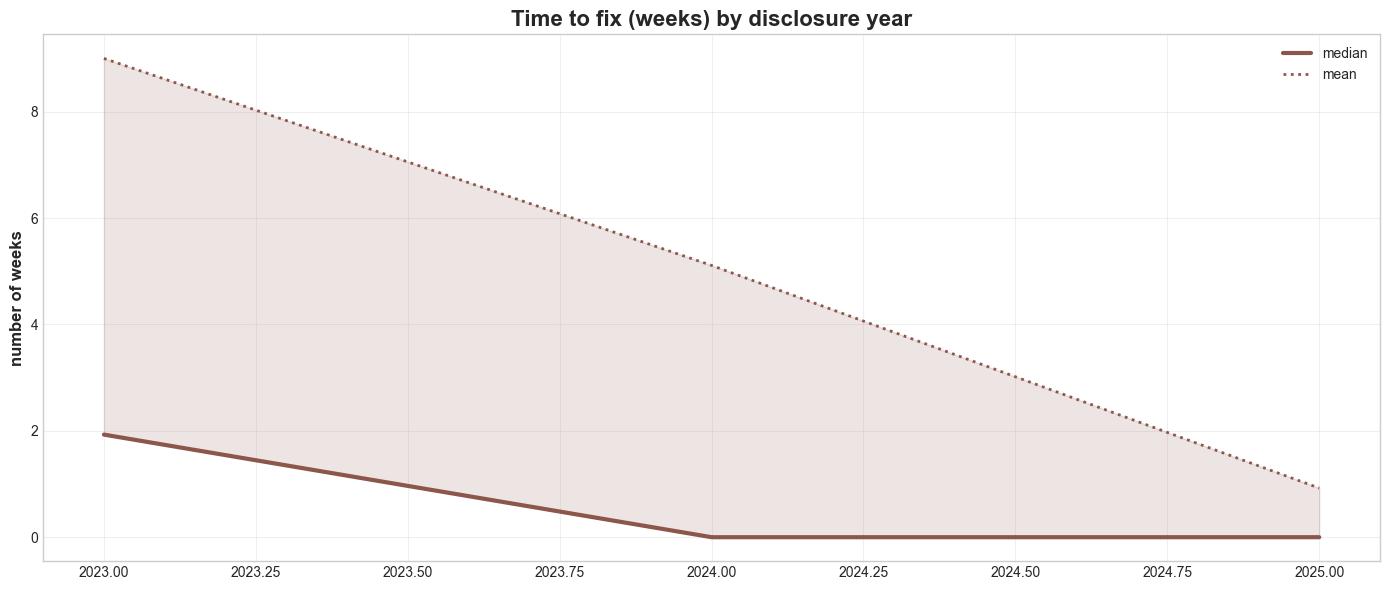

✅ Saved: outputs/plots/ttf_weeks_by_year.png


In [44]:
# Time-to-fix in weeks by year (median vs mean)
print('Time-to-fix (weeks) by year...')

vt = vulns_net.copy()
vt['ttf_weeks'] = (vt['time_to_fix_from_disclosure_days'] / 7.0).astype(float)
vt = vt[vt['ttf_weeks'].notna() & (vt['ttf_weeks'] >= 0)]
vt['year'] = vt['disclosed_date'].dt.year

agg = vt.groupby('year')['ttf_weeks'].agg(['median','mean']).reset_index()

fig, ax = plt.subplots(1,1, figsize=(14,6))
ax.plot(agg['year'], agg['median'], color='#8c564b', linewidth=3, label='median')
ax.plot(agg['year'], agg['mean'], color='#8c564b', linewidth=2, linestyle='dotted', label='mean')
ax.fill_between(agg['year'], agg['median'], agg['mean'], color='#8c564b', alpha=0.15)
ax.set_title('Time to fix (weeks) by disclosure year', fontsize=16, fontweight='bold')
ax.set_ylabel('number of weeks', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig('outputs/plots/ttf_weeks_by_year.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: outputs/plots/ttf_weeks_by_year.png')

In [50]:
# Ensure exposure and tree depth (run once before the last two plots)
import networkx as nx
from collections import deque

# direct/indirect exposure
direct_exposure = {}
indirect_exposure = {}
for node in G.nodes():
    direct_exposure[node] = len(list(G.predecessors(node))) if node in G else 0
    try:
        indirect_exposure[node] = len(nx.ancestors(G, node))
    except Exception:
        indirect_exposure[node] = 0

metrics_df['direct_exposure'] = metrics_df['package'].map(direct_exposure).fillna(0).astype(int)
metrics_df['indirect_exposure'] = metrics_df['package'].map(indirect_exposure).fillna(0).astype(int)

# tree depth
def calc_tree_depths(graph):
    depths = {}
    for n in graph.nodes():
        mx = 0
        q = deque([(n, 0)])
        seen = {n}
        while q:
            cur, d = q.popleft()
            mx = max(mx, d)
            for nb in graph.successors(cur):
                if nb not in seen:
                    seen.add(nb)
                    q.append((nb, d + 1))
        depths[n] = mx
    return depths

tree_depths = calc_tree_depths(G)
metrics_df['tree_depth'] = metrics_df['package'].map(tree_depths).fillna(0).astype(int)

Direct vs Indirect exposure — aggregated bars...


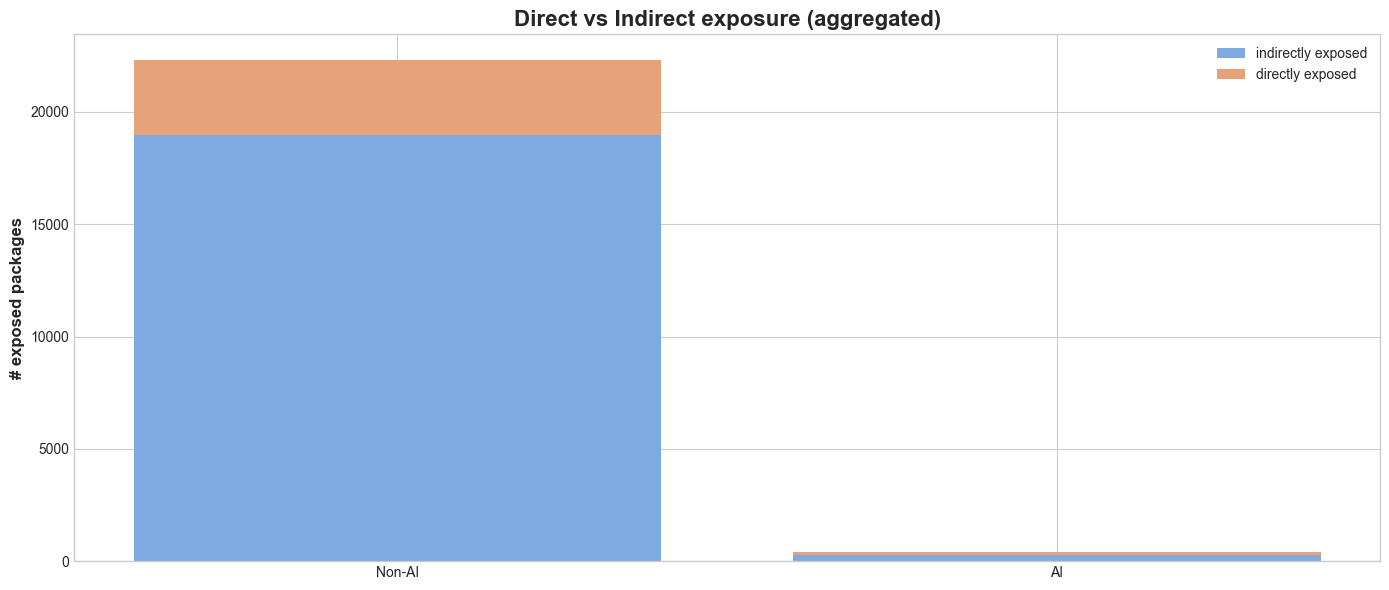

✅ Saved: outputs/plots/exposed_direct_vs_indirect_stacked.png


In [51]:
# Direct vs Indirect — exposed packages (aggregated)
print('Direct vs Indirect exposure — aggregated bars...')

exp_df = metrics_df[['package','direct_exposure','indirect_exposure','is_ai_lib']].copy()
exp_df = exp_df.fillna(0)

summary = pd.DataFrame({
    'category': ['Non-AI','AI'],
    'direct': [exp_df[~exp_df['is_ai_lib']]['direct_exposure'].sum(), exp_df[exp_df['is_ai_lib']]['direct_exposure'].sum()],
    'indirect': [exp_df[~exp_df['is_ai_lib']]['indirect_exposure'].sum(), exp_df[exp_df['is_ai_lib']]['indirect_exposure'].sum()]
})

fig, ax = plt.subplots(1,1, figsize=(14,6))
ax.bar(summary['category'], summary['indirect'], color='#7ea9e1', label='indirectly exposed')
ax.bar(summary['category'], summary['direct'], bottom=summary['indirect'], color='#e6a37a', label='directly exposed')
ax.set_ylabel('# exposed packages', fontsize=12, fontweight='bold')
ax.set_title('Direct vs Indirect exposure (aggregated)', fontsize=16, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('outputs/plots/exposed_direct_vs_indirect_stacked.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: outputs/plots/exposed_direct_vs_indirect_stacked.png')

Exposed packages by dependency tree depth...


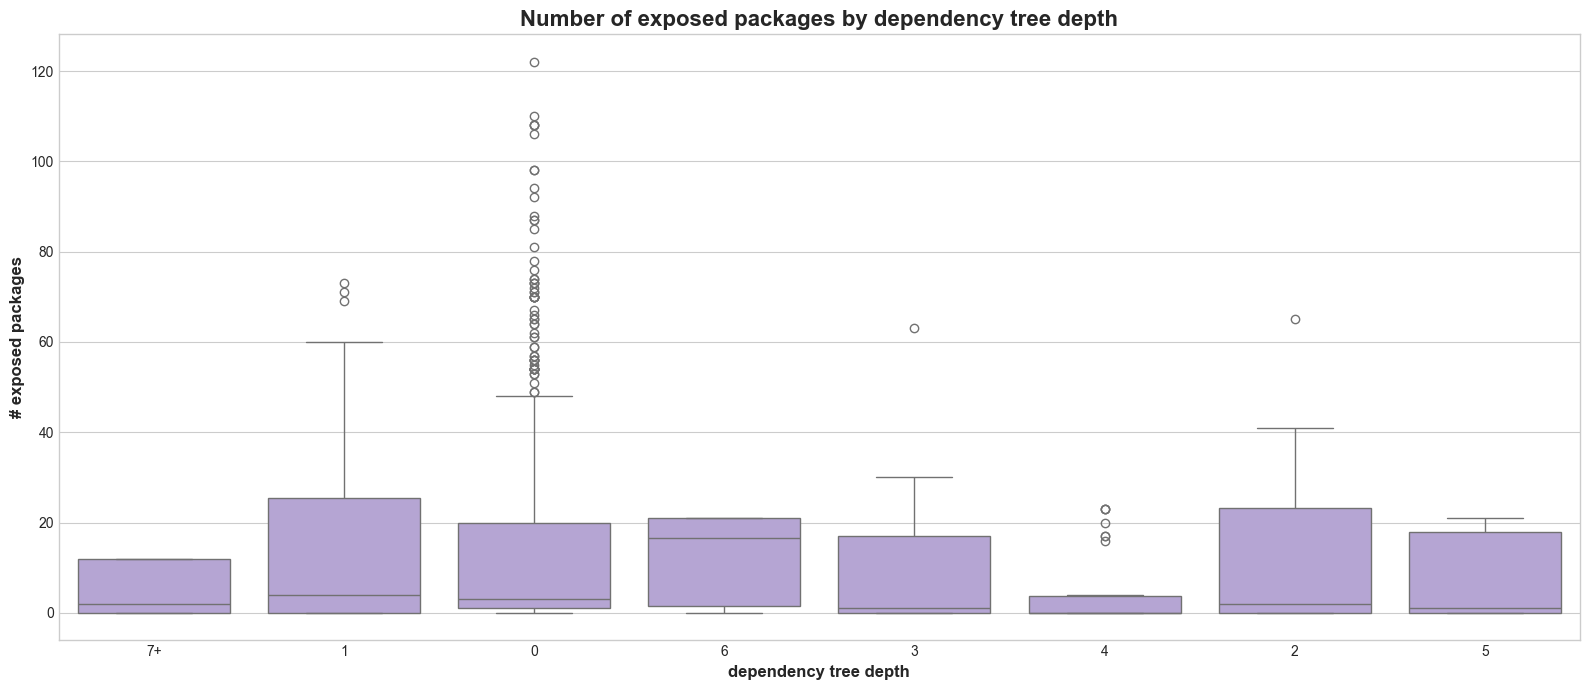

✅ Saved: outputs/plots/exposed_by_depth_box.png


In [52]:
# Exposed packages by dependency tree depth (boxplot)
print('Exposed packages by dependency tree depth...')

# Ensure depth exists
if 'tree_depth' not in metrics_df.columns:
    metrics_df['tree_depth'] = metrics_df['package'].map(tree_depths).fillna(0)

exp_depth = metrics_df[['package','tree_depth','indirect_exposure']].copy().dropna()
exp_depth['depth_category'] = exp_depth['tree_depth'].astype(int).clip(upper=7).astype(str)
exp_depth['depth_category'] = exp_depth['depth_category'].replace({'7':'7+'})

import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(16,7))
sns.boxplot(data=exp_depth, x='depth_category', y='indirect_exposure', ax=ax, color='#b39ddb')
ax.set_xlabel('dependency tree depth', fontsize=12, fontweight='bold')
ax.set_ylabel('# exposed packages', fontsize=12, fontweight='bold')
ax.set_title('Number of exposed packages by dependency tree depth', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/plots/exposed_by_depth_box.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: outputs/plots/exposed_by_depth_box.png')

## 🔗 5.12. Dependency reach curve (direct vs indirect) — ALL vs AI

Computing dependency reach curves (direct vs indirect)...
  roots ALL: 162 | roots AI: 21


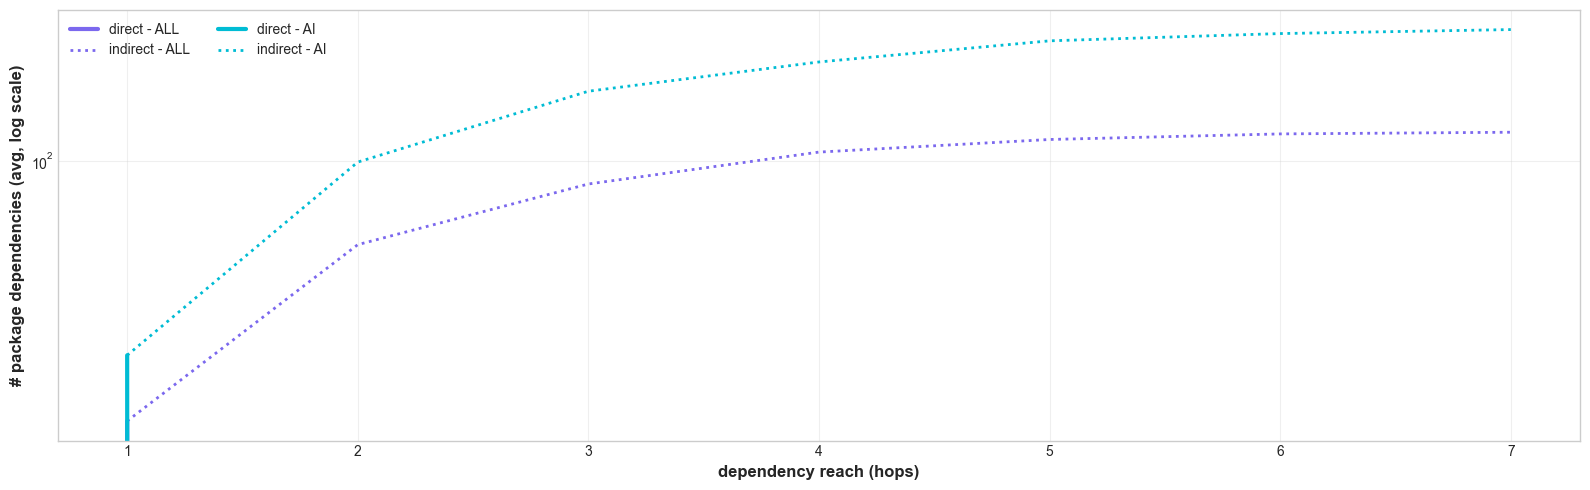

✅ Saved: outputs/plots/dependency_reach_curve.png


In [53]:
# Dependency reach as a function of hop distance (log scale)
print('Computing dependency reach curves (direct vs indirect)...')

import numpy as np
import matplotlib.pyplot as plt
from collections import deque

MAX_DEPTH = 7
SAMPLE_N = 300  # amostragem para performance

# raiz: nós com out-degree > 0
roots_all = [n for n, d in G.out_degree() if d > 0]
if len(roots_all) > SAMPLE_N:
    roots_all = roots_all[:SAMPLE_N]

roots_ai = [n for n in roots_all if n in AI_LIBS]
if len(roots_ai) > SAMPLE_N:
    roots_ai = roots_ai[:SAMPLE_N]

print(f'  roots ALL: {len(roots_all)} | roots AI: {len(roots_ai)}')

def avg_reach(nodes, graph, max_depth):
    if not nodes:
        return np.zeros(max_depth+1), np.zeros(max_depth+1)
    cum_by_d = np.zeros(max_depth+1, dtype=float)
    direct_by_d = np.zeros(max_depth+1, dtype=float)
    for src in nodes:
        visited = {src}
        layer = {src}
        cum = 0
        for d in range(1, max_depth+1):
            next_layer = set()
            for u in layer:
                for v in graph.successors(u):
                    if v not in visited:
                        visited.add(v)
                        next_layer.add(v)
            if d == 1:
                direct_by_d[d] += len(next_layer)
            cum += len(next_layer)
            cum_by_d[d] += cum
            layer = next_layer
            if not layer:
                # mantém valores acumulados constantes para profundidades seguintes
                for dd in range(d+1, max_depth+1):
                    cum_by_d[dd] += cum
                break
    # média por raiz
    cum_by_d /= max(1, len(nodes))
    direct_by_d /= max(1, len(nodes))
    return cum_by_d, direct_by_d

# ALL
all_cum, all_direct = avg_reach(roots_all, G, MAX_DEPTH)
# AI
ai_cum, ai_direct = avg_reach(roots_ai, G, MAX_DEPTH)

# Plot
fig, ax = plt.subplots(1,1, figsize=(16,5))
xs = np.arange(1, MAX_DEPTH+1)
ax.set_yscale('log')
ax.plot(xs, all_direct[1:], color='#7b68ee', linewidth=3, label='direct - ALL')
ax.plot(xs, all_cum[1:], color='#7b68ee', linewidth=2, linestyle='dotted', label='indirect - ALL')
ax.plot(xs, ai_direct[1:], color='#00bcd4', linewidth=3, label='direct - AI')
ax.plot(xs, ai_cum[1:], color='#00bcd4', linewidth=2, linestyle='dotted', label='indirect - AI')
ax.set_xlabel('dependency reach (hops)', fontsize=12, fontweight='bold')
ax.set_ylabel('# package dependencies (avg, log scale)', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(loc='best', ncols=2)
plt.tight_layout()
plt.savefig('outputs/plots/dependency_reach_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: outputs/plots/dependency_reach_curve.png')

## 🧩 9. CWE Influence Network (2023-11-01 → 2025-11-01)

In [54]:
# Parameters
CWE_SOURCE_CSV = 'outputs/top_pypi_snyk_timeline_20221112_20251112.csv'
DATE_START = '2023-11-01'
DATE_END   = '2025-11-01'
TOP_K_CWE  = 30
MIN_PAIR_COUNT = 3
MIN_COND_P = 0.15

import os, re, pandas as pd, numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

print(f'Loading {CWE_SOURCE_CSV}')
df_src = pd.read_csv(CWE_SOURCE_CSV)
for col in ['disclosed_date','first_affected_date','mitigation_date']:
    if col in df_src.columns:
        df_src[col] = pd.to_datetime(df_src[col], errors='coerce')

mask = (df_src['disclosed_date'] >= pd.to_datetime(DATE_START)) & (df_src['disclosed_date'] <= pd.to_datetime(DATE_END))
df = df_src.loc[mask].copy()
print(f'Rows after date filter: {len(df)}')

def parse_cwes(val):
    if pd.isna(val):
        return []
    parts = re.split(r'[;,\s]+', str(val))
    out = []
    for p in parts:
        p = p.strip()
        if not p: continue
        up = p.upper()
        if up.startswith('CWE-'): out.append(up)
    return list(dict.fromkeys(out))

if 'cwes' in df.columns:
    df['cwe_list'] = df['cwes'].apply(parse_cwes)
elif 'CWE' in df.columns:
    df['cwe_list'] = df['CWE'].apply(parse_cwes)
else:
    df['cwe_list'] = [[] for _ in range(len(df))]

all_cwes = [c for lst in df['cwe_list'] for c in lst]
freq = Counter(all_cwes)
top_cwes = [c for c,_ in freq.most_common(TOP_K_CWE)]
print(f'Top-K CWE size: {len(top_cwes)}')

pair_count = Counter()
co_rows = 0
for lst in df['cwe_list']:
    lst = [c for c in lst if c in top_cwes]
    if len(lst) >= 2:
        co_rows += 1
        seen = sorted(set(lst))
        for i in range(len(seen)):
            for j in range(i+1, len(seen)):
                a, b = seen[i], seen[j]
                pair_count[(a,b)] += 1
                pair_count[(b,a)] += 1
print(f'Rows with >=2 CWEs: {co_rows}')

G_cwe = nx.DiGraph()
for c in top_cwes:
    G_cwe.add_node(c, freq=freq[c])

for (a,b), cnt in pair_count.items():
    if freq[a] > 0:
        p = cnt / freq[a]
        if cnt >= MIN_PAIR_COUNT and p >= MIN_COND_P:
            G_cwe.add_edge(a, b, weight=p, count=cnt)

print(f'CWE graph: nodes={G_cwe.number_of_nodes()} edges={G_cwe.number_of_edges()}')
os.makedirs('outputs/summaries', exist_ok=True)


Loading outputs/top_pypi_snyk_timeline_20221112_20251112.csv
Rows after date filter: 553
Top-K CWE size: 30
Rows with >=2 CWEs: 21
CWE graph: nodes=30 edges=5


In [55]:
# Centralities and communities
try:
    pr = nx.pagerank(G_cwe, weight='weight')
except Exception:
    pr = {n:0 for n in G_cwe.nodes()}
out_w = {n: sum(d.get('weight',1.0) for _,_,d in G_cwe.out_edges(n, data=True)) for n in G_cwe.nodes()}
in_w  = {n: sum(d.get('weight',1.0) for _,_,d in G_cwe.in_edges(n, data=True)) for n in G_cwe.nodes()}
UG = G_cwe.to_undirected()
try:
    btw = nx.betweenness_centrality(UG, weight='weight', normalized=True)
except Exception:
    btw = {n:0 for n in G_cwe.nodes()}
from networkx.algorithms import community
comms = list(community.greedy_modularity_communities(UG, weight='weight')) if UG.number_of_edges()>0 else []
node2comm = {}
for i, comm in enumerate(comms):
    for n in comm:
        node2comm[n] = i
rows = []
for n in G_cwe.nodes():
    rows.append({'cwe':n,'freq':G_cwe.nodes[n].get('freq',0),'pagerank':pr.get(n,0),
                 'out_strength':out_w.get(n,0),'in_strength':in_w.get(n,0),'betweenness':btw.get(n,0),
                 'community':node2comm.get(n,-1)})
metrics_df_cwe = pd.DataFrame(rows).sort_values(['pagerank','out_strength'], ascending=False)
metrics_df_cwe.to_csv('outputs/summaries/cwe_metrics.csv', index=False)
# reach
reach = {}
for n in G_cwe.nodes():
    seen=set(); stack=[n]
    while stack:
        u=stack.pop()
        for v in G_cwe.successors(u):
            if v not in seen:
                seen.add(v); stack.append(v)
    reach[n]=len(seen)
metrics_df_cwe['reach_nodes']=metrics_df_cwe['cwe'].map(reach)
metrics_df_cwe.to_csv('outputs/summaries/cwe_metrics.csv', index=False)
print(metrics_df_cwe.head())


        cwe  freq  pagerank  out_strength  in_strength  betweenness  \
23  CWE-208     5  0.124563      0.600000     0.428571          0.0   
20  CWE-203     7  0.124563      0.428571     0.600000          0.0   
7   CWE-400    17  0.124563      0.294118     0.185185          0.0   
2   CWE-770    27  0.124563      0.185185     0.294118          0.0   
0    CWE-22    50  0.034571      0.000000     0.428571          0.0   

    community  reach_nodes  
23          2            2  
20          2            2  
7           0            2  
2           0            2  
0           1            0  


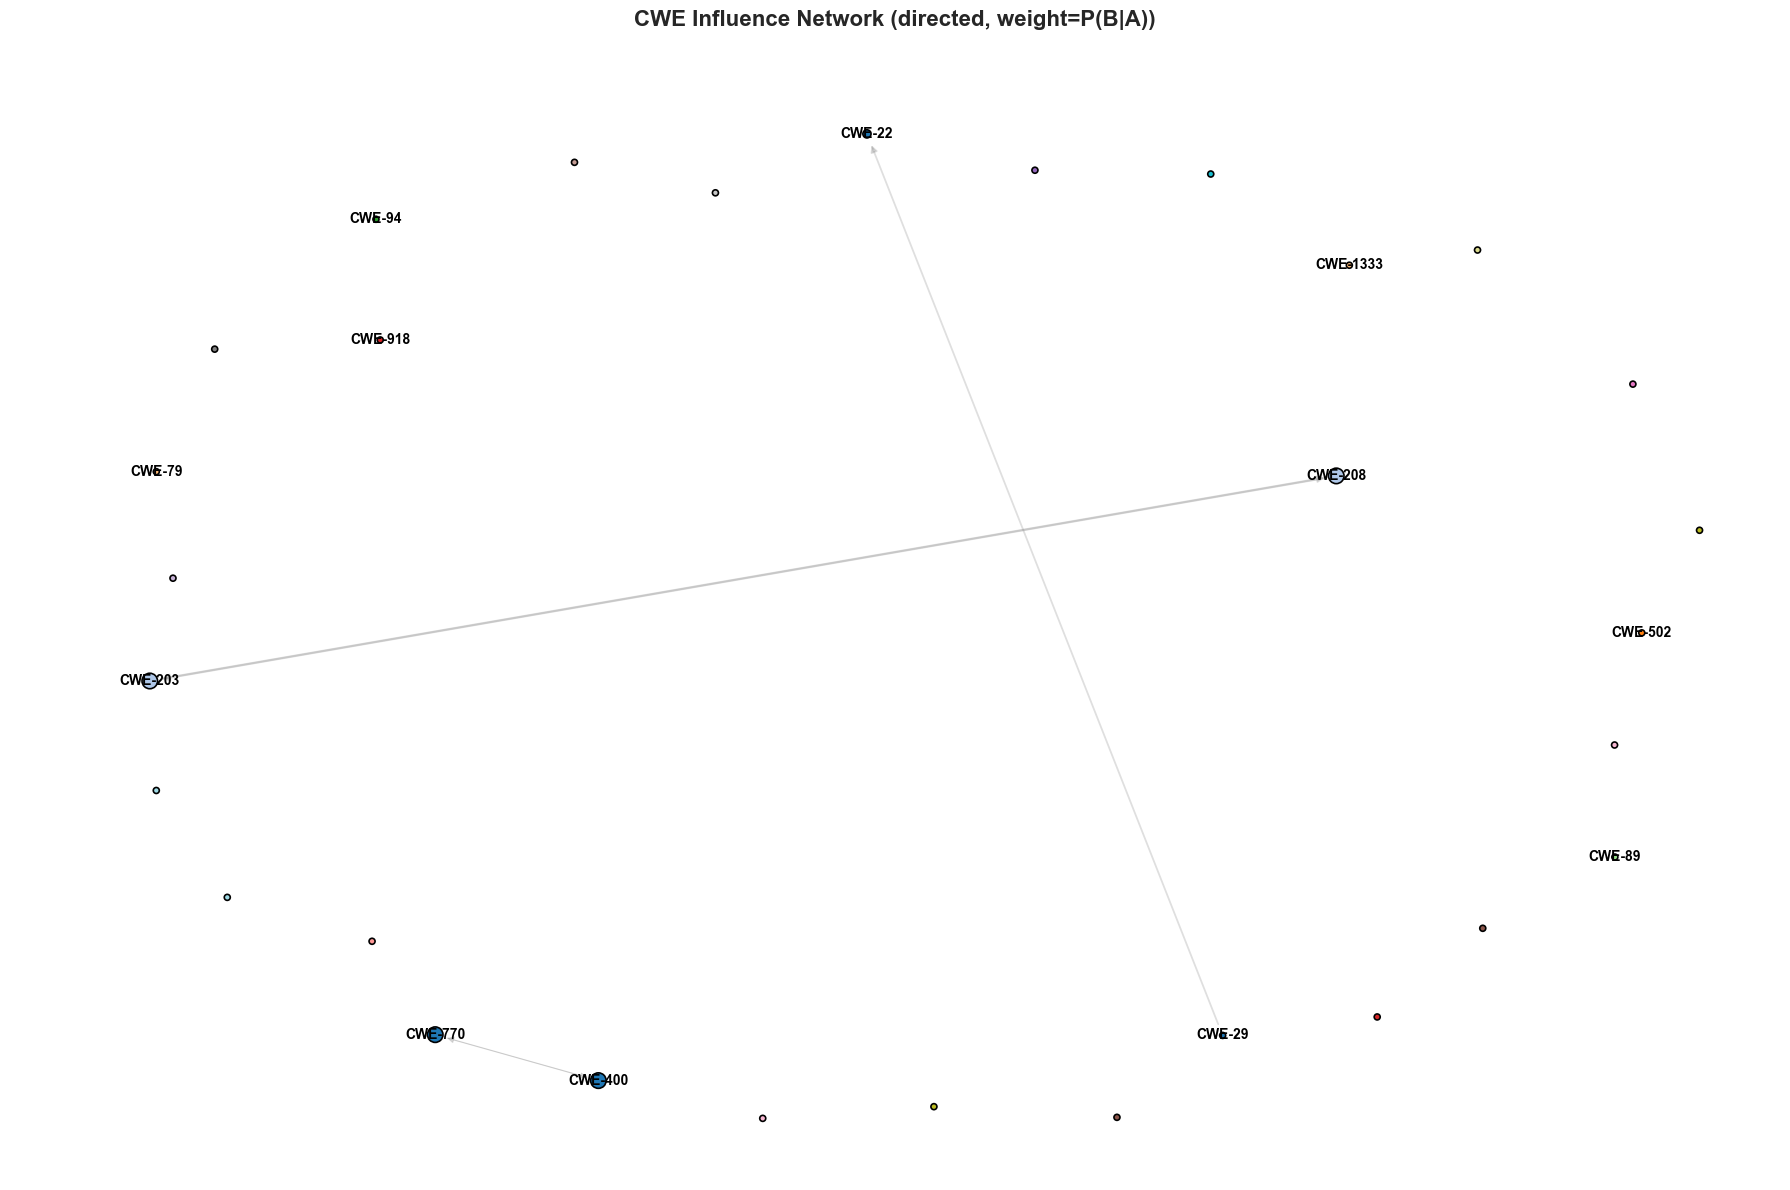

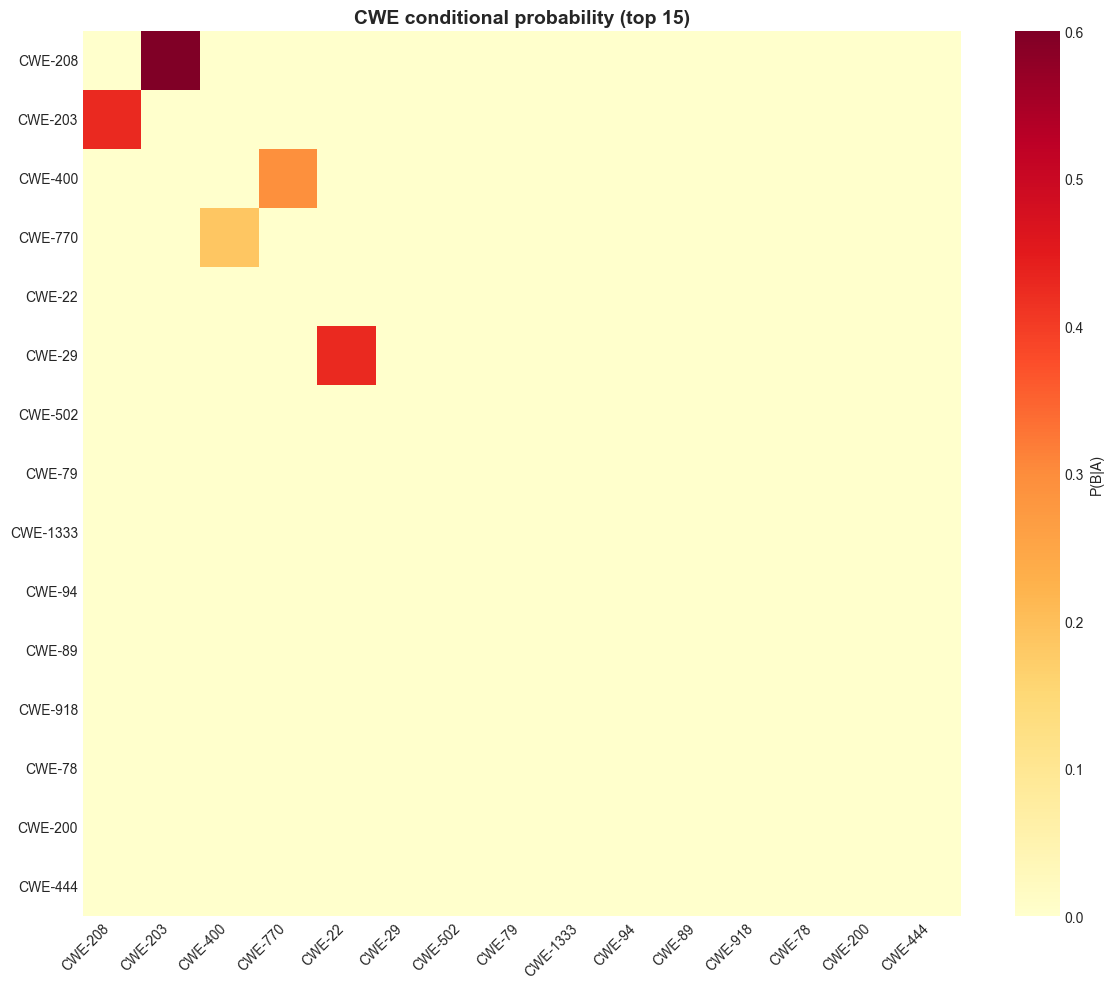

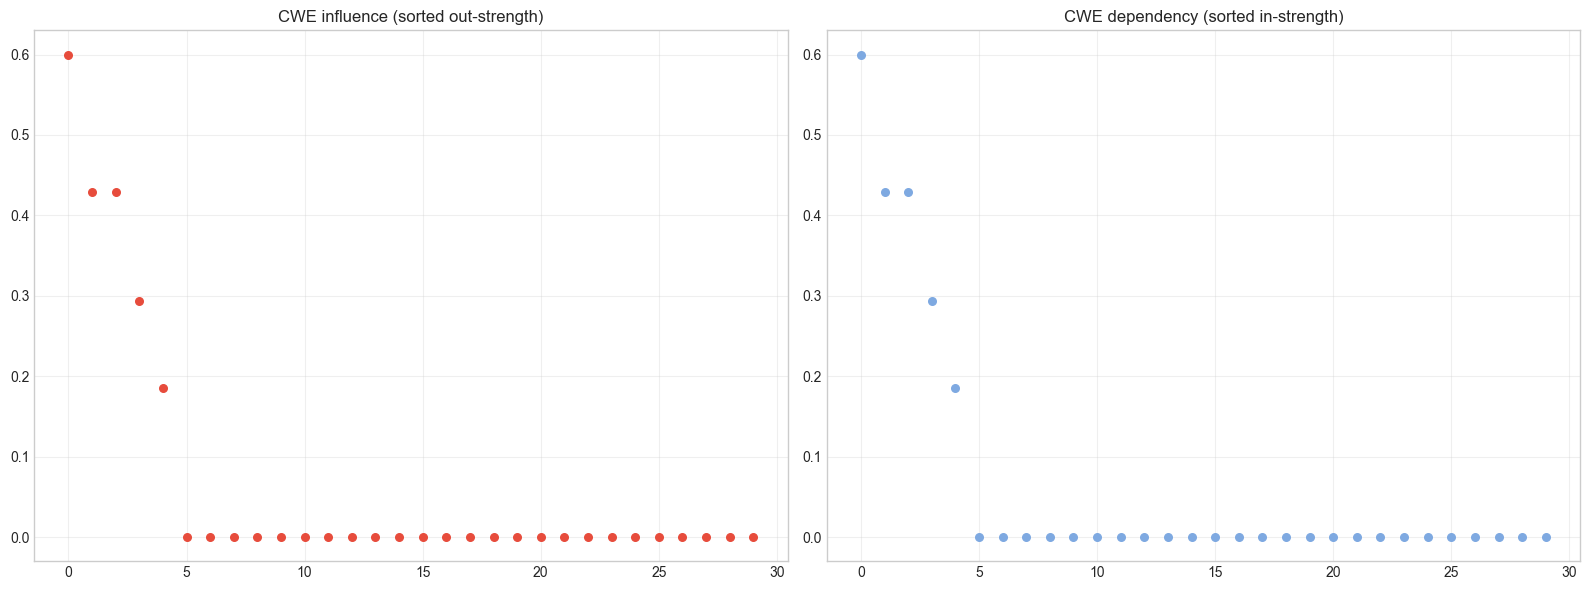

In [56]:
# Plots (network, heatmap, curves)
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
pos = nx.spring_layout(G_cwe, weight='weight', seed=42, k=2) if G_cwe.number_of_edges()>0 else {n:(i,0) for i,n in enumerate(G_cwe.nodes())}
num_c = (max(node2comm.values())+1) if node2comm else 1
cmap = plt.cm.tab20(np.linspace(0,1,max(1,num_c)))
node_color=[cmap[node2comm.get(n,0)] for n in G_cwe.nodes()]
node_size=[1000*(metrics_df_cwe.set_index('cwe').loc[n,'pagerank']+1e-4) for n in G_cwe.nodes()]
edge_w=[d.get('weight',0.1)*3 for _,_,d in G_cwe.edges(data=True)]
fig, ax = plt.subplots(1,1, figsize=(18,12))
nx.draw_networkx_edges(G_cwe,pos,alpha=0.25,width=edge_w,arrows=True,arrowstyle='-|>',arrowsize=10,edge_color='gray',ax=ax)
nx.draw_networkx_nodes(G_cwe,pos,node_color=node_color,node_size=node_size,edgecolors='black',linewidths=1.2,ax=ax)
labels={row['cwe']:row['cwe'] for _,row in metrics_df_cwe.head(12).iterrows()}
nx.draw_networkx_labels(G_cwe,pos,labels=labels,font_size=10,font_weight='bold',ax=ax)
ax.set_title('CWE Influence Network (directed, weight=P(B|A))',fontsize=16,fontweight='bold'); ax.axis('off')
plt.tight_layout(); plt.savefig('outputs/plots/cwe_influence_network.png',dpi=300,bbox_inches='tight'); plt.show()
# Heatmap top 15
N=min(15,len(metrics_df_cwe)); order=metrics_df_cwe.head(N)['cwe'].tolist(); import numpy as np
cond=np.zeros((N,N))
for i,a in enumerate(order):
    for j,b in enumerate(order):
        if G_cwe.has_edge(a,b): cond[i,j]=G_cwe.edges[a,b].get('weight',0)
fig, ax = plt.subplots(1,1, figsize=(12,10)); sns.heatmap(cond,xticklabels=order,yticklabels=order,cmap='YlOrRd',cbar_kws={'label':'P(B|A)'},ax=ax); plt.xticks(rotation=45,ha='right'); ax.set_title('CWE conditional probability (top 15)',fontsize=14,fontweight='bold'); plt.tight_layout(); plt.savefig('outputs/plots/cwe_conditional_heatmap.png',dpi=300,bbox_inches='tight'); plt.show()
# Curves
vals_out=np.sort(metrics_df_cwe['out_strength'].values)[::-1]; vals_in=np.sort(metrics_df_cwe['in_strength'].values)[::-1]
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6)); ax1.scatter(range(len(vals_out)),vals_out,c='#e74c3c',s=30); ax1.set_title('CWE influence (sorted out-strength)'); ax1.grid(alpha=0.3); ax2.scatter(range(len(vals_in)),vals_in,c='#7ea9e1',s=30); ax2.set_title('CWE dependency (sorted in-strength)'); ax2.grid(alpha=0.3); plt.tight_layout(); plt.savefig('outputs/plots/cwe_influence_dependency_curves.png',dpi=300,bbox_inches='tight'); plt.show()


## 🤖 10. AI libs: CWE influence × dependency reach (P-Impact)

Saved: outputs/summaries/ai_cwe_impact.csv


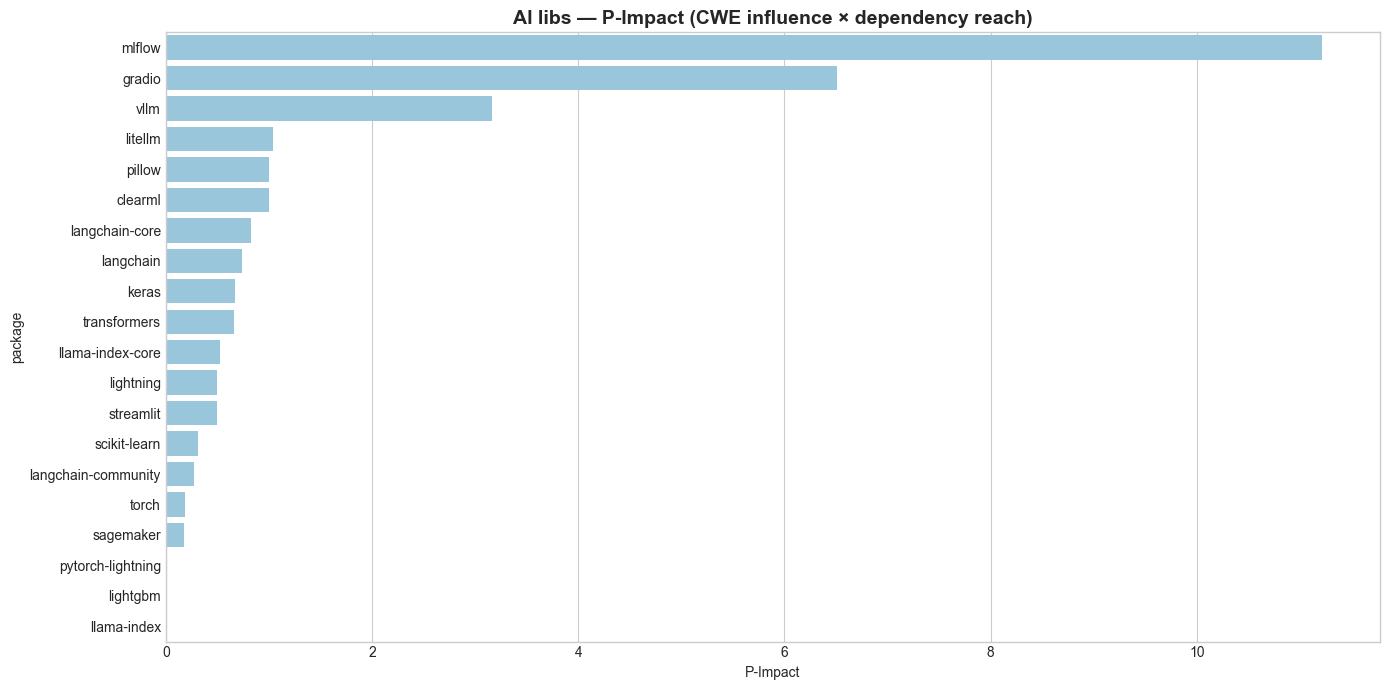

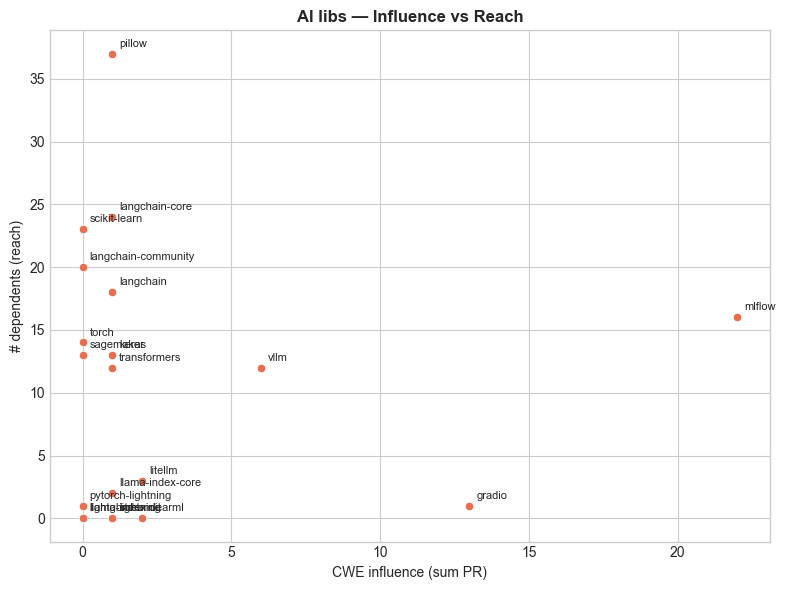

Top 10 AI libs to fix (by P-Impact):
           package   p_impact  dependent_reach  avg_depth  cwe_influence
11          mlflow  11.216216               16   2.687500           22.0
1           gradio   6.513514                1   1.000000           13.0
19            vllm   3.162162               12   2.916667            6.0
8          litellm   1.040541                3   1.000000            2.0
12          pillow   1.000000               37   1.486486            1.0
0          clearml   1.000000                0   0.000000            2.0
5   langchain-core   0.824324               24   3.375000            1.0
3        langchain   0.743243               18   3.111111            1.0
2            keras   0.675676               13   2.230769            1.0
18    transformers   0.662162               12   1.333333            1.0


In [58]:
# Inputs
SRC_TIMELINE = 'outputs/top_pypi_snyk_timeline_20221112_20251112.csv'
DEPS_CSV    = 'python_dependencies_edges.csv'
DATE_START  = '2023-11-01'
DATE_END    = '2025-11-01'
TOP_K_CWE   = 30
MIN_PAIR    = 3
MIN_P       = 0.10

import pandas as pd, numpy as np, re, networkx as nx, matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
from itertools import combinations

# Load & filter timeline
df = pd.read_csv(SRC_TIMELINE)
for col in ['disclosed_date','first_affected_date','mitigation_date']:
    if col in df.columns: df[col] = pd.to_datetime(df[col], errors='coerce')
mask = (df['disclosed_date']>=pd.to_datetime(DATE_START)) & (df['disclosed_date']<=pd.to_datetime(DATE_END))
df = df.loc[mask].copy()
df['package_lower'] = df['package'].str.lower()

# CWE parsing
def parse_cwes(val):
    if pd.isna(val): return []
    out=[]
    for p in re.split(r'[;,\s]+', str(val)):
        up=p.strip().upper()
        if up.startswith('CWE-'): out.append(up)
    return list(dict.fromkeys(out))
cwe_col = 'cwes' if 'cwes' in df.columns else ('CWE' if 'CWE' in df.columns else None)
df['cwe_list'] = df[cwe_col].apply(parse_cwes) if cwe_col else [[] for _ in range(len(df))]

# Build CWE influence graph (reuse logic)
all_cwes=[c for lst in df['cwe_list'] for c in lst]
freq=Counter(all_cwes)
top_cwes=[c for c,_ in freq.most_common(TOP_K_CWE)]
pair=Counter()
for lst in df['cwe_list']:
    lst=[c for c in lst if c in top_cwes]
    if len(lst)>=2:
        seen=sorted(set(lst))
        for i in range(len(seen)):
            for j in range(i+1,len(seen)):
                a,b=seen[i],seen[j]; pair[(a,b)]+=1; pair[(b,a)]+=1
G_cwe=nx.DiGraph()
for c in top_cwes: G_cwe.add_node(c, freq=freq[c])
for (a,b),cnt in pair.items():
    if freq[a]>0:
        p=cnt/freq[a]
        if cnt>=MIN_PAIR and p>=MIN_P: G_cwe.add_edge(a,b,weight=p,count=cnt)
try: pr = nx.pagerank(G_cwe, weight='weight')
except: pr={n:0 for n in G_cwe.nodes()}
# normalize PR to [0,1]
if pr: 
    arr=np.array(list(pr.values())); mn, mx = arr.min(), arr.max();
    pr_norm={k: (v-mn)/(mx-mn+1e-12) for k,v in pr.items()}
else:
    pr_norm={n:0 for n in G_cwe.nodes()}

# AI libs only rows
ai_df = df[df['package_lower'].isin({p.lower() for p in AI_LIBS})].copy()
# per-package CWE influence score (sum PR of its CWEs)
def influence_for(lst): return float(np.sum([pr_norm.get(c,0) for c in lst]))
pkg_infl = (ai_df.groupby('package_lower')['cwe_list']
            .apply(lambda col: influence_for([c for lst in col for c in lst]))
            .reset_index().rename(columns={'cwe_list':'cwe_influence'}))

# Dependency graph and reverse reach to dependents
deps = pd.read_csv(DEPS_CSV)
deps['source']=deps['source'].astype(str).str.lower(); deps['target']=deps['target'].astype(str).str.lower()
DG = nx.DiGraph(); DG.add_edges_from(deps[['source','target']].itertuples(index=False,name=None))
RG = DG.reverse(copy=True)  # edges: lib -> dependents
reach_rows=[]
for pkg in sorted(set(pkg_infl['package_lower'])):
    if pkg not in RG: reach_rows.append((pkg,0,0.0)); continue
    # BFS to all dependents and compute mean depth
    from collections import deque
    seen=set([pkg]); q=deque([(pkg,0)]); total=0; dsum=0
    while q:
        u,d=q.popleft()
        for v in RG.successors(u):
            if v not in seen:
                seen.add(v); q.append((v,d+1)); total+=1; dsum+=d+1
    avg_depth = (dsum/total) if total>0 else 0.0
    reach_rows.append((pkg,total,avg_depth))
reach_df = pd.DataFrame(reach_rows, columns=['package_lower','dependent_reach','avg_depth'])

# Merge and compute P-Impact
out = pkg_infl.merge(reach_df, on='package_lower', how='left')
out['dependent_reach']=out['dependent_reach'].fillna(0)
# normalize reach to [0,1]
if len(out)>0:
    r=out['dependent_reach'].astype(float); out['reach_norm']=(r-r.min())/(r.max()-r.min()+1e-12)
else:
    out['reach_norm']=0.0
out['p_impact'] = 0.5*out['cwe_influence'] + 0.5*out['reach_norm']
out = out.sort_values('p_impact', ascending=False)
out['package']=out['package_lower']
out[['package','cwe_influence','dependent_reach','avg_depth','p_impact']].to_csv('outputs/summaries/ai_cwe_impact.csv', index=False)
print('Saved: outputs/summaries/ai_cwe_impact.csv')

# Plots
top = out.head(20)
fig, ax = plt.subplots(1,1, figsize=(14,7))
sns.barplot(data=top, x='p_impact', y='package', ax=ax, color='#8ecae6')
ax.set_title('AI libs — P-Impact (CWE influence × dependency reach)', fontsize=14, fontweight='bold')
ax.set_xlabel('P-Impact'); ax.set_ylabel('package')
plt.tight_layout(); plt.savefig('outputs/plots/ai_pimpact_ranking.png', dpi=300, bbox_inches='tight'); plt.show()

# Scatter reach vs influence
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.scatterplot(data=out, x='cwe_influence', y='dependent_reach', ax=ax, color='#e76f51')
for _,row in top.iterrows():
    ax.annotate(row['package'], (row['cwe_influence'], row['dependent_reach']), xytext=(5,5), textcoords='offset points', fontsize=8)
ax.set_xlabel('CWE influence (sum PR)'); ax.set_ylabel('# dependents (reach)')
ax.set_title('AI libs — Influence vs Reach', fontsize=12, fontweight='bold')
plt.tight_layout(); plt.savefig('outputs/plots/ai_influence_vs_reach.png', dpi=300, bbox_inches='tight'); plt.show()

# Print short answers
print('Top 10 AI libs to fix (by P-Impact):')
print(out.head(10)[['package','p_impact','dependent_reach','avg_depth','cwe_influence']])


## 🔬 10.1 AI CWE → network propagation (depth, P-Impact, clusters)

Saved: outputs/summaries/ai_cwe_propagation_metrics.csv


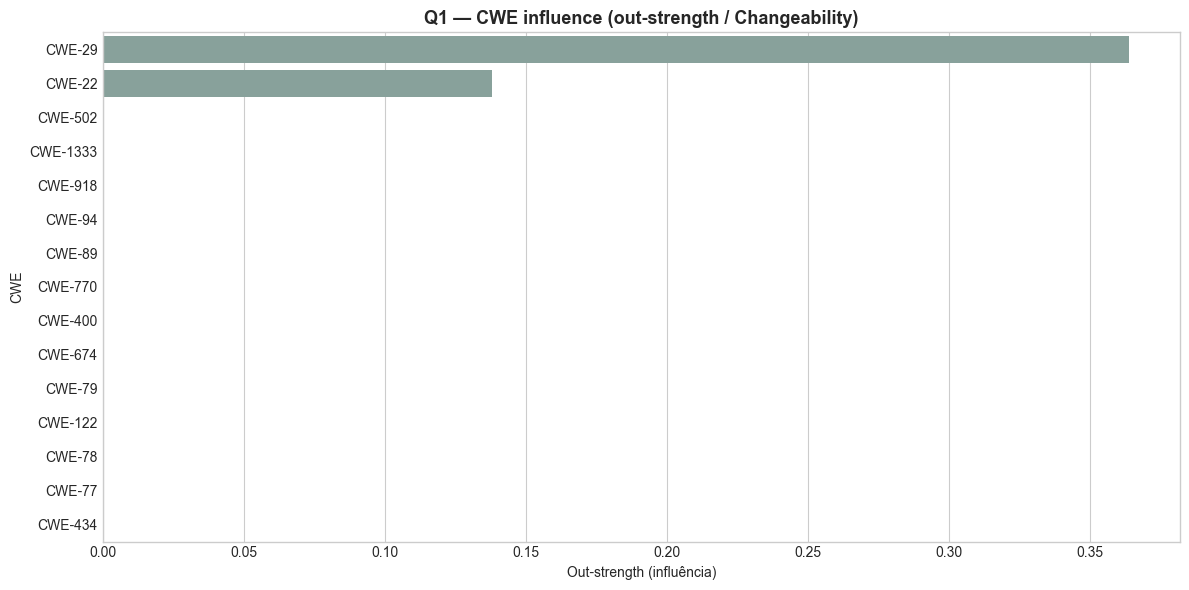

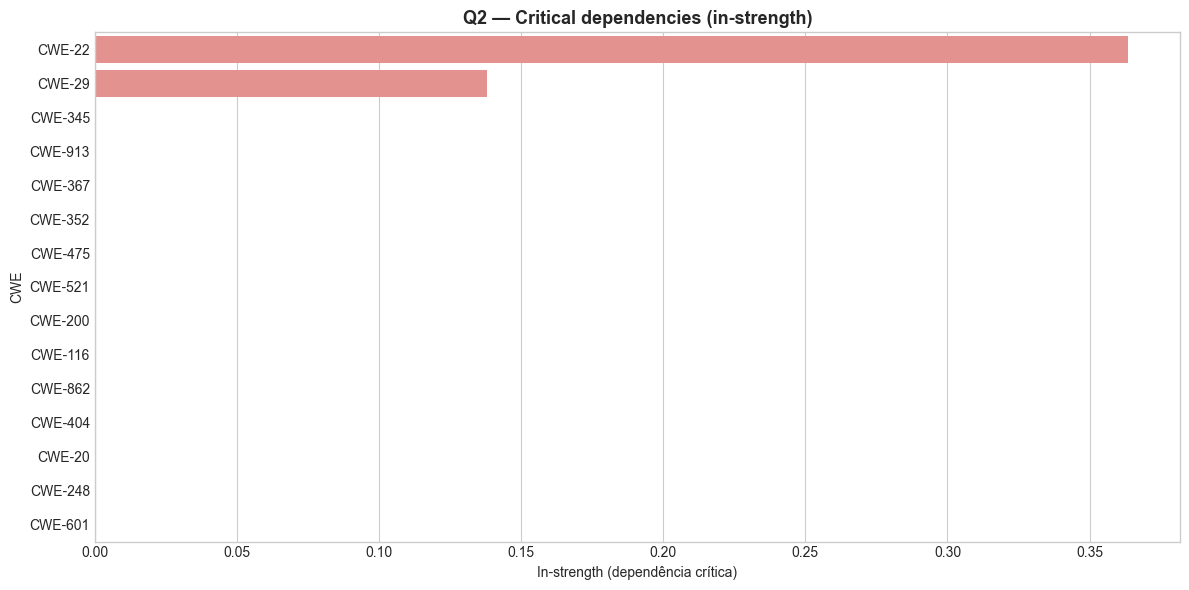

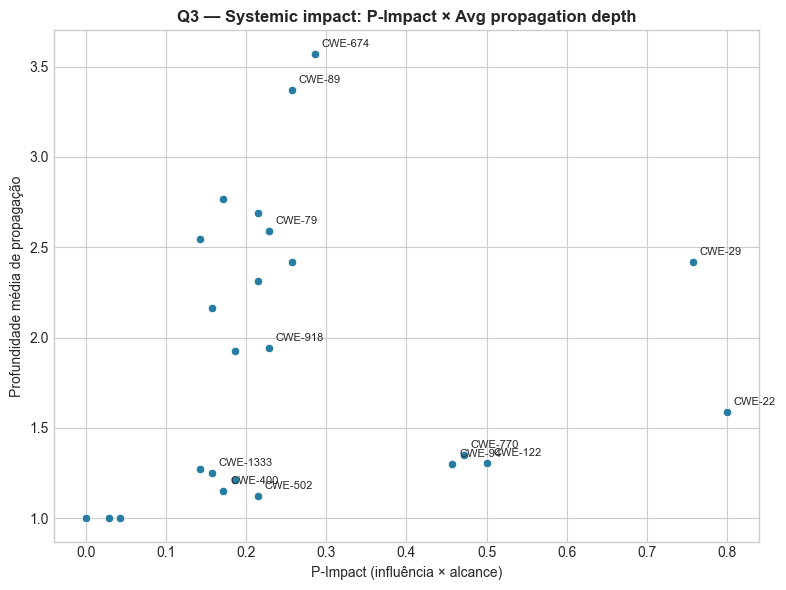

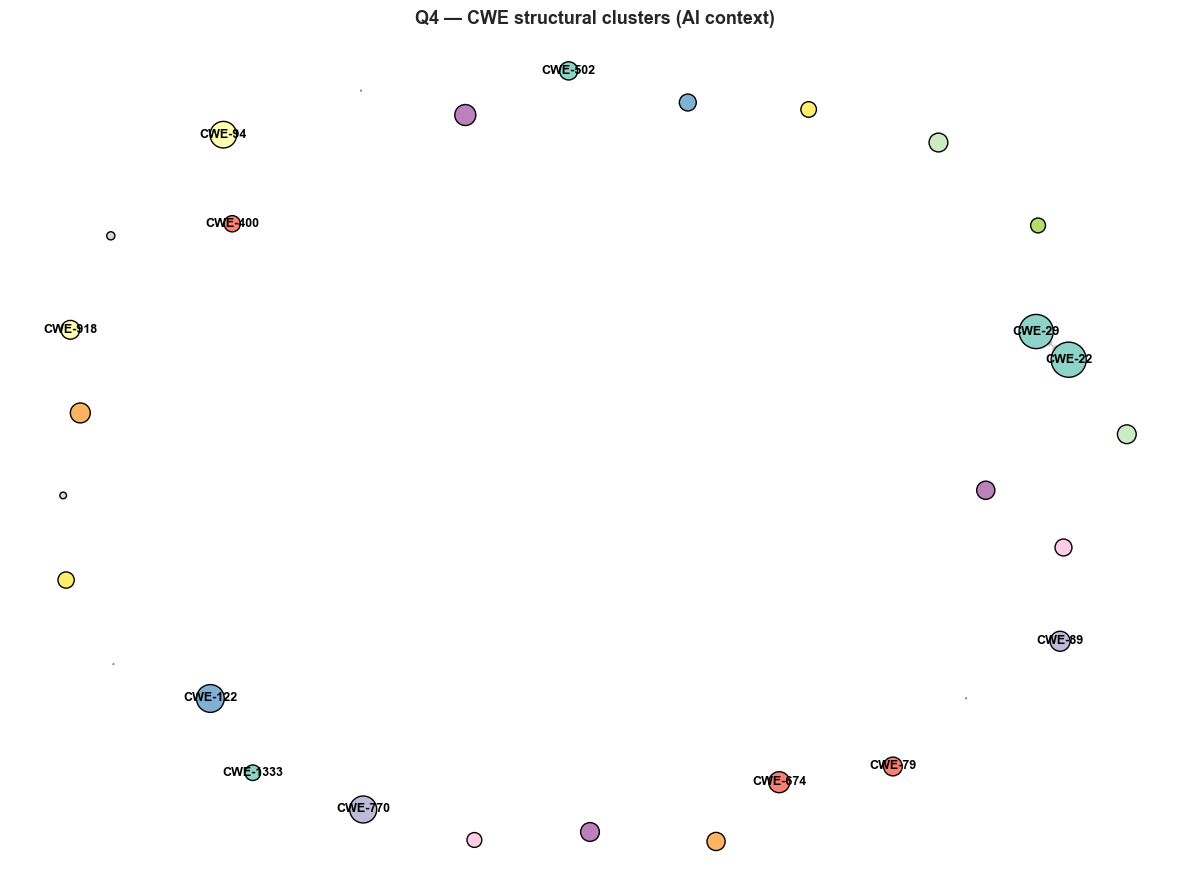

SUMMARY (AI CWEs) — nodes: 30 edges: 2
Q1 Top influencers (Changeability/Out-strength):
         cwe  out_strength  changeability_index  pagerank
4     CWE-29      0.363636                0.725       1.0
1     CWE-22      0.137931                0.275       1.0
0    CWE-502      0.000000                0.000       0.0
2   CWE-1333      0.000000                0.000       0.0
3    CWE-918      0.000000                0.000       0.0
5     CWE-94      0.000000                0.000       0.0
6     CWE-89      0.000000                0.000       0.0
7    CWE-770      0.000000                0.000       0.0
8    CWE-400      0.000000                0.000       0.0
9    CWE-674      0.000000                0.000       0.0
10    CWE-79      0.000000                0.000       0.0
11   CWE-122      0.000000                0.000       0.0
12    CWE-78      0.000000                0.000       0.0
13    CWE-77      0.000000                0.000       0.0
14   CWE-434      0.000000                

In [60]:
# Inputs
SRC_TIMELINE = 'outputs/top_pypi_snyk_timeline_20221112_20251112.csv'
DEPS_CSV    = 'python_dependencies_edges.csv'
DATE_START  = '2023-11-01'
DATE_END    = '2025-11-01'
TOP_K_CWE   = 30
MIN_PAIR    = 3
MIN_P       = 0.10

import pandas as pd, numpy as np, re, networkx as nx, matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
from itertools import combinations

def parse_cwes(val):
    if pd.isna(val): return []
    out=[]
    for p in re.split(r'[;,\s]+', str(val)):
        up=p.strip().upper()
        if up.startswith('CWE-'): out.append(up)
    return list(dict.fromkeys(out))

# Load and filter
df = pd.read_csv(SRC_TIMELINE)
for col in ['disclosed_date','first_affected_date','mitigation_date']:
    if col in df.columns: df[col] = pd.to_datetime(df[col], errors='coerce')
mask = (df['disclosed_date']>=pd.to_datetime(DATE_START)) & (df['disclosed_date']<=pd.to_datetime(DATE_END))
df = df.loc[mask].copy()
df['package_lower'] = df['package'].str.lower()
cwe_col = 'cwes' if 'cwes' in df.columns else ('CWE' if 'CWE' in df.columns else None)
df['cwe_list'] = df[cwe_col].apply(parse_cwes) if cwe_col else [[] for _ in range(len(df))]

# Restrict to AI libs
ai_set = {p.lower() for p in AI_LIBS}
ai_rows = df[df['package_lower'].isin(ai_set)].copy()

# Build CWE influence (directed co-occur) on AI subset to emphasize LLM code context
all_cwes=[c for lst in ai_rows['cwe_list'] for c in lst]
freq=Counter(all_cwes)
top_cwes=[c for c,_ in freq.most_common(TOP_K_CWE)]
pair=Counter()
for lst in ai_rows['cwe_list']:
    lst=[c for c in lst if c in top_cwes]
    if len(lst)>=2:
        seen=sorted(set(lst))
        for i in range(len(seen)):
            for j in range(i+1,len(seen)):
                a,b=seen[i],seen[j]; pair[(a,b)]+=1; pair[(b,a)]+=1
G_cwe = nx.DiGraph()
for c in top_cwes: G_cwe.add_node(c, freq=freq[c])
for (a,b),cnt in pair.items():
    if freq[a]>0:
        p=cnt/freq[a]
        if cnt>=MIN_PAIR and p>=MIN_P: G_cwe.add_edge(a,b,weight=p,count=cnt)

# Centralities (out/in strength) + Changeability Index (CI)
out_w = {n: sum(d.get('weight',1.0) for _,_,d in G_cwe.out_edges(n, data=True)) for n in G_cwe.nodes()}
in_w  = {n: sum(d.get('weight',1.0) for _,_,d in G_cwe.in_edges(n, data=True)) for n in G_cwe.nodes()}
CI = {n: (out_w.get(n,0.0) / (out_w.get(n,0.0)+in_w.get(n,0.0)+1e-12)) for n in G_cwe.nodes()}
try: pr = nx.pagerank(G_cwe, weight='weight')
except: pr={n:0 for n in G_cwe.nodes()}
# normalize PR
if pr: arr=np.array(list(pr.values())); mn, mx = arr.min(), arr.max(); pr_norm={k:(v-mn)/(mx-mn+1e-12) for k,v in pr.items()}
else: pr_norm={n:0 for n in G_cwe.nodes()}

# Dependency graph (lib -> requires); we'll use reverse to count dependents
deps = pd.read_csv(DEPS_CSV)
deps['source']=deps['source'].astype(str).str.lower(); deps['target']=deps['target'].astype(str).str.lower()
DG = nx.DiGraph(); DG.add_edges_from(deps[['source','target']].itertuples(index=False,name=None))
RG = DG.reverse(copy=True)

# For each CWE: packages (AI) that carry it; compute dependent reach & avg propagation depth from all those packages
cwe_to_pkgs = {}
for _,row in ai_rows.iterrows():
    for c in row['cwe_list']:
        if c in top_cwes:
            cwe_to_pkgs.setdefault(c,set()).add(row['package_lower'])

metrics=[]
from collections import deque
for c in top_cwes:
    seeds = list(cwe_to_pkgs.get(c,set()))
    total=0; dsum=0; seen=set(seeds)
    q=deque([(s,0) for s in seeds if s in RG])
    while q:
        u,d=q.popleft()
        for v in RG.successors(u):
            if v not in seen:
                seen.add(v); q.append((v,d+1)); total+=1; dsum+=d+1
    avg_depth=(dsum/total) if total>0 else 0.0
    metrics.append({'cwe':c,'freq_ai':len(seeds),'out_strength':out_w.get(c,0.0),'in_strength':in_w.get(c,0.0),
                   'changeability_index':CI.get(c,0.0),'pagerank':pr_norm.get(c,0.0),'dependent_reach':total,'avg_depth':avg_depth})

cwe_ai_metrics = pd.DataFrame(metrics).sort_values(['pagerank','out_strength'], ascending=False)
# P-Impact at CWE level (influence × reach)
if len(cwe_ai_metrics)>0:
    r=cwe_ai_metrics['dependent_reach'].astype(float); rnorm=(r-r.min())/(r.max()-r.min()+1e-12)
    cwe_ai_metrics['p_impact'] = 0.5*cwe_ai_metrics['pagerank'] + 0.5*rnorm
else:
    cwe_ai_metrics['p_impact']=0.0
cwe_ai_metrics.to_csv('outputs/summaries/ai_cwe_propagation_metrics.csv', index=False)
print('Saved: outputs/summaries/ai_cwe_propagation_metrics.csv')

# Plots to answer questions
top_inf = cwe_ai_metrics.head(15)
fig, ax = plt.subplots(1,1, figsize=(12,6))
sns.barplot(data=top_inf, x='out_strength', y='cwe', ax=ax, color='#84a59d')
ax.set_title('Q1 — CWE influence (out-strength / Changeability)', fontsize=13, fontweight='bold'); ax.set_xlabel('Out-strength (influência)'); ax.set_ylabel('CWE')
plt.tight_layout(); plt.savefig('outputs/plots/ai_cwe_q1_influence.png', dpi=300, bbox_inches='tight'); plt.show()

# Q2 — fragilidade (in-strength)
top_frag = cwe_ai_metrics.sort_values(['in_strength'], ascending=False).head(15)
fig, ax = plt.subplots(1,1, figsize=(12,6)); sns.barplot(data=top_frag, x='in_strength', y='cwe', ax=ax, color='#f28482')
ax.set_title('Q2 — Critical dependencies (in-strength)', fontsize=13, fontweight='bold'); ax.set_xlabel('In-strength (dependência crítica)'); ax.set_ylabel('CWE')
plt.tight_layout(); plt.savefig('outputs/plots/ai_cwe_q2_fragility.png', dpi=300, bbox_inches='tight'); plt.show()

# Q3 — impacto sistêmico: P-Impact × profundidade média
fig, ax = plt.subplots(1,1, figsize=(8,6)); sns.scatterplot(data=cwe_ai_metrics, x='p_impact', y='avg_depth', ax=ax, color='#277da1')
for _,row in cwe_ai_metrics.head(12).iterrows(): ax.annotate(row['cwe'], (row['p_impact'], row['avg_depth']), xytext=(5,5), textcoords='offset points', fontsize=8)
ax.set_title('Q3 — Systemic impact: P-Impact × Avg propagation depth', fontsize=12, fontweight='bold'); ax.set_xlabel('P-Impact (influência × alcance)'); ax.set_ylabel('Profundidade média de propagação')
plt.tight_layout(); plt.savefig('outputs/plots/ai_cwe_q3_systemic.png', dpi=300, bbox_inches='tight'); plt.show()

# Q4 — clusters estruturais de CWEs (comunidades)
UG = G_cwe.to_undirected(); from networkx.algorithms import community
comms = list(community.greedy_modularity_communities(UG, weight='weight')) if UG.number_of_edges()>0 else []
node2comm={}; 
for i,c in enumerate(comms):
    for n in c: node2comm[n]=i
fig, ax = plt.subplots(1,1, figsize=(12,9)); pos = nx.spring_layout(G_cwe, weight='weight', seed=42)
colors = plt.cm.Set3(np.linspace(0,1,max(1,len(comms)))) if len(comms)>0 else ['#a0c4ff']
node_color=[colors[node2comm.get(n,0)] for n in G_cwe.nodes()]
node_size=[800*(cwe_ai_metrics.set_index('cwe').loc[n,'p_impact']+1e-4) if n in cwe_ai_metrics['cwe'].values else 200 for n in G_cwe.nodes()]
nx.draw_networkx_edges(G_cwe, pos, alpha=0.25, edge_color='gray', ax=ax)
nx.draw_networkx_nodes(G_cwe, pos, node_color=node_color, node_size=node_size, edgecolors='black', linewidths=1.0, ax=ax)
labs={row['cwe']: row['cwe'] for _,row in cwe_ai_metrics.head(12).iterrows()}
nx.draw_networkx_labels(G_cwe, pos, labels=labs, font_size=9, font_weight='bold', ax=ax)
ax.set_title('Q4 — CWE structural clusters (AI context)', fontsize=13, fontweight='bold'); ax.axis('off')
plt.tight_layout(); plt.savefig('outputs/plots/ai_cwe_q4_clusters.png', dpi=300, bbox_inches='tight'); plt.show()

# Quick answers (printed)
print('SUMMARY (AI CWEs) — nodes:', G_cwe.number_of_nodes(), 'edges:', G_cwe.number_of_edges())
print('Q1 Top influencers (Changeability/Out-strength):')
print(top_inf[['cwe','out_strength','changeability_index','pagerank']])
print('Q2 Critical dependencies (In-strength):')
print(top_frag[['cwe','in_strength','pagerank','freq_ai']])
print('Q3 Systemic impact (P-Impact & Avg depth):')
print(cwe_ai_metrics[['cwe','p_impact','dependent_reach','avg_depth']].head(10))
print('Q4 Communities (cluster sizes):', [len(c) for c in comms])


## 10.2 CWE SPOF and Out-degree (AI context)

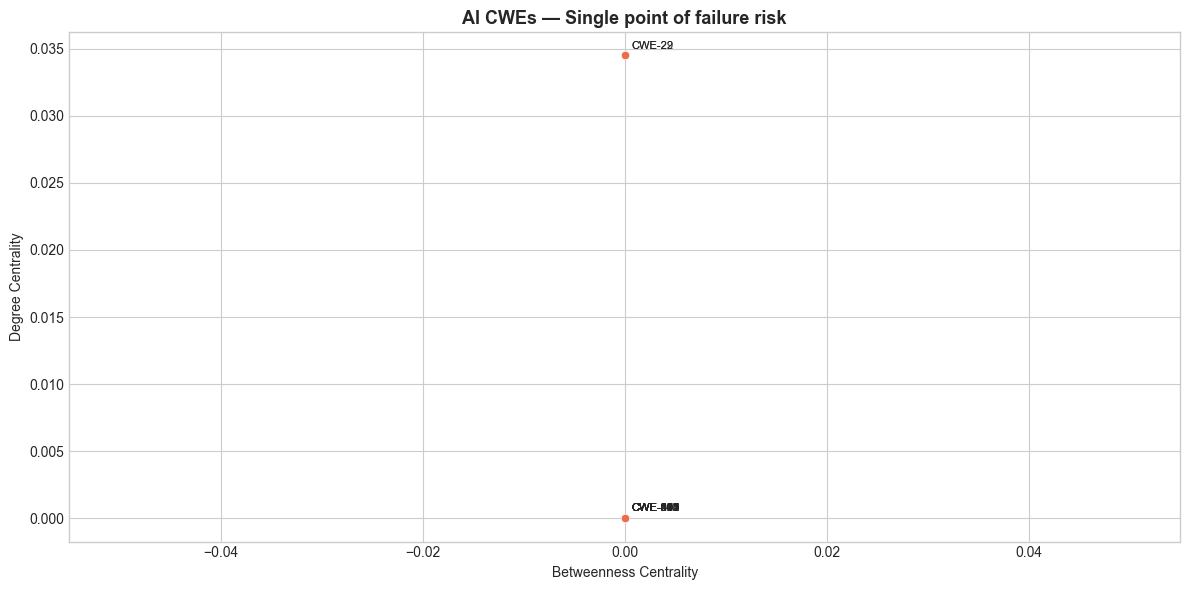

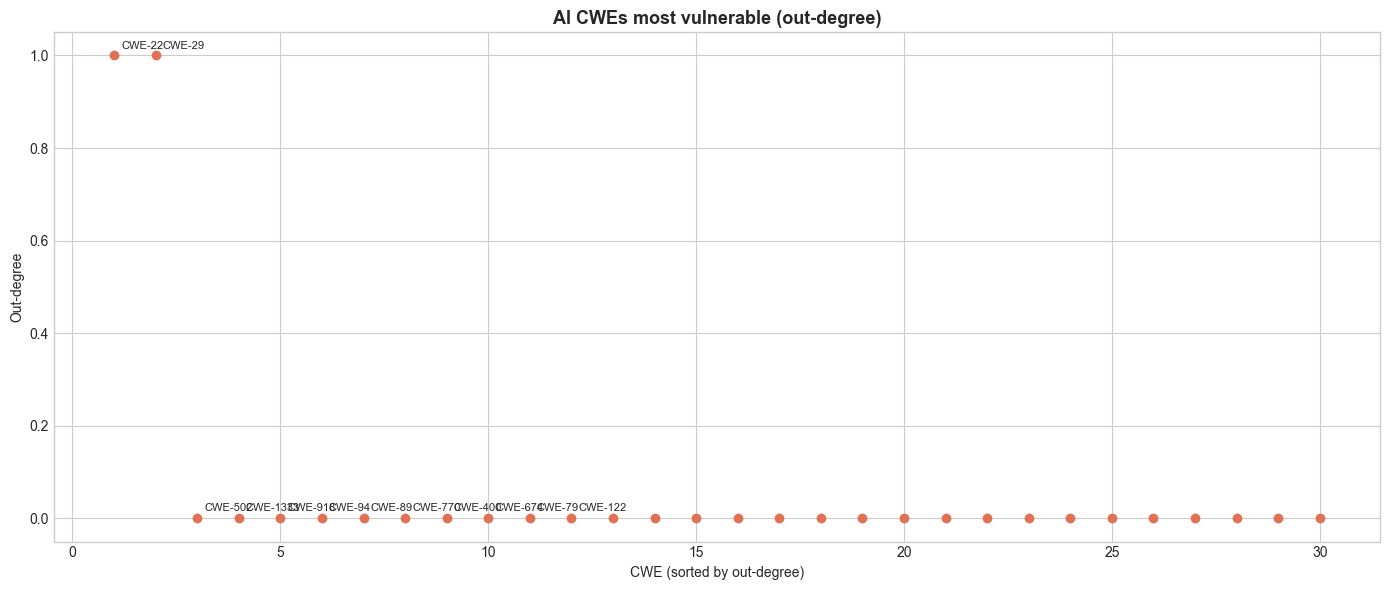

In [62]:
# Requires G_cwe and cwe_ai_metrics from 10.1
import networkx as nx, numpy as np, matplotlib.pyplot as plt, seaborn as sns
UG = G_cwe.to_undirected()
try:
    btw = nx.betweenness_centrality(UG, weight='weight', normalized=True)
except Exception:
    btw = {n:0 for n in G_cwe.nodes()}
deg_cent = nx.degree_centrality(UG) if UG.number_of_nodes()>0 else {n:0 for n in G_cwe.nodes()}
plot_df = []
for n in G_cwe.nodes(): plot_df.append({'cwe':n,'betweenness':btw.get(n,0.0),'degree_centrality':deg_cent.get(n,0.0)})
import pandas as pd
plot_df = pd.DataFrame(plot_df).sort_values('degree_centrality', ascending=False)

# SPOF scatter
fig, ax = plt.subplots(1,1, figsize=(12,6))
sns.scatterplot(data=plot_df, x='betweenness', y='degree_centrality', color='#ee6c4d', ax=ax)
for _,row in plot_df.head(12).iterrows():
    ax.annotate(row['cwe'], (row['betweenness'], row['degree_centrality']), xytext=(5,5), textcoords='offset points', fontsize=8)
ax.set_title('AI CWEs — Single point of failure risk', fontsize=13, fontweight='bold')
ax.set_xlabel('Betweenness Centrality'); ax.set_ylabel('Degree Centrality')
plt.tight_layout(); plt.savefig('outputs/plots/ai_cwe_spof_scatter.png', dpi=300, bbox_inches='tight'); plt.show()

# Out-degree ranking curve
out_deg = [(n, G_cwe.out_degree(n)) for n in G_cwe.nodes()]
out_deg = sorted(out_deg, key=lambda x: x[1], reverse=True)
x = list(range(1, len(out_deg)+1)); y = [v for _,v in out_deg]
fig, ax = plt.subplots(1,1, figsize=(14,6))
ax.scatter(x, y, color='#e76f51')
for i,(n,v) in enumerate(out_deg[:12]):
    ax.annotate(n, (i+1, v), xytext=(5,5), textcoords='offset points', fontsize=8)
ax.set_title('AI CWEs most vulnerable (out-degree)', fontsize=13, fontweight='bold')
ax.set_xlabel('CWE (sorted by out-degree)'); ax.set_ylabel('Out-degree')
plt.tight_layout(); plt.savefig('outputs/plots/ai_cwe_outdegree_curve.png', dpi=300, bbox_inches='tight'); plt.show()
